In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import random
import pywt
import seaborn as sns
import os
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sys
sys.path.append('..')

from src.diffusion import UNet, Diffusion
from src.preprocessing import WaveletDetrendingPipeline, visualize_detrending_effect
# If you use statsmodels in other cells:
# from statsmodels.tsa.stattools import acf


In [2]:
import torch
print(f"Is CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.get_device_name(0)}")

Is CUDA available: True
Current device: NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
# Download stock data and prepare all datasets for analysis
# This cell creates all variables needed for subsequent visualization and analysis

import yfinance as yf
import pandas as pd
import numpy as np

# CONFIGURABLE PARAMETERS
WINDOW_LENGTH =256  # Time series window length (must be power of 2)
STRIDE = 1 # Stride for sliding window (1 = maximum overlap, WINDOW_LENGTH = no overlap)

# Download data for multiple tickers
tickers = [ 'AAPL', 'META', 'MSFT', 'AMZN']
start_date = '2014-01-01'
end_date = '2024-12-31'

# Data structures to store results for VOLUME
ticker_info = []
ticker_log_volumes = {}  # Store full log volume series per ticker
ticker_zscore_volumes = {}  # Store full z-score normalized series per ticker
ticker_windows = {}  # Store log volume windows per ticker
ticker_windows_global_zscore = {}  # Store z-score normalized windows per ticker

# Data structures to store results for LOG RETURNS
ticker_log_returns = {}  # Store full log returns series per ticker
ticker_zscore_log_returns = {}  # Store full z-score normalized log returns per ticker
ticker_windows_log_returns = {}  # Store log returns windows per ticker
ticker_windows_global_zscore_log_returns = {}  # Store z-score normalized log returns windows per ticker

# Data structures to store results for VOLATILITY (squared log returns - captures volatility clustering)
ticker_volatility = {}  # Store full volatility series per ticker
ticker_zscore_volatility = {}  # Store full z-score normalized volatility per ticker
ticker_windows_volatility = {}  # Store volatility windows per ticker
ticker_windows_global_zscore_volatility = {}  # Store z-score normalized volatility windows per ticker

# Step 1: Download data and apply log transform for VOLUME, compute LOG RETURNS and VOLATILITY
for ticker in tickers:
    data = yf.download(ticker, interval='1d', start=start_date, end=end_date, auto_adjust=True, progress=False)
    
    # Select Volume and Close columns
    volume_data = data[['Volume']].copy()
    close_data = data[['Close']].copy()
    volume_data.index.name = 'date'
    close_data.index.name = 'date'
    
    # Apply log transform to Volume
    log_volume = np.log1p(volume_data['Volume'].values)
    
    # Compute log returns from Close prices
    log_returns = np.log(close_data['Close'] / close_data['Close'].shift(1)).values[1:]  # Remove first NaN
    
    # Compute volatility as SQUARED log returns (captures volatility clustering without rolling window)
    # This avoids autocorrelation artifacts from overlapping windows
    # volatility = log_returns ** 2  # Squared returns = instantaneous volatility proxy
    
    # Apply log transform to volatility to make distribution more Gaussian
    # Add small epsilon to avoid log(0)
    volatility = np.log(log_returns ** 2 + 1e-8)
    
    # Align all series to the same length (shortest series after log returns computation)
    min_length = min(len(log_volume), len(log_returns), len(volatility))
    log_volume = log_volume[-min_length:]  # Take last min_length values
    log_returns = log_returns[-min_length:]
    volatility = volatility[-min_length:]
    
    # Store full series
    ticker_log_volumes[ticker] = log_volume
    ticker_log_returns[ticker] = log_returns
    ticker_volatility[ticker] = volatility
    
    # Store metadata
    ticker_info.append({
        'ticker': ticker,
        'length': len(log_volume),
        'log_volume': log_volume,
        'log_returns': log_returns,
        'volatility': volatility
    })

# Step 2: Apply global z-score normalization (after log transform for volume, directly for log returns and volatility)
ticker_stats = {}

for ticker in tickers:
    ticker_stats[ticker] = {}
    
    # VOLUME: z-score normalization
    log_volume = ticker_log_volumes[ticker]
    mean_global = log_volume.mean()
    std_global = log_volume.std()
    ticker_stats[ticker]['volume_mean'] = mean_global
    ticker_stats[ticker]['volume_std'] = std_global
    
    log_volume_zscore = (log_volume - mean_global) / std_global
    # log_volume_zscore = np.clip(log_volume_zscore, -6, 6) # Removed clipping to preserve fat tails
    ticker_zscore_volumes[ticker] = log_volume_zscore
    
    # LOG RETURNS: z-score normalization
    log_returns = ticker_log_returns[ticker]
    mean_returns = log_returns.mean()
    std_returns = log_returns.std()
    ticker_stats[ticker]['returns_mean'] = mean_returns
    ticker_stats[ticker]['returns_std'] = std_returns

    log_returns_zscore = (log_returns - mean_returns) / std_returns
    # log_returns_zscore = np.clip(log_returns_zscore, -6, 6) # Removed clipping to preserve fat tails
    ticker_zscore_log_returns[ticker] = log_returns_zscore
    
    # VOLATILITY (squared returns): z-score normalization
    volatility = ticker_volatility[ticker]
    mean_vol = volatility.mean()
    std_vol = volatility.std()
    ticker_stats[ticker]['volatility_mean'] = mean_vol
    ticker_stats[ticker]['volatility_std'] = std_vol

    volatility_zscore = (volatility - mean_vol) / std_vol
    # volatility_zscore = np.clip(volatility_zscore, -6, 6) # Removed clipping to preserve fat tails
    ticker_zscore_volatility[ticker] = volatility_zscore

# Step 3: Create windowed datasets (sliding window with stride=1)
all_volume_series = []  # All log volume windows concatenated
all_zscore_series = []  # All z-score volume windows concatenated
all_log_returns_series = []  # All log returns windows concatenated
all_zscore_log_returns_series = []  # All z-score log returns windows concatenated
all_volatility_series = []  # All volatility windows concatenated
all_zscore_volatility_series = []  # All z-score volatility windows concatenated

for ticker in tickers:
    log_volume = ticker_log_volumes[ticker]
    log_volume_zscore = ticker_zscore_volumes[ticker]
    log_returns = ticker_log_returns[ticker]
    log_returns_zscore = ticker_zscore_log_returns[ticker]
    volatility = ticker_volatility[ticker]
    volatility_zscore = ticker_zscore_volatility[ticker]
    
    # Create log volume windows
    ticker_series = []
    for i in range(0, len(log_volume) - WINDOW_LENGTH + 1, STRIDE):
        window = log_volume[i:i + WINDOW_LENGTH]
        ticker_series.append(window)
    ticker_series = np.array(ticker_series, dtype=np.float32)
    ticker_windows[ticker] = ticker_series
    all_volume_series.append(ticker_series)
    
    # Create z-score normalized volume windows
    ticker_series_zscore = []
    for i in range(0, len(log_volume_zscore) - WINDOW_LENGTH + 1, STRIDE):
        window = log_volume_zscore[i:i + WINDOW_LENGTH]
        ticker_series_zscore.append(window)
    ticker_series_zscore = np.array(ticker_series_zscore, dtype=np.float32)
    ticker_windows_global_zscore[ticker] = ticker_series_zscore
    all_zscore_series.append(ticker_series_zscore)
    
    # Create log returns windows
    ticker_series_returns = []
    for i in range(0, len(log_returns) - WINDOW_LENGTH + 1, STRIDE):
        window = log_returns[i:i + WINDOW_LENGTH]
        ticker_series_returns.append(window)
    ticker_series_returns = np.array(ticker_series_returns, dtype=np.float32)
    ticker_windows_log_returns[ticker] = ticker_series_returns
    all_log_returns_series.append(ticker_series_returns)
    
    # Create z-score normalized log returns windows
    ticker_series_returns_zscore = []
    for i in range(0, len(log_returns_zscore) - WINDOW_LENGTH + 1, STRIDE):
        window = log_returns_zscore[i:i + WINDOW_LENGTH]
        ticker_series_returns_zscore.append(window)
    ticker_series_returns_zscore = np.array(ticker_series_returns_zscore, dtype=np.float32)
    ticker_windows_global_zscore_log_returns[ticker] = ticker_series_returns_zscore
    all_zscore_log_returns_series.append(ticker_series_returns_zscore)
    
    # Create volatility windows
    ticker_series_vol = []
    for i in range(0, len(volatility) - WINDOW_LENGTH + 1, STRIDE):
        window = volatility[i:i + WINDOW_LENGTH]
        ticker_series_vol.append(window)
    ticker_series_vol = np.array(ticker_series_vol, dtype=np.float32)
    ticker_windows_volatility[ticker] = ticker_series_vol
    all_volatility_series.append(ticker_series_vol)
    
    # Create z-score normalized volatility windows
    ticker_series_vol_zscore = []
    for i in range(0, len(volatility_zscore) - WINDOW_LENGTH + 1, STRIDE):
        window = volatility_zscore[i:i + WINDOW_LENGTH]
        ticker_series_vol_zscore.append(window)
    ticker_series_vol_zscore = np.array(ticker_series_vol_zscore, dtype=np.float32)
    ticker_windows_global_zscore_volatility[ticker] = ticker_series_vol_zscore
    all_zscore_volatility_series.append(ticker_series_vol_zscore)

# Step 4: Concatenate all windows across tickers
volume_series = np.concatenate(all_volume_series, axis=0)  # All log volume windows
all_windows_combined_volumes = np.concatenate(all_zscore_series, axis=0)  # All z-score volume windows

log_returns_series = np.concatenate(all_log_returns_series, axis=0)  # All log returns windows
all_windows_combined_log_returns = np.concatenate(all_zscore_log_returns_series, axis=0)  # All z-score log returns windows

volatility_series = np.concatenate(all_volatility_series, axis=0)  # All volatility windows
all_windows_combined_volatility = np.concatenate(all_zscore_volatility_series, axis=0)  # All z-score volatility windows

print(f"Dataset created successfully!")
print(f"Volume: {all_windows_combined_volumes.shape[0]} windows of length {WINDOW_LENGTH}")
print(f"Log Returns: {all_windows_combined_log_returns.shape[0]} windows of length {WINDOW_LENGTH}")
print(f"Volatility (log squared returns): {all_windows_combined_volatility.shape[0]} windows of length {WINDOW_LENGTH}")
print(f"\nVolatility calculation: log of squared log returns (no rolling window)")
print(f"  - Captures volatility clustering (GARCH-like behavior)")
print(f"  - No autocorrelation artifacts from overlapping windows")
print(f"  - Log transform makes distribution more Gaussian (better for diffusion)")
print(f"  - Same temporal resolution as log returns")

# Save normalization parameters for later reconstruction
np.save('ticker_stats.npy', ticker_stats)
print(f"Saved ticker statistics to 'ticker_stats.npy'")

Dataset created successfully!
Volume: 10044 windows of length 256
Log Returns: 10044 windows of length 256
Volatility (log squared returns): 10044 windows of length 256

Volatility calculation: log of squared log returns (no rolling window)
  - Captures volatility clustering (GARCH-like behavior)
  - No autocorrelation artifacts from overlapping windows
  - Log transform makes distribution more Gaussian (better for diffusion)
  - Same temporal resolution as log returns
Saved ticker statistics to 'ticker_stats.npy'


VOLUME ANALYSIS: USING FULL TIME SERIES PER TICKER (NOT WINDOWED)
AAPL: Mean=-0.000000, Std=1.000000, Length=2766
META: Mean=0.000000, Std=1.000000, Length=2766
META: Mean=0.000000, Std=1.000000, Length=2766
MSFT: Mean=0.000000, Std=1.000000, Length=2766
AMZN: Mean=0.000000, Std=1.000000, Length=2766
MSFT: Mean=0.000000, Std=1.000000, Length=2766
AMZN: Mean=0.000000, Std=1.000000, Length=2766


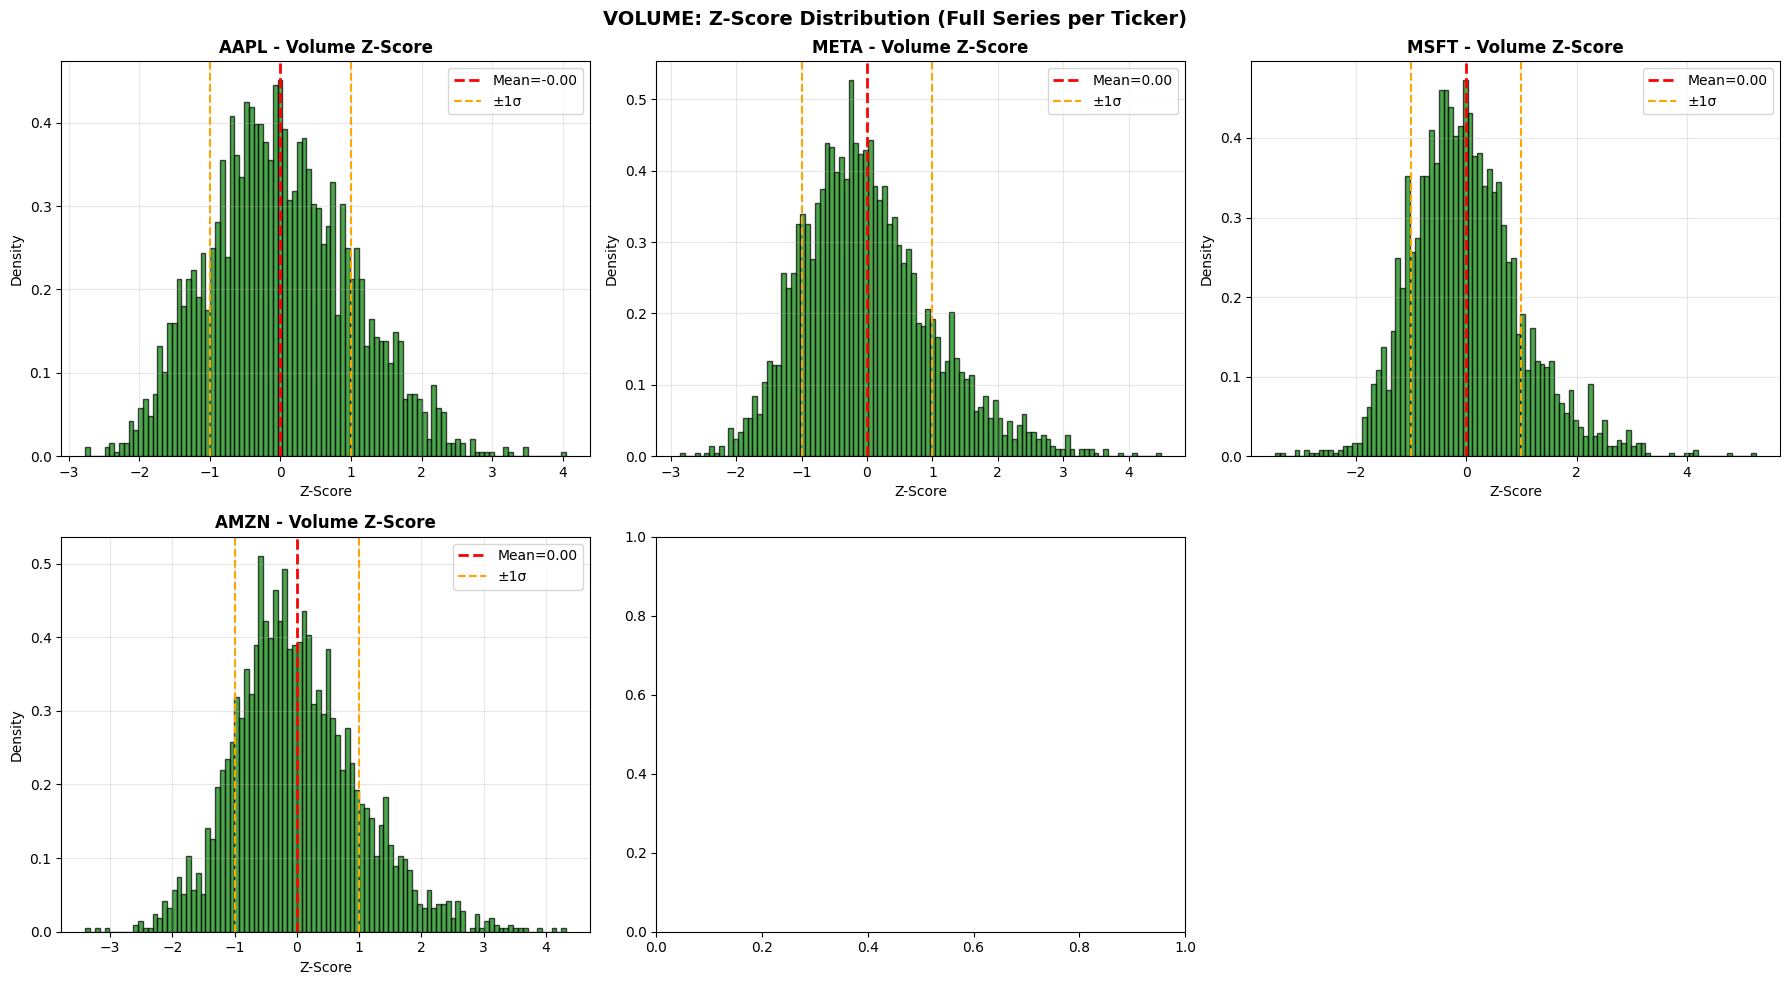

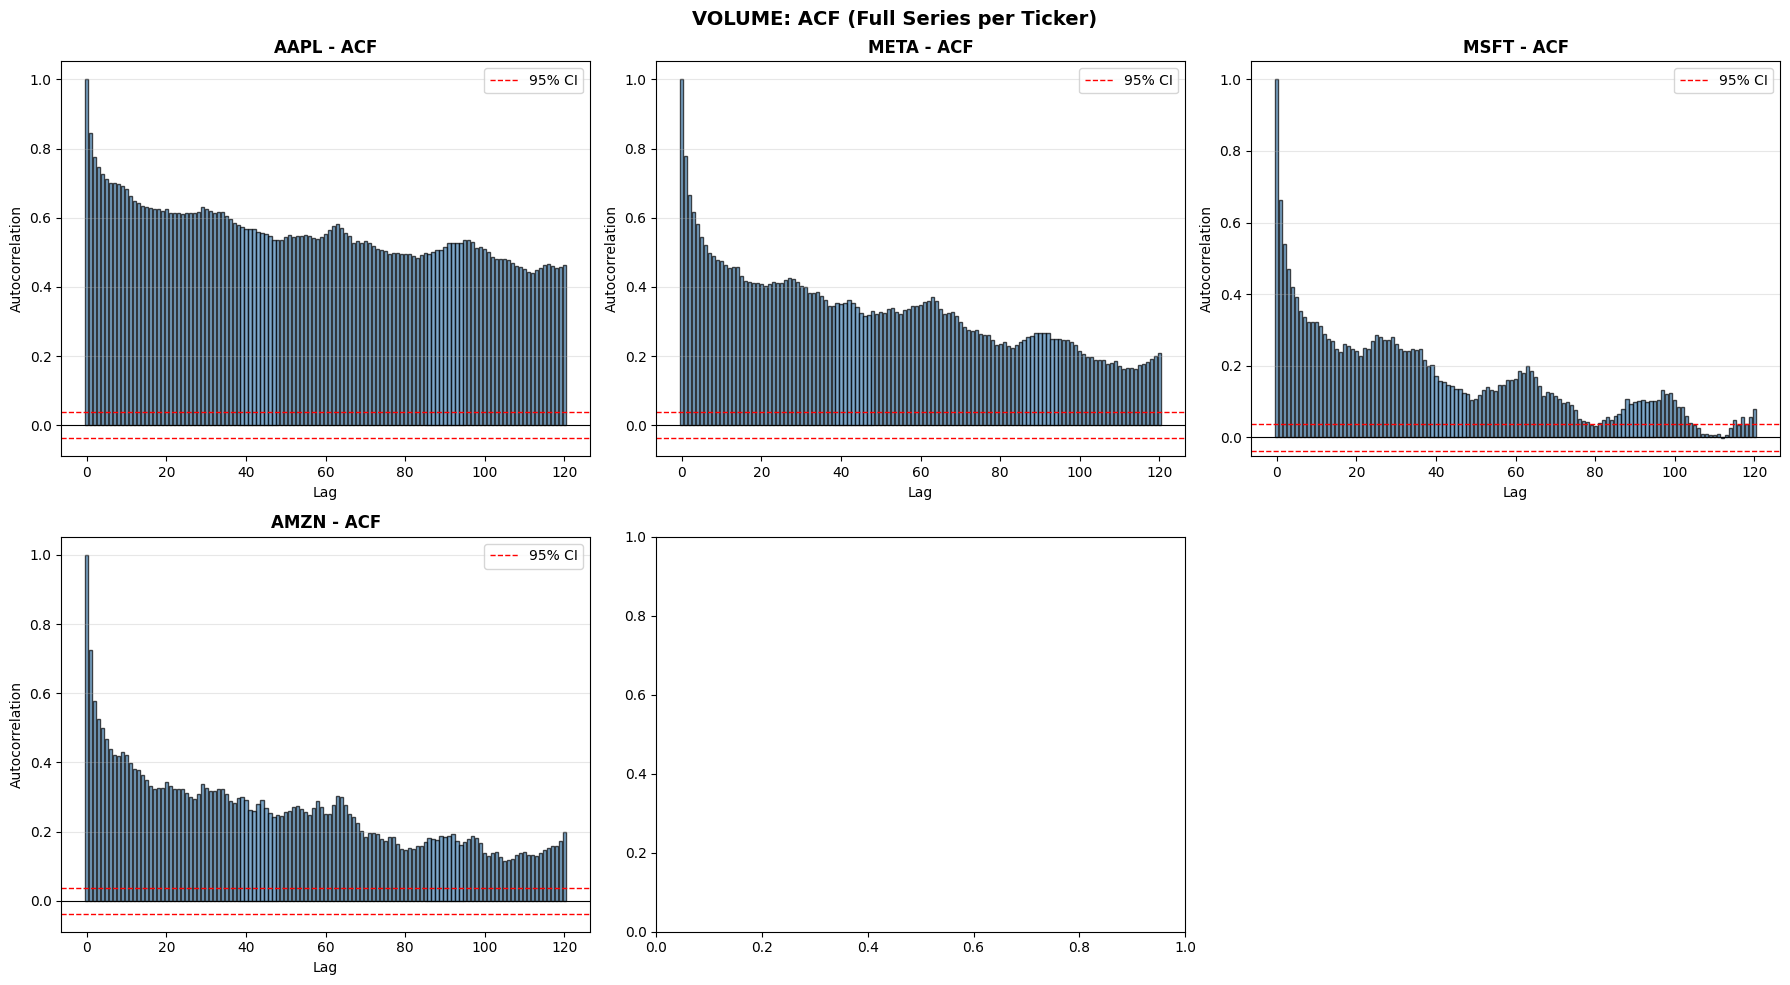


COMBINED ANALYSIS: AVERAGE ACF + POOLED DISTRIBUTION
Combined dataset statistics (POOLED):
  Total length: 11064
  Mean: 0.000000
  Std: 1.000000
  Min: -3.464707
  Max: 5.254453

Calculating average ACF (mean of 4 ticker ACFs)...


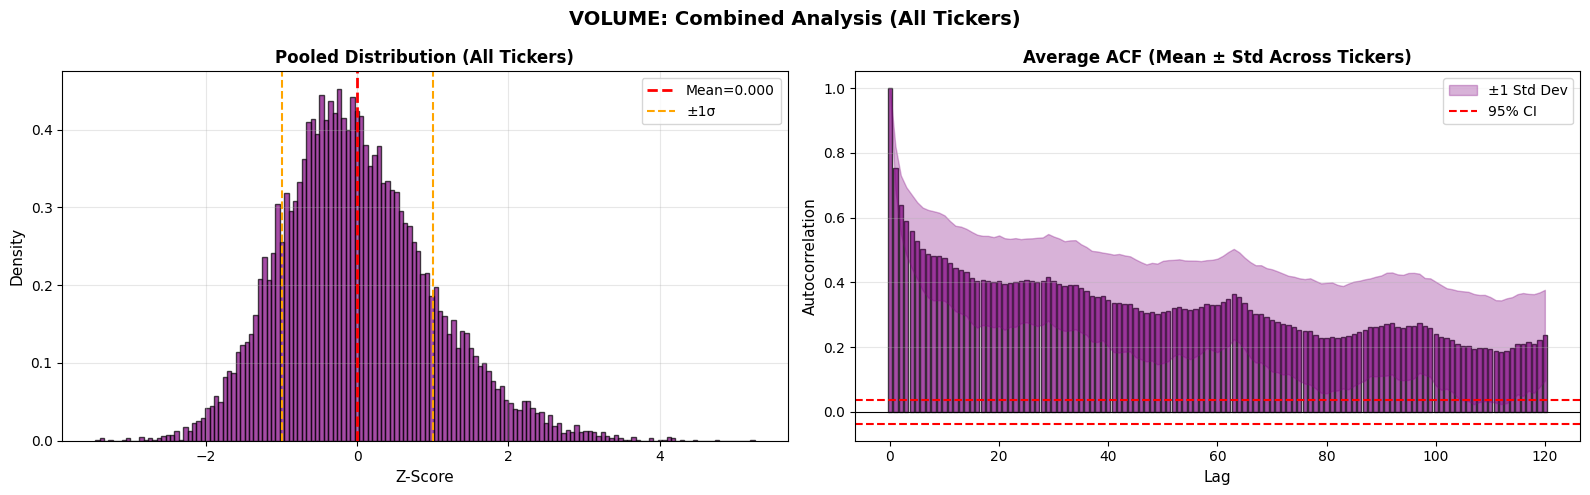


Average ACF (first 10 lags):
  Lag  0:  1.0000 (±0.0000)
  Lag  1:  0.7533 (±0.0676)
  Lag  2:  0.6398 (±0.0905)
  Lag  3:  0.5894 (±0.1046)
  Lag  4:  0.5573 (±0.1134)
  Lag  5:  0.5291 (±0.1184)
  Lag  6:  0.5033 (±0.1278)
  Lag  7:  0.4887 (±0.1351)
  Lag  8:  0.4819 (±0.1379)
  Lag  9:  0.4803 (±0.1351)


In [4]:
# Visualization of distributions and ACF for all datasets
# IMPORTANT: Analysis uses full series per ticker (NOT windowed data)
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("VOLUME ANALYSIS: USING FULL TIME SERIES PER TICKER (NOT WINDOWED)")
print("="*80)

# 1. Visualize z-score distributions for each ticker (from full series, not windows)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
fig.suptitle('VOLUME: Z-Score Distribution (Full Series per Ticker)', fontsize=14, fontweight='bold')

for idx, ticker in enumerate(tickers):
    # Get FULL z-score normalized series (not windows)
    series_zscore = ticker_zscore_volumes[ticker]
    
    # Plot distribution
    axes[idx].hist(series_zscore, bins=100, color='green', edgecolor='black', alpha=0.7, density=True)
    axes[idx].set_title(f'{ticker} - Volume Z-Score', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Z-Score', fontsize=10)
    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    
    mean_val = series_zscore.mean()
    std_val = series_zscore.std()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_val:.2f}')
    axes[idx].axvline(mean_val + std_val, color='orange', linestyle='--', linewidth=1.5, label=f'±1σ')
    axes[idx].axvline(mean_val - std_val, color='orange', linestyle='--', linewidth=1.5)
    axes[idx].legend()
    
    print(f"{ticker}: Mean={mean_val:.6f}, Std={std_val:.6f}, Length={len(series_zscore)}")

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# 2. Calculate and plot ACF for each ticker (from full series, not windows)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
fig.suptitle('VOLUME: ACF (Full Series per Ticker)', fontsize=14, fontweight='bold')

for idx, ticker in enumerate(tickers):
    # Get FULL z-score normalized series (not windows)
    series_zscore = ticker_zscore_volumes[ticker]
    
    # Calculate ACF on full series
    acf_values = acf(series_zscore, nlags=120, fft=True)
    
    # Plot ACF
    axes[idx].bar(range(len(acf_values)), acf_values, width=0.8, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[idx].axhline(y=1.96/np.sqrt(len(series_zscore)), color='red', linestyle='--', linewidth=1, label='95% CI')
    axes[idx].axhline(y=-1.96/np.sqrt(len(series_zscore)), color='red', linestyle='--', linewidth=1)
    axes[idx].set_title(f'{ticker} - ACF', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Lag', fontsize=10)
    axes[idx].set_ylabel('Autocorrelation', fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].legend()

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# 3. Combined analysis: AVERAGE ACF and proper distribution
print("\n" + "="*80)
print("COMBINED ANALYSIS: AVERAGE ACF + POOLED DISTRIBUTION")
print("="*80)

# 3a. Pooled distribution (all data combined)
all_volume_series_combined = np.concatenate([ticker_zscore_volumes[ticker] for ticker in tickers])

print(f"Combined dataset statistics (POOLED):")
print(f"  Total length: {len(all_volume_series_combined)}")
print(f"  Mean: {all_volume_series_combined.mean():.6f}")
print(f"  Std: {all_volume_series_combined.std():.6f}")
print(f"  Min: {all_volume_series_combined.min():.6f}")
print(f"  Max: {all_volume_series_combined.max():.6f}")

# Plot combined distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('VOLUME: Combined Analysis (All Tickers)', fontsize=14, fontweight='bold')

# Distribution
axes[0].hist(all_volume_series_combined, bins=150, color='purple', edgecolor='black', alpha=0.7, density=True)
axes[0].set_title('Pooled Distribution (All Tickers)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Z-Score', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
mean_all = all_volume_series_combined.mean()
std_all = all_volume_series_combined.std()
axes[0].axvline(mean_all, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_all:.3f}')
axes[0].axvline(mean_all + std_all, color='orange', linestyle='--', linewidth=1.5, label=f'±1σ')
axes[0].axvline(mean_all - std_all, color='orange', linestyle='--', linewidth=1.5)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 3b. Average ACF (mean of individual ACFs)
print(f"\nCalculating average ACF (mean of {len(tickers)} ticker ACFs)...")
acf_list = []
for ticker in tickers:
    series_zscore = ticker_zscore_volumes[ticker]
    acf_values = acf(series_zscore, nlags=120, fft=True)
    acf_list.append(acf_values)

acf_average = np.mean(acf_list, axis=0)
acf_std = np.std(acf_list, axis=0)

# Plot average ACF
axes[1].bar(range(len(acf_average)), acf_average, width=0.8, color='purple', edgecolor='black', alpha=0.7)
# Add uncertainty band (±1 std)
axes[1].fill_between(range(len(acf_average)), 
                      acf_average - acf_std, 
                      acf_average + acf_std, 
                      alpha=0.3, color='purple', label='±1 Std Dev')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].axhline(y=1.96/np.sqrt(np.mean([len(ticker_zscore_volumes[t]) for t in tickers])), 
                color='red', linestyle='--', linewidth=1.5, label='95% CI')
axes[1].axhline(y=-1.96/np.sqrt(np.mean([len(ticker_zscore_volumes[t]) for t in tickers])), 
                color='red', linestyle='--', linewidth=1.5)
axes[1].set_title('Average ACF (Mean ± Std Across Tickers)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=11)
axes[1].set_ylabel('Autocorrelation', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nAverage ACF (first 10 lags):")
for lag in range(min(10, len(acf_average))):
    print(f"  Lag {lag:2d}: {acf_average[lag]:7.4f} (±{acf_std[lag]:.4f})")


LOG RETURNS ANALYSIS: USING FULL TIME SERIES PER TICKER (NOT WINDOWED)
AAPL: Mean=0.000000, Std=1.000000, Length=2766
META: Mean=0.000000, Std=1.000000, Length=2766
MSFT: Mean=-0.000000, Std=1.000000, Length=2766
AMZN: Mean=0.000000, Std=1.000000, Length=2766
META: Mean=0.000000, Std=1.000000, Length=2766
MSFT: Mean=-0.000000, Std=1.000000, Length=2766
AMZN: Mean=0.000000, Std=1.000000, Length=2766


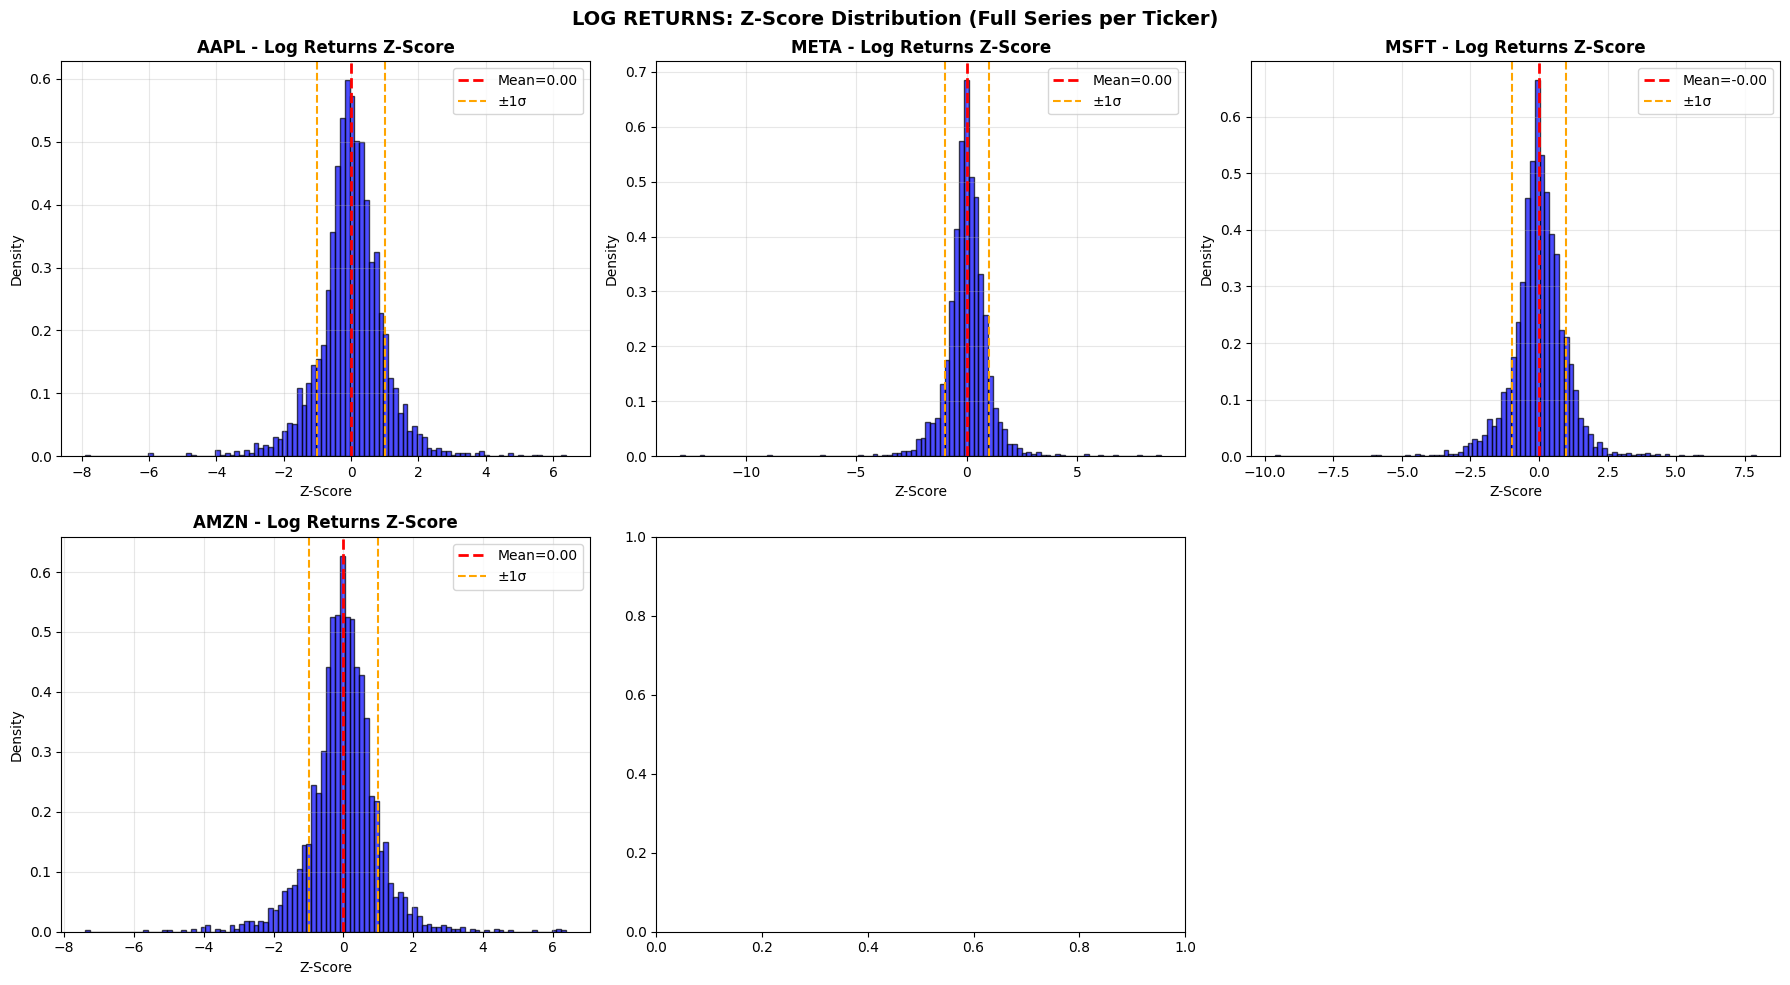

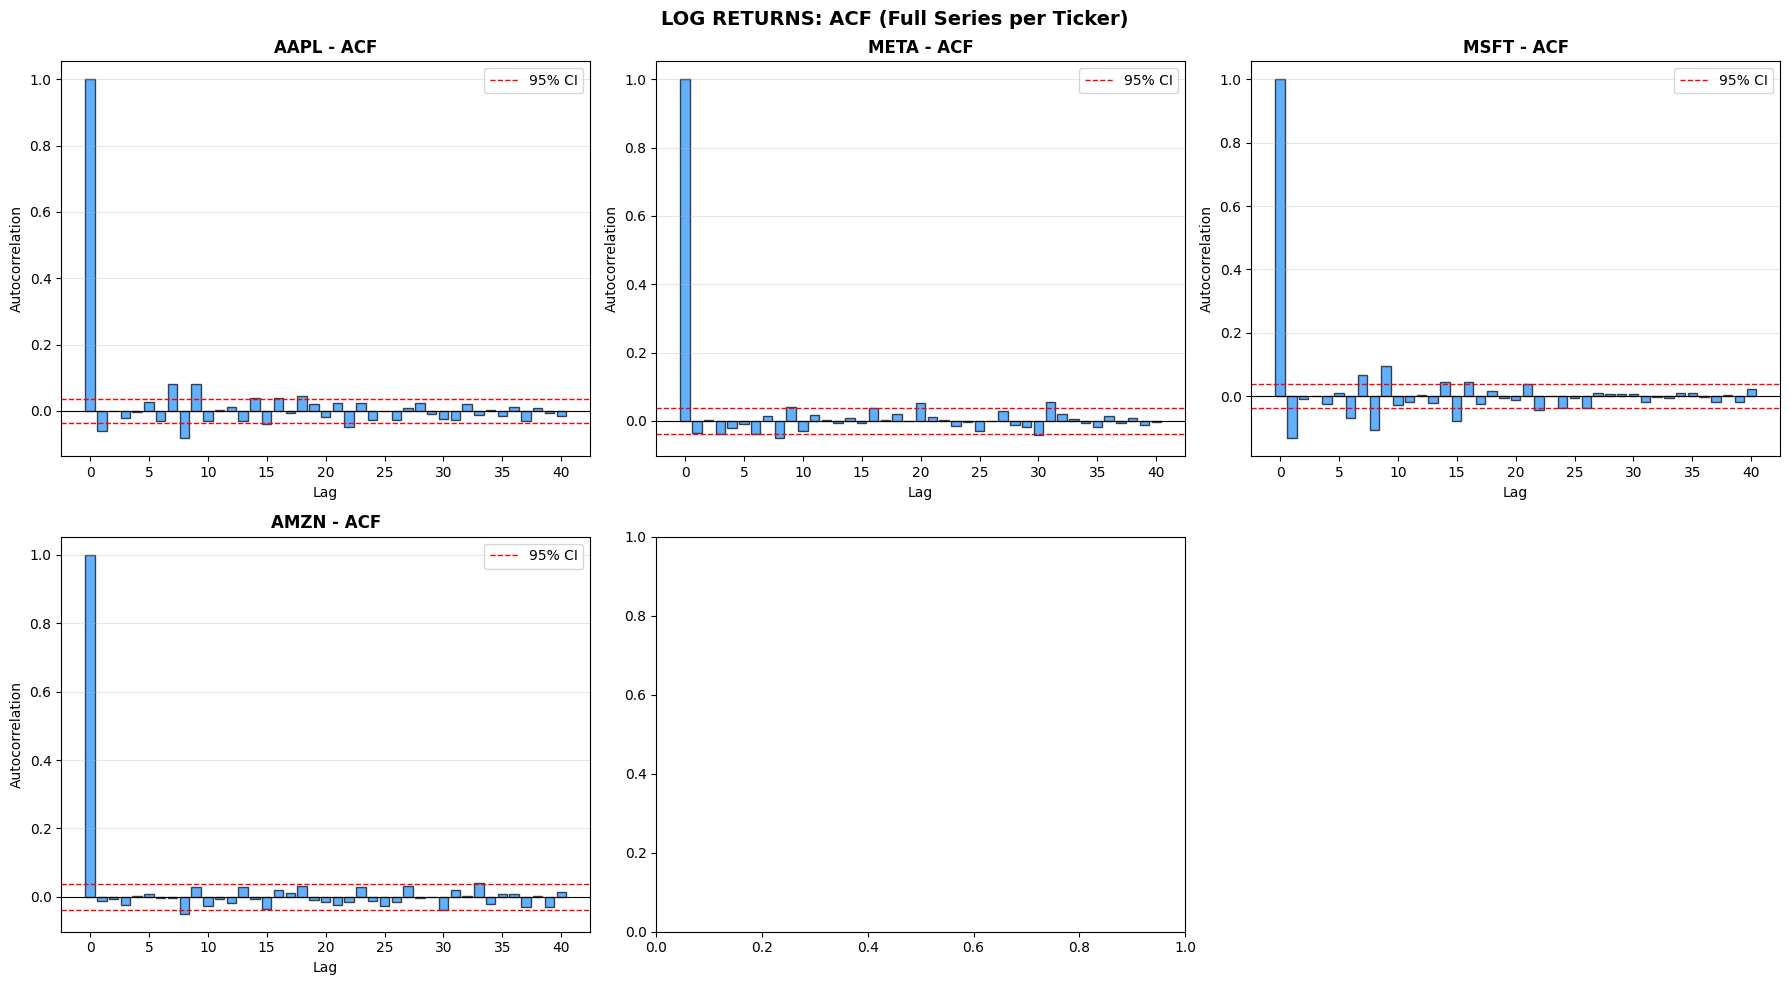


COMBINED ANALYSIS: AVERAGE ACF + POOLED DISTRIBUTION
Combined dataset statistics (POOLED):
  Total length: 11064
  Mean: 0.000000
  Std: 1.000000
  Min: -12.961465
  Max: 8.793287

Calculating average ACF (mean of 4 ticker ACFs)...


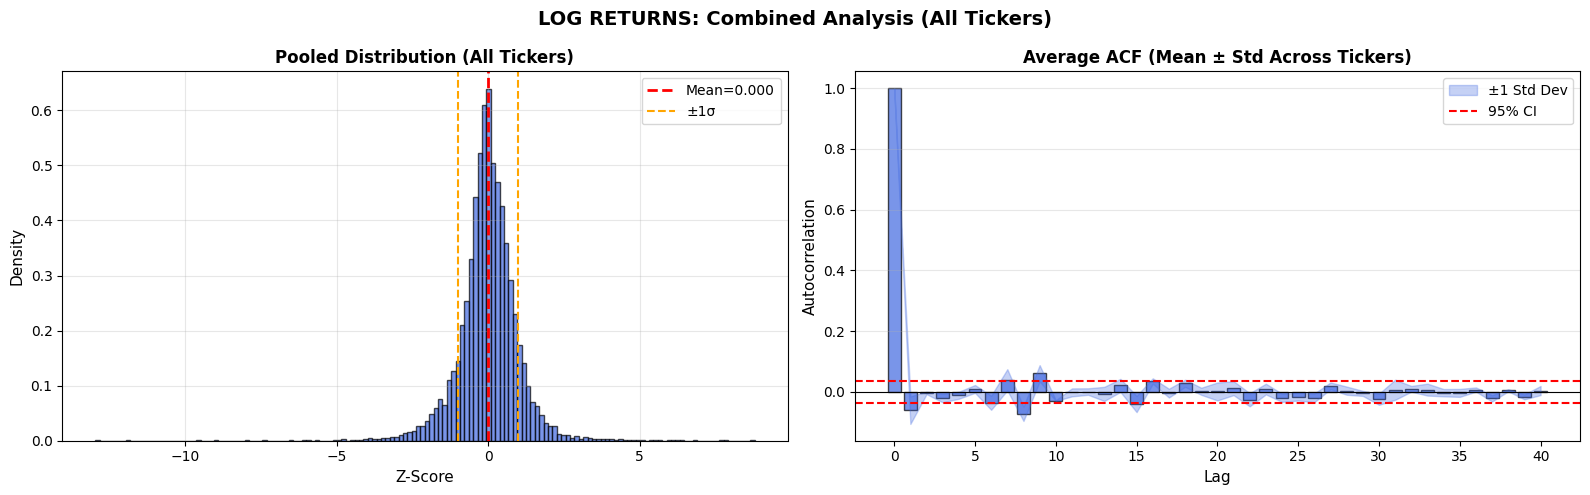


Average ACF (first 10 lags):
  Lag  0:  1.0000 (±0.0000)
  Lag  1: -0.0600 (±0.0454)
  Lag  2: -0.0034 (±0.0040)
  Lag  3: -0.0201 (±0.0142)
  Lag  4: -0.0111 (±0.0115)
  Lag  5:  0.0098 (±0.0129)
  Lag  6: -0.0357 (±0.0232)
  Lag  7:  0.0400 (±0.0349)
  Lag  8: -0.0720 (±0.0235)
  Lag  9:  0.0613 (±0.0267)


In [5]:
# Visualization of distributions and ACF for LOG RETURNS
# IMPORTANT: Analysis uses full series per ticker (NOT windowed data)
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("LOG RETURNS ANALYSIS: USING FULL TIME SERIES PER TICKER (NOT WINDOWED)")
print("="*80)

# 1. Visualize z-score distributions for each ticker - LOG RETURNS
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
fig.suptitle('LOG RETURNS: Z-Score Distribution (Full Series per Ticker)', fontsize=14, fontweight='bold')

for idx, ticker in enumerate(tickers):
    # Get FULL z-score normalized log returns series (not windows)
    series_zscore = ticker_zscore_log_returns[ticker]
    
    # Plot distribution
    axes[idx].hist(series_zscore, bins=100, color='blue', edgecolor='black', alpha=0.7, density=True)
    axes[idx].set_title(f'{ticker} - Log Returns Z-Score', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Z-Score', fontsize=10)
    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    
    mean_val = series_zscore.mean()
    std_val = series_zscore.std()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_val:.2f}')
    axes[idx].axvline(mean_val + std_val, color='orange', linestyle='--', linewidth=1.5, label=f'±1σ')
    axes[idx].axvline(mean_val - std_val, color='orange', linestyle='--', linewidth=1.5)
    axes[idx].legend()
    
    print(f"{ticker}: Mean={mean_val:.6f}, Std={std_val:.6f}, Length={len(series_zscore)}")

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# 2. Calculate and plot ACF for each ticker - LOG RETURNS
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
fig.suptitle('LOG RETURNS: ACF (Full Series per Ticker)', fontsize=14, fontweight='bold')

for idx, ticker in enumerate(tickers):
    # Get FULL z-score normalized log returns series (not windows)
    series_zscore = ticker_zscore_log_returns[ticker]
    
    # Calculate ACF on full series
    acf_values = acf(series_zscore, nlags=40, fft=True)
    
    # Plot ACF
    axes[idx].bar(range(len(acf_values)), acf_values, width=0.8, color='dodgerblue', edgecolor='black', alpha=0.7)
    axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[idx].axhline(y=1.96/np.sqrt(len(series_zscore)), color='red', linestyle='--', linewidth=1, label='95% CI')
    axes[idx].axhline(y=-1.96/np.sqrt(len(series_zscore)), color='red', linestyle='--', linewidth=1)
    axes[idx].set_title(f'{ticker} - ACF', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Lag', fontsize=10)
    axes[idx].set_ylabel('Autocorrelation', fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].legend()

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# 3. Combined analysis: AVERAGE ACF and proper distribution
print("\n" + "="*80)
print("COMBINED ANALYSIS: AVERAGE ACF + POOLED DISTRIBUTION")
print("="*80)

# 3a. Pooled distribution (all data combined)
all_returns_series_combined = np.concatenate([ticker_zscore_log_returns[ticker] for ticker in tickers])

print(f"Combined dataset statistics (POOLED):")
print(f"  Total length: {len(all_returns_series_combined)}")
print(f"  Mean: {all_returns_series_combined.mean():.6f}")
print(f"  Std: {all_returns_series_combined.std():.6f}")
print(f"  Min: {all_returns_series_combined.min():.6f}")
print(f"  Max: {all_returns_series_combined.max():.6f}")

# Plot combined distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('LOG RETURNS: Combined Analysis (All Tickers)', fontsize=14, fontweight='bold')

# Distribution
axes[0].hist(all_returns_series_combined, bins=150, color='royalblue', edgecolor='black', alpha=0.7, density=True)
axes[0].set_title('Pooled Distribution (All Tickers)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Z-Score', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
mean_all = all_returns_series_combined.mean()
std_all = all_returns_series_combined.std()
axes[0].axvline(mean_all, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_all:.3f}')
axes[0].axvline(mean_all + std_all, color='orange', linestyle='--', linewidth=1.5, label=f'±1σ')
axes[0].axvline(mean_all - std_all, color='orange', linestyle='--', linewidth=1.5)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 3b. Average ACF (mean of individual ACFs)
print(f"\nCalculating average ACF (mean of {len(tickers)} ticker ACFs)...")
acf_list = []
for ticker in tickers:
    series_zscore = ticker_zscore_log_returns[ticker]
    acf_values = acf(series_zscore, nlags=40, fft=True)
    acf_list.append(acf_values)

acf_average = np.mean(acf_list, axis=0)
acf_std = np.std(acf_list, axis=0)

# Plot average ACF
axes[1].bar(range(len(acf_average)), acf_average, width=0.8, color='royalblue', edgecolor='black', alpha=0.7)
# Add uncertainty band (±1 std)
axes[1].fill_between(range(len(acf_average)), 
                      acf_average - acf_std, 
                      acf_average + acf_std, 
                      alpha=0.3, color='royalblue', label='±1 Std Dev')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].axhline(y=1.96/np.sqrt(np.mean([len(ticker_zscore_log_returns[t]) for t in tickers])), 
                color='red', linestyle='--', linewidth=1.5, label='95% CI')
axes[1].axhline(y=-1.96/np.sqrt(np.mean([len(ticker_zscore_log_returns[t]) for t in tickers])), 
                color='red', linestyle='--', linewidth=1.5)
axes[1].set_title('Average ACF (Mean ± Std Across Tickers)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=11)
axes[1].set_ylabel('Autocorrelation', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nAverage ACF (first 10 lags):")
for lag in range(min(10, len(acf_average))):
    print(f"  Lag {lag:2d}: {acf_average[lag]:7.4f} (±{acf_std[lag]:.4f})")


VOLATILITY ANALYSIS: USING FULL TIME SERIES PER TICKER (NOT WINDOWED)
AAPL: Mean=-0.000000, Std=1.000000, Length=2766
META: Mean=-0.000000, Std=1.000000, Length=2766
MSFT: Mean=0.000000, Std=1.000000, Length=2766
AMZN: Mean=0.000000, Std=1.000000, Length=2766
AAPL: Mean=-0.000000, Std=1.000000, Length=2766
META: Mean=-0.000000, Std=1.000000, Length=2766
MSFT: Mean=0.000000, Std=1.000000, Length=2766
AMZN: Mean=0.000000, Std=1.000000, Length=2766


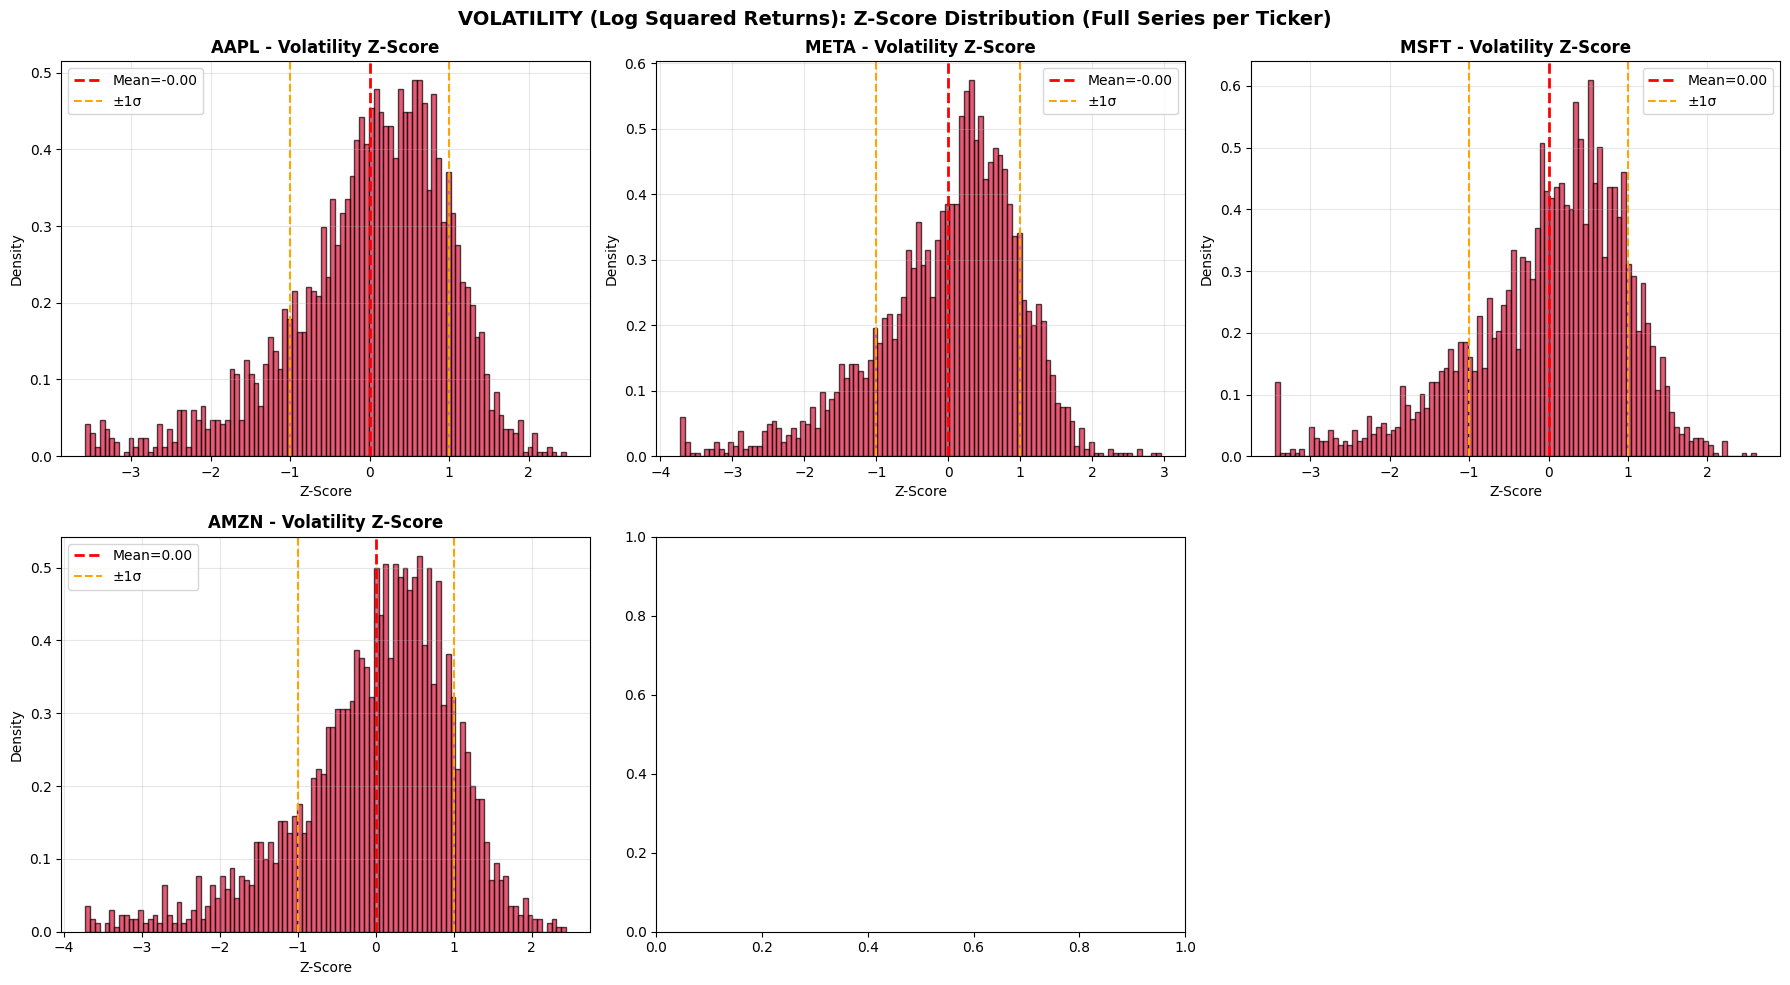

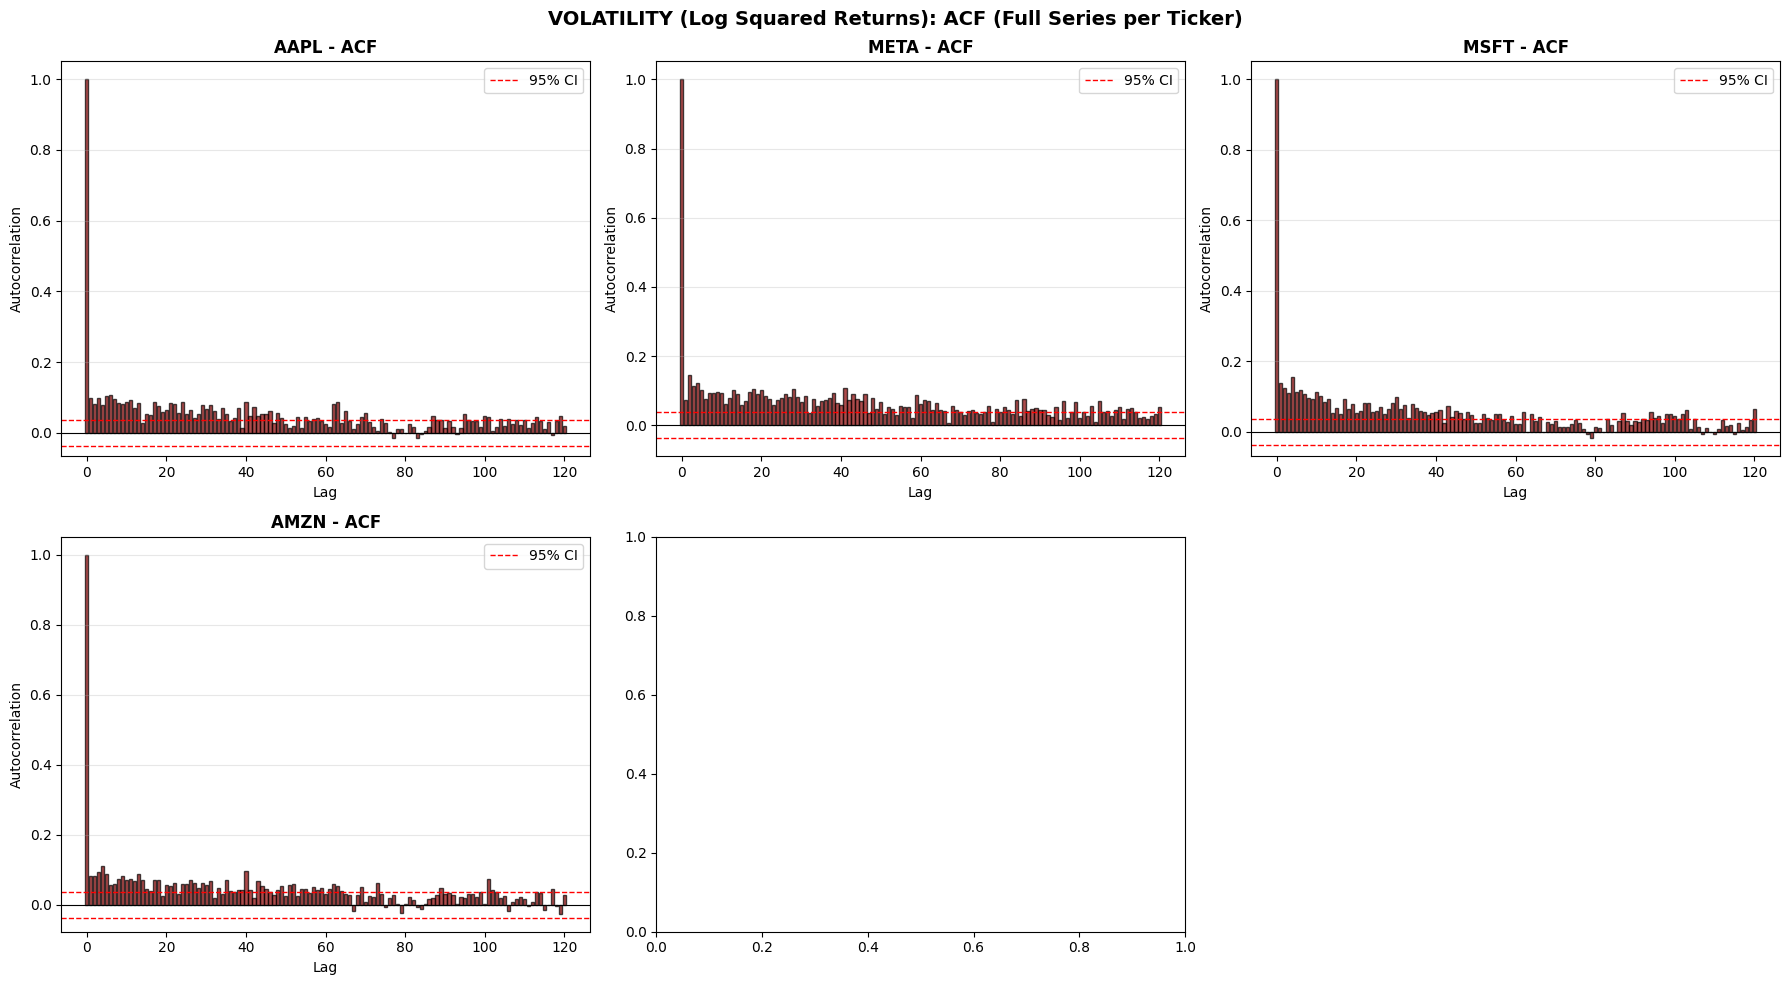


COMBINED ANALYSIS: AVERAGE ACF + POOLED DISTRIBUTION
Combined dataset statistics (POOLED):
  Total length: 11064
  Mean: 0.000000
  Std: 1.000000
  Min: -3.722667
  Max: 2.953057

Calculating average ACF (mean of 4 ticker ACFs)...

Calculating average ACF (mean of 4 ticker ACFs)...


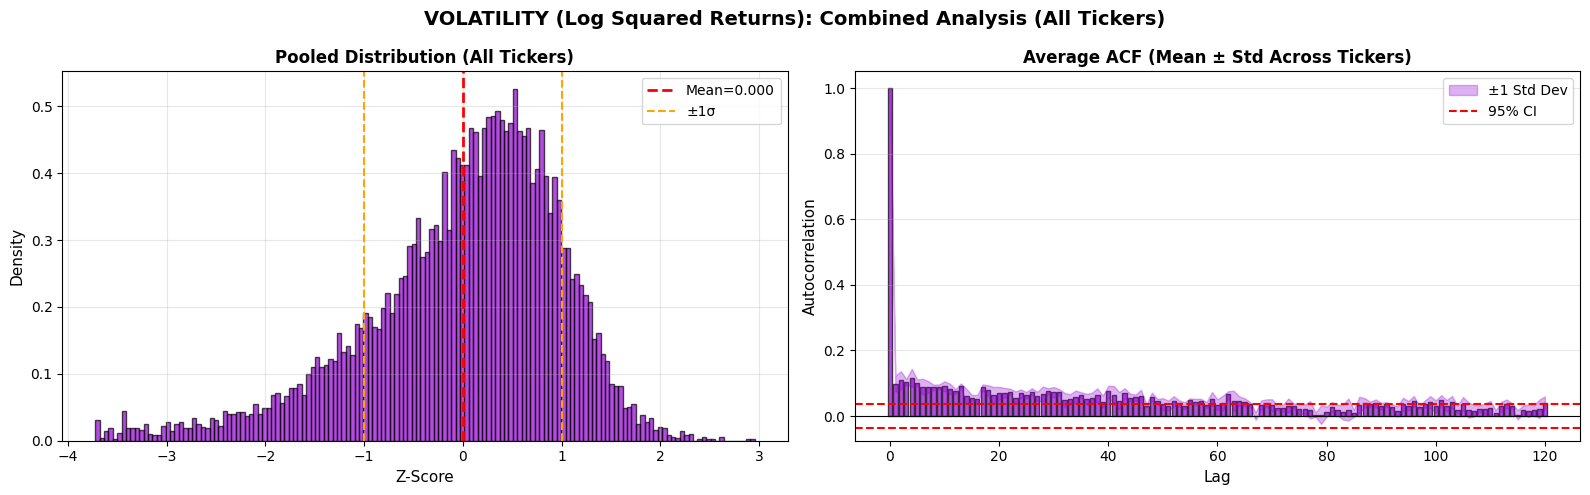


Average ACF (first 10 lags):
  Lag  0:  1.0000 (±0.0000)
  Lag  1:  0.0988 (±0.0244)
  Lag  2:  0.1088 (±0.0276)
  Lag  3:  0.1044 (±0.0087)
  Lag  4:  0.1165 (±0.0274)
  Lag  5:  0.1019 (±0.0097)
  Lag  6:  0.0895 (±0.0243)
  Lag  7:  0.0886 (±0.0179)
  Lag  8:  0.0871 (±0.0084)
  Lag  9:  0.0891 (±0.0071)


In [6]:
# Visualization of distributions and ACF for VOLATILITY (log-transformed squared returns)
# IMPORTANT: Analysis uses full series per ticker (NOT windowed data)
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("VOLATILITY ANALYSIS: USING FULL TIME SERIES PER TICKER (NOT WINDOWED)")
print("="*80)

# 1. Visualize z-score distributions for each ticker - VOLATILITY
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
fig.suptitle('VOLATILITY (Log Squared Returns): Z-Score Distribution (Full Series per Ticker)', fontsize=14, fontweight='bold')

for idx, ticker in enumerate(tickers):
    # Get FULL z-score normalized volatility series (not windows)
    series_zscore = ticker_zscore_volatility[ticker]
    
    # Plot distribution
    axes[idx].hist(series_zscore, bins=100, color='crimson', edgecolor='black', alpha=0.7, density=True)
    axes[idx].set_title(f'{ticker} - Volatility Z-Score', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Z-Score', fontsize=10)
    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    
    mean_val = series_zscore.mean()
    std_val = series_zscore.std()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_val:.2f}')
    axes[idx].axvline(mean_val + std_val, color='orange', linestyle='--', linewidth=1.5, label=f'±1σ')
    axes[idx].axvline(mean_val - std_val, color='orange', linestyle='--', linewidth=1.5)
    axes[idx].legend()
    
    print(f"{ticker}: Mean={mean_val:.6f}, Std={std_val:.6f}, Length={len(series_zscore)}")

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# 2. Calculate and plot ACF for each ticker - VOLATILITY
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
fig.suptitle('VOLATILITY (Log Squared Returns): ACF (Full Series per Ticker)', fontsize=14, fontweight='bold')

for idx, ticker in enumerate(tickers):
    # Get FULL z-score normalized volatility series (not windows)
    series_zscore = ticker_zscore_volatility[ticker]
    
    # Calculate ACF on full series
    acf_values = acf(series_zscore, nlags=120, fft=True)
    
    # Plot ACF
    axes[idx].bar(range(len(acf_values)), acf_values, width=0.8, color='darkred', edgecolor='black', alpha=0.7)
    axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[idx].axhline(y=1.96/np.sqrt(len(series_zscore)), color='red', linestyle='--', linewidth=1, label='95% CI')
    axes[idx].axhline(y=-1.96/np.sqrt(len(series_zscore)), color='red', linestyle='--', linewidth=1)
    axes[idx].set_title(f'{ticker} - ACF', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Lag', fontsize=10)
    axes[idx].set_ylabel('Autocorrelation', fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].legend()

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# 3. Combined analysis: AVERAGE ACF and proper distribution
print("\n" + "="*80)
print("COMBINED ANALYSIS: AVERAGE ACF + POOLED DISTRIBUTION")
print("="*80)

# 3a. Pooled distribution (all data combined)
all_volatility_series_combined = np.concatenate([ticker_zscore_volatility[ticker] for ticker in tickers])

print(f"Combined dataset statistics (POOLED):")
print(f"  Total length: {len(all_volatility_series_combined)}")
print(f"  Mean: {all_volatility_series_combined.mean():.6f}")
print(f"  Std: {all_volatility_series_combined.std():.6f}")
print(f"  Min: {all_volatility_series_combined.min():.6f}")
print(f"  Max: {all_volatility_series_combined.max():.6f}")

# Plot combined distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('VOLATILITY (Log Squared Returns): Combined Analysis (All Tickers)', fontsize=14, fontweight='bold')

# Distribution
axes[0].hist(all_volatility_series_combined, bins=150, color='darkviolet', edgecolor='black', alpha=0.7, density=True)
axes[0].set_title('Pooled Distribution (All Tickers)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Z-Score', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
mean_all = all_volatility_series_combined.mean()
std_all = all_volatility_series_combined.std()
axes[0].axvline(mean_all, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_all:.3f}')
axes[0].axvline(mean_all + std_all, color='orange', linestyle='--', linewidth=1.5, label=f'±1σ')
axes[0].axvline(mean_all - std_all, color='orange', linestyle='--', linewidth=1.5)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 3b. Average ACF (mean of individual ACFs)
print(f"\nCalculating average ACF (mean of {len(tickers)} ticker ACFs)...")
acf_list = []
for ticker in tickers:
    series_zscore = ticker_zscore_volatility[ticker]
    acf_values = acf(series_zscore, nlags=120, fft=True)
    acf_list.append(acf_values)

acf_average = np.mean(acf_list, axis=0)
acf_std = np.std(acf_list, axis=0)

# Plot average ACF
axes[1].bar(range(len(acf_average)), acf_average, width=0.8, color='darkviolet', edgecolor='black', alpha=0.7)
# Add uncertainty band (±1 std)
axes[1].fill_between(range(len(acf_average)), 
                      acf_average - acf_std, 
                      acf_average + acf_std, 
                      alpha=0.3, color='darkviolet', label='±1 Std Dev')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].axhline(y=1.96/np.sqrt(np.mean([len(ticker_zscore_volatility[t]) for t in tickers])), 
                color='red', linestyle='--', linewidth=1.5, label='95% CI')
axes[1].axhline(y=-1.96/np.sqrt(np.mean([len(ticker_zscore_volatility[t]) for t in tickers])), 
                color='red', linestyle='--', linewidth=1.5)
axes[1].set_title('Average ACF (Mean ± Std Across Tickers)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=11)
axes[1].set_ylabel('Autocorrelation', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nAverage ACF (first 10 lags):")
for lag in range(min(10, len(acf_average))):
    print(f"  Lag {lag:2d}: {acf_average[lag]:7.4f} (±{acf_std[lag]:.4f})")



=== CROSS-CORRELATION ANALYSIS ===

1. RAW DATA (log volume, log returns, squared returns)
----------------------------------------------------------------------

Correlation Matrix (Raw Data):
                   Volume  Log Returns   Volatility
Volume             1.0000      -0.0176       0.2105
Log Returns       -0.0176       1.0000       0.0231
Volatility         0.2105       0.0231       1.0000

Statistical Significance (Raw Data):
  Volume vs Log Returns:  r=-0.0176, p=0.000000 ***
  Volume vs Volatility:   r= 0.2105, p=0.000000 ***
  Returns vs Volatility:  r= 0.0231, p=0.000000 ***

2. Z-SCORE NORMALIZED DATA
----------------------------------------------------------------------

Correlation Matrix (Z-Score Normalized):
                   Volume  Log Returns   Volatility
Volume             1.0000      -0.0349       0.3988
Log Returns       -0.0349       1.0000       0.0252
Volatility         0.3988       0.0252       1.0000

Statistical Significance (Raw Data):
  Volume vs Log R

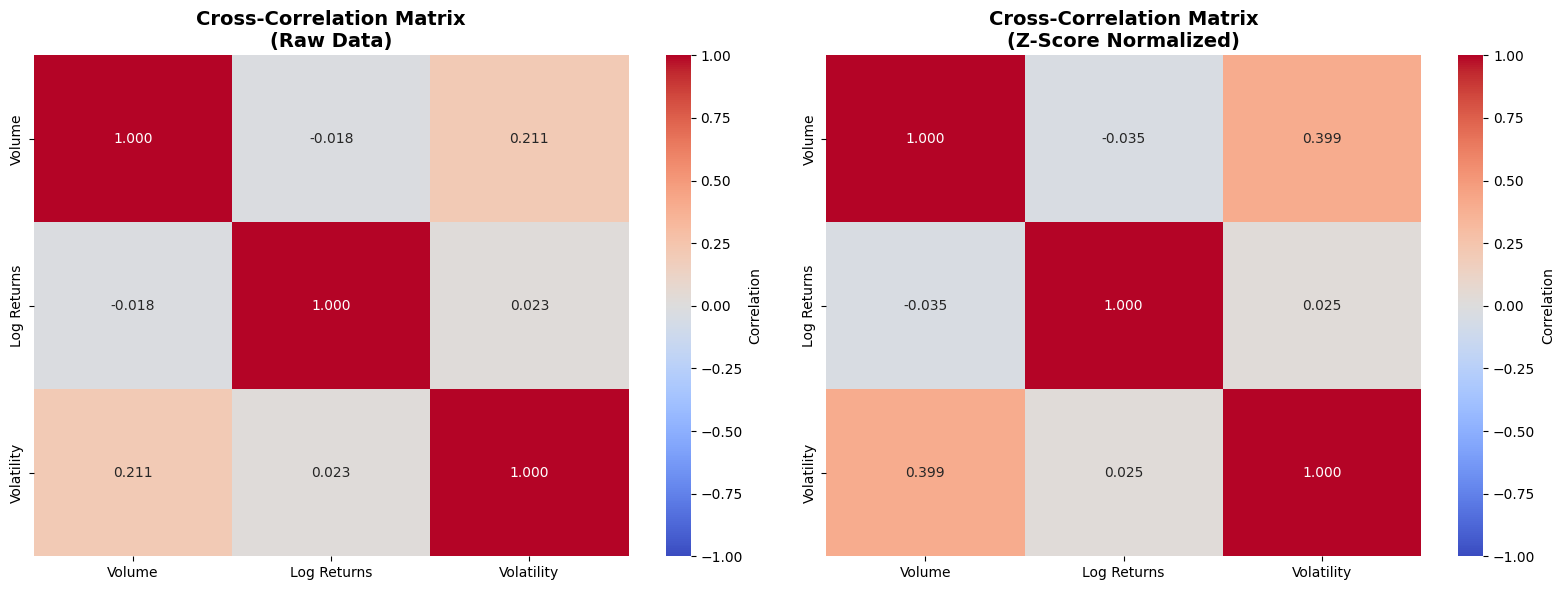

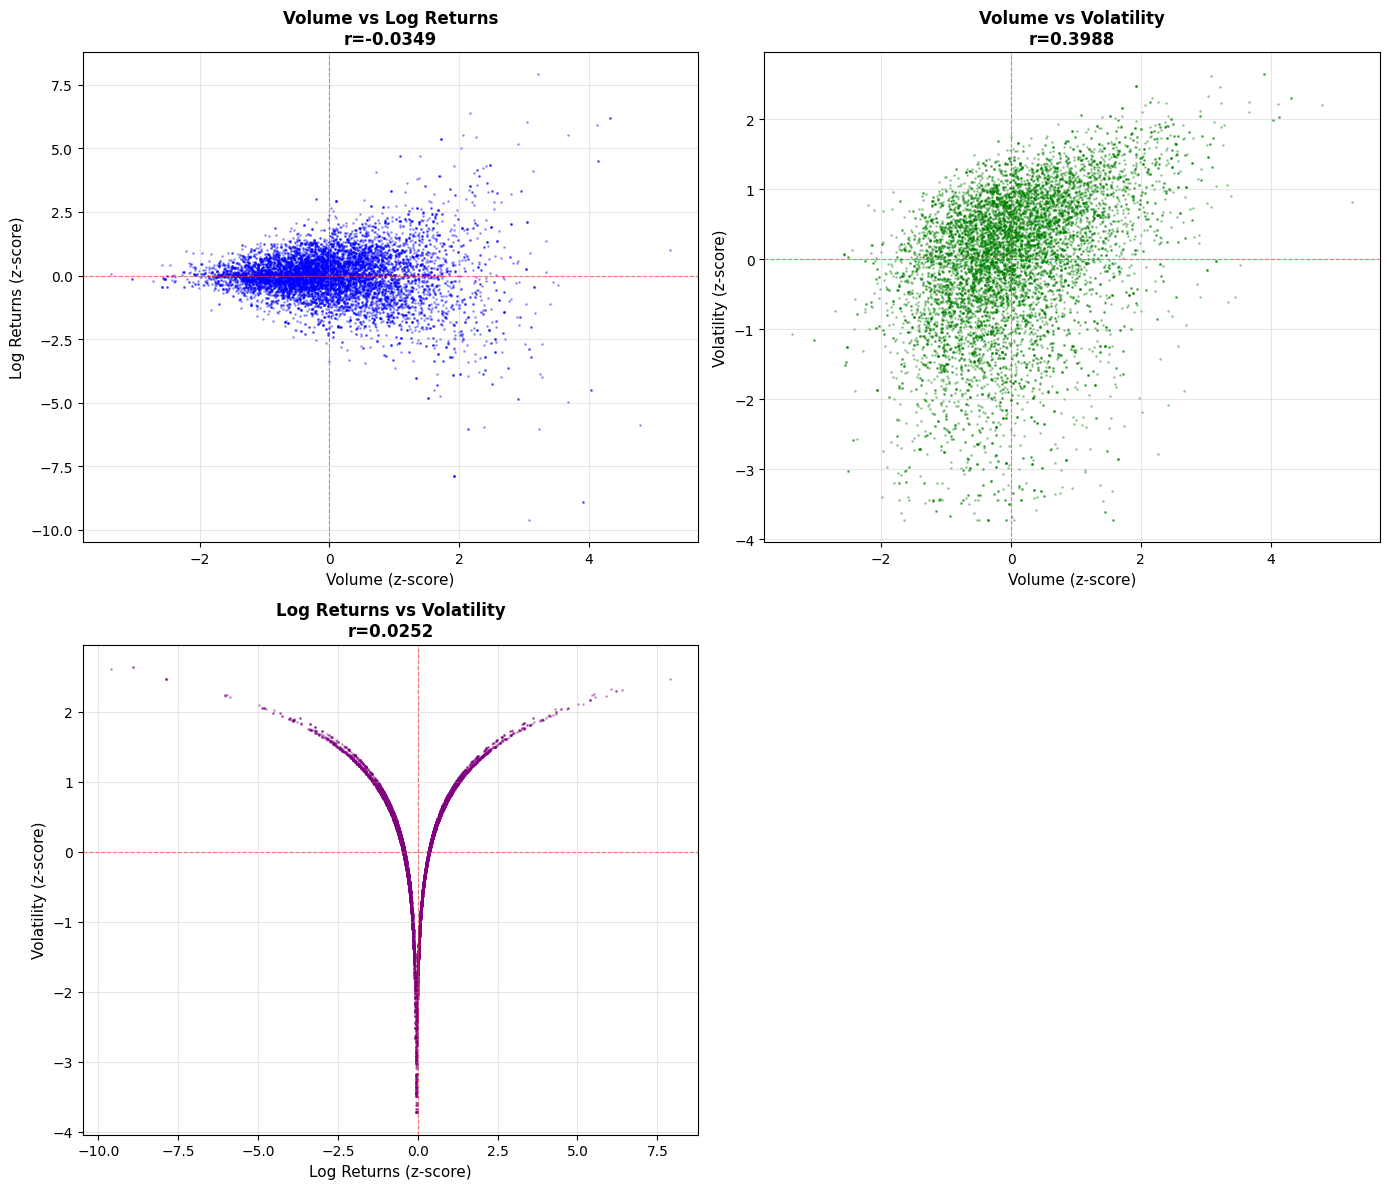


INTERPRETATION GUIDE
*** p<0.001 (highly significant)
**  p<0.01  (very significant)
*   p<0.05  (significant)
ns  p≥0.05  (not significant)

Note: Z-score normalization removes scale differences but preserves
      linear relationships between features.


In [7]:
# Cross-Correlation Analysis between Volume, Log Returns, and Volatility
# Analyzes both raw (non-normalized) and z-score normalized data

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

print("=== CROSS-CORRELATION ANALYSIS ===")

# ============================================================================
# PART 1: CROSS-CORRELATION FOR RAW (NON-ZSCORE) DATA
# ============================================================================

print("\n1. RAW DATA (log volume, log returns, squared returns)")
print("-" * 70)

# Flatten all windows for each feature (non-normalized)
volume_raw = volume_series.flatten()
returns_raw = log_returns_series.flatten()
volatility_raw = volatility_series.flatten()

# Compute correlation matrix
raw_features = np.column_stack([volume_raw, returns_raw, volatility_raw])
raw_corr_matrix = np.corrcoef(raw_features.T)

print(f"\nCorrelation Matrix (Raw Data):")
print(f"{'':12s} {'Volume':>12s} {'Log Returns':>12s} {'Volatility':>12s}")
print(f"{'Volume':<12s} {raw_corr_matrix[0,0]:12.4f} {raw_corr_matrix[0,1]:12.4f} {raw_corr_matrix[0,2]:12.4f}")
print(f"{'Log Returns':<12s} {raw_corr_matrix[1,0]:12.4f} {raw_corr_matrix[1,1]:12.4f} {raw_corr_matrix[1,2]:12.4f}")
print(f"{'Volatility':<12s} {raw_corr_matrix[2,0]:12.4f} {raw_corr_matrix[2,1]:12.4f} {raw_corr_matrix[2,2]:12.4f}")

# Statistical significance tests
corr_vol_ret, p_vol_ret = pearsonr(volume_raw, returns_raw)
corr_vol_vol, p_vol_vol = pearsonr(volume_raw, volatility_raw)
corr_ret_vol, p_ret_vol = pearsonr(returns_raw, volatility_raw)

print(f"\nStatistical Significance (Raw Data):")
print(f"  Volume vs Log Returns:  r={corr_vol_ret:7.4f}, p={p_vol_ret:.6f} {'***' if p_vol_ret < 0.001 else '**' if p_vol_ret < 0.01 else '*' if p_vol_ret < 0.05 else 'ns'}")
print(f"  Volume vs Volatility:   r={corr_vol_vol:7.4f}, p={p_vol_vol:.6f} {'***' if p_vol_vol < 0.001 else '**' if p_vol_vol < 0.01 else '*' if p_vol_vol < 0.05 else 'ns'}")
print(f"  Returns vs Volatility:  r={corr_ret_vol:7.4f}, p={p_ret_vol:.6f} {'***' if p_ret_vol < 0.001 else '**' if p_ret_vol < 0.01 else '*' if p_ret_vol < 0.05 else 'ns'}")

# ============================================================================
# PART 2: CROSS-CORRELATION FOR Z-SCORE NORMALIZED DATA
# ============================================================================

print("\n2. Z-SCORE NORMALIZED DATA")
print("-" * 70)

# Flatten all windows for each feature (z-score normalized)
volume_zscore = all_windows_combined_volumes.flatten()
returns_zscore = all_windows_combined_log_returns.flatten()
volatility_zscore = all_windows_combined_volatility.flatten()

# Compute correlation matrix
zscore_features = np.column_stack([volume_zscore, returns_zscore, volatility_zscore])
zscore_corr_matrix = np.corrcoef(zscore_features.T)

print(f"\nCorrelation Matrix (Z-Score Normalized):")
print(f"{'':12s} {'Volume':>12s} {'Log Returns':>12s} {'Volatility':>12s}")
print(f"{'Volume':<12s} {zscore_corr_matrix[0,0]:12.4f} {zscore_corr_matrix[0,1]:12.4f} {zscore_corr_matrix[0,2]:12.4f}")
print(f"{'Log Returns':<12s} {zscore_corr_matrix[1,0]:12.4f} {zscore_corr_matrix[1,1]:12.4f} {zscore_corr_matrix[1,2]:12.4f}")
print(f"{'Volatility':<12s} {zscore_corr_matrix[2,0]:12.4f} {zscore_corr_matrix[2,1]:12.4f} {zscore_corr_matrix[2,2]:12.4f}")

# Statistical significance tests
corr_vol_ret_z, p_vol_ret_z = pearsonr(volume_zscore, returns_zscore)
corr_vol_vol_z, p_vol_vol_z = pearsonr(volume_zscore, volatility_zscore)
corr_ret_vol_z, p_ret_vol_z = pearsonr(returns_zscore, volatility_zscore)

print(f"\nStatistical Significance (Z-Score Data):")
print(f"  Volume vs Log Returns:  r={corr_vol_ret_z:7.4f}, p={p_vol_ret_z:.6f} {'***' if p_vol_ret_z < 0.001 else '**' if p_vol_ret_z < 0.01 else '*' if p_vol_ret_z < 0.05 else 'ns'}")
print(f"  Volume vs Volatility:   r={corr_vol_vol_z:7.4f}, p={p_vol_vol_z:.6f} {'***' if p_vol_vol_z < 0.001 else '**' if p_vol_vol_z < 0.01 else '*' if p_vol_vol_z < 0.05 else 'ns'}")
print(f"  Returns vs Volatility:  r={corr_ret_vol_z:7.4f}, p={p_ret_vol_z:.6f} {'***' if p_ret_vol_z < 0.001 else '**' if p_ret_vol_z < 0.01 else '*' if p_ret_vol_z < 0.05 else 'ns'}")

# ============================================================================
# PART 3: VISUALIZATIONS
# ============================================================================

# Create heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for raw data
sns.heatmap(raw_corr_matrix, 
            annot=True, 
            fmt='.3f', 
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            xticklabels=['Volume', 'Log Returns', 'Volatility'],
            yticklabels=['Volume', 'Log Returns', 'Volatility'],
            ax=axes[0],
            cbar_kws={'label': 'Correlation'})
axes[0].set_title('Cross-Correlation Matrix\n(Raw Data)', fontsize=14, fontweight='bold')

# Heatmap for z-score normalized data
sns.heatmap(zscore_corr_matrix, 
            annot=True, 
            fmt='.3f', 
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            xticklabels=['Volume', 'Log Returns', 'Volatility'],
            yticklabels=['Volume', 'Log Returns', 'Volatility'],
            ax=axes[1],
            cbar_kws={'label': 'Correlation'})
axes[1].set_title('Cross-Correlation Matrix\n(Z-Score Normalized)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Scatter plot matrix for z-score data (more interpretable)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Sample subset for visualization (to avoid overplotting)
n_samples = min(10000, len(volume_zscore))
sample_indices = np.random.choice(len(volume_zscore), size=n_samples, replace=False)

vol_sample = volume_zscore[sample_indices]
ret_sample = returns_zscore[sample_indices]
vola_sample = volatility_zscore[sample_indices]

# Volume vs Log Returns
axes[0, 0].scatter(vol_sample, ret_sample, alpha=0.3, s=1, c='blue')
axes[0, 0].set_xlabel('Volume (z-score)', fontsize=11)
axes[0, 0].set_ylabel('Log Returns (z-score)', fontsize=11)
axes[0, 0].set_title(f'Volume vs Log Returns\nr={corr_vol_ret_z:.4f}', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)

# Volume vs Volatility
axes[0, 1].scatter(vol_sample, vola_sample, alpha=0.3, s=1, c='green')
axes[0, 1].set_xlabel('Volume (z-score)', fontsize=11)
axes[0, 1].set_ylabel('Volatility (z-score)', fontsize=11)
axes[0, 1].set_title(f'Volume vs Volatility\nr={corr_vol_vol_z:.4f}', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)

# Log Returns vs Volatility
axes[1, 0].scatter(ret_sample, vola_sample, alpha=0.3, s=1, c='purple')
axes[1, 0].set_xlabel('Log Returns (z-score)', fontsize=11)
axes[1, 0].set_ylabel('Volatility (z-score)', fontsize=11)
axes[1, 0].set_title(f'Log Returns vs Volatility\nr={corr_ret_vol_z:.4f}', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)

# Hide unused subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("INTERPRETATION GUIDE")
print("="*70)
print("*** p<0.001 (highly significant)")
print("**  p<0.01  (very significant)")
print("*   p<0.05  (significant)")
print("ns  p≥0.05  (not significant)")
print("\nNote: Z-score normalization removes scale differences but preserves")
print("      linear relationships between features.")
print("="*70)

=== WAVELET TRANSFORM PROCESSING (SWT) - 3 CHANNELS (RGB) ===
Volume data shape: (10044, 256, 1)
Log Returns data shape: (10044, 256, 1)
Volatility data shape: (10044, 256, 1)
Window length: 256

Wavelet type: haar
Decomposition levels: 8
RGB Channel mapping:
  R (Red)   = Volume
  G (Green) = Log Returns
  B (Blue)  = Volatility

Processing Volume...
  Window 0/10044...
  Window 1000/10044...
  Window 2000/10044...
  Window 3000/10044...
  Window 4000/10044...
  Window 5000/10044...
  Window 3000/10044...
  Window 4000/10044...
  Window 5000/10044...
  Window 6000/10044...
  Window 7000/10044...
  Window 8000/10044...
  Window 6000/10044...
  Window 7000/10044...
  Window 8000/10044...
  Window 9000/10044...
  Window 10000/10044...
  Volume wavelet shape: (10044, 9, 256)
  Range: [-21.1086, 21.3344]

Processing Log Returns...
  Window 0/10044...
  Window 9000/10044...
  Window 10000/10044...
  Volume wavelet shape: (10044, 9, 256)
  Range: [-21.1086, 21.3344]

Processing Log Returns..

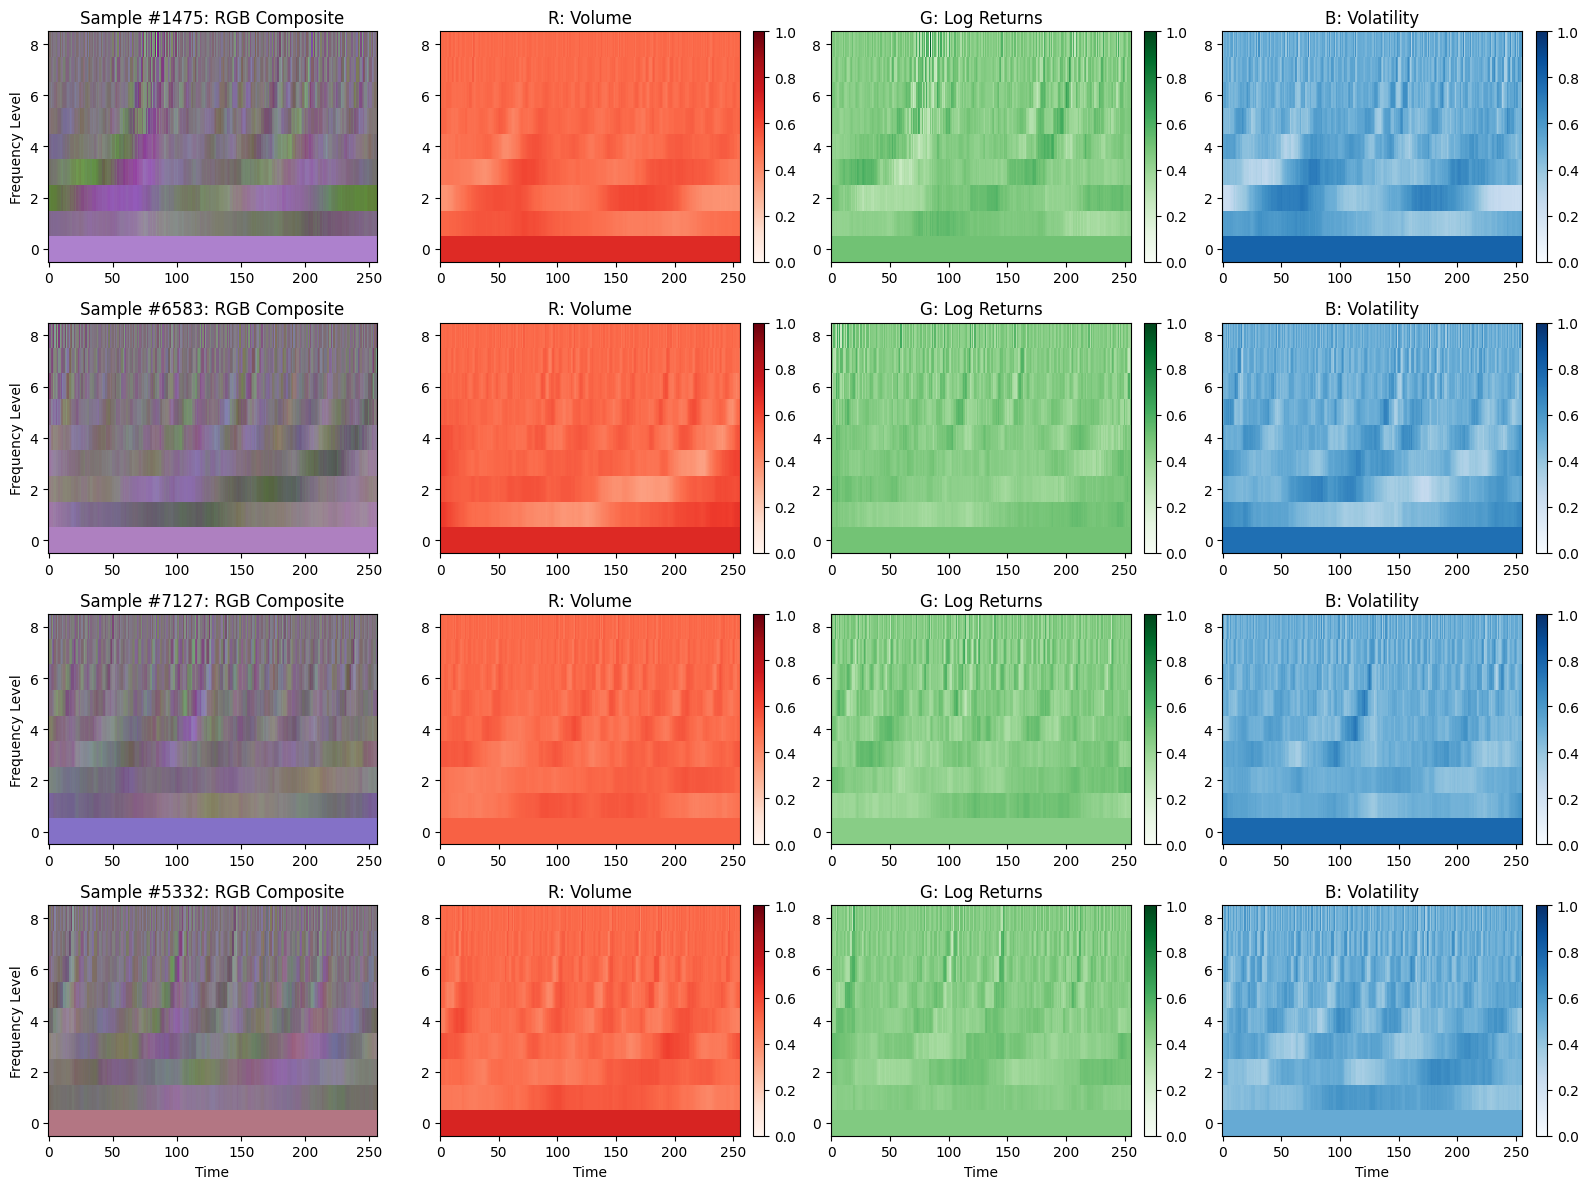


=== RGB WAVELET IMAGE STATISTICS ===
Total images: 10044
Image dimensions: 9x256x3 (H x W x C)

Per-channel statistics:
  Volume (R):
    Range: [0.0000, 1.0000]
    Mean: 0.4979
    Std: 0.0742
  Log Returns (G):
    Range: [0.0000, 1.0000]
    Mean: 0.4493
    Std: 0.0742
  Log Returns (G):
    Range: [0.0000, 1.0000]
    Mean: 0.4493
    Std: 0.0419
  Volatility (B):
    Range: [0.0000, 1.0000]
    Mean: 0.5000
    Std: 0.0419
  Volatility (B):
    Range: [0.0000, 1.0000]
    Mean: 0.5000
    Std: 0.0947

✓ RGB wavelet images ready for diffusion model training!
  - 3 channels: Volume (R), Log Returns (G), Volatility (B)
  - Each channel normalized independently using Min-Max scaling (NO CLIPPING)
  - All channels use same wavelet transform (SWT, Haar, level 8)
  - Images in [0, 1] range per channel
  - Normalization parameters saved for inverse transformation
    Std: 0.0947

✓ RGB wavelet images ready for diffusion model training!
  - 3 channels: Volume (R), Log Returns (G), Volat

In [8]:
# Convert z-score normalized time series windows to RGB wavelet images using Haar wavelets (SWT)
# Creates 3-channel wavelet coefficient images: R=Volume, G=Log Returns, B=Volatility
# Uses Stationary Wavelet Transform (SWT) which maintains same length across all levels

import pywt
import numpy as np
import matplotlib.pyplot as plt

print("=== WAVELET TRANSFORM PROCESSING (SWT) - 3 CHANNELS (RGB) ===")
print(f"Volume data shape: {all_windows_combined_volumes.shape}")
print(f"Log Returns data shape: {all_windows_combined_log_returns.shape}")
print(f"Volatility data shape: {all_windows_combined_volatility.shape}")
print(f"Window length: {WINDOW_LENGTH}")

# Configuration
wavelet_type = 'haar'
wavelet_level = int(np.log2(WINDOW_LENGTH))  # Maximum decomposition level for Haar

print(f"\nWavelet type: {wavelet_type}")
print(f"Decomposition levels: {wavelet_level}")
print(f"RGB Channel mapping:")
print(f"  R (Red)   = Volume")
print(f"  G (Green) = Log Returns")
print(f"  B (Blue)  = Volatility")

# ============================================================================
# PART 1: APPLY SWT TO ALL THREE FEATURES
# ============================================================================

def process_feature_to_wavelets(data, feature_name):
    """Apply SWT to a feature and return wavelet coefficients"""
    print(f"\nProcessing {feature_name}...")
    wavelet_coeffs_list = []
    
    for i in range(len(data)):
        if i % 1000 == 0:
            print(f"  Window {i}/{len(data)}...")
        
        # Get the time series window (already z-score normalized)
        ts = data[i]
        
        # Ensure it's 1D and correct type
        ts = np.ascontiguousarray(ts.flatten(), dtype=np.float64)
        
        # Apply Stationary Wavelet Transform (SWT) - KEEP ALL COEFFICIENTS
        coeffs = pywt.swt(ts, wavelet_type, level=wavelet_level, trim_approx=False)
        
        # Stack as: [cA_n, cD_n, cD_n-1, ..., cD_1]
        coeff_arrays = [coeffs[0][0]]  # Approximation coefficients
        for cA, cD in coeffs:
            coeff_arrays.append(cD)  # Detail coefficients
        
        # Stack all coefficients: (wavelet_level + 1, WINDOW_LENGTH)
        wavelet_image = np.array(coeff_arrays, dtype=np.float32)
        wavelet_coeffs_list.append(wavelet_image)
    
    # Stack all: (N, wavelet_level+1, WINDOW_LENGTH)
    wavelet_coeffs_array = np.array(wavelet_coeffs_list, dtype=np.float32)
    
    print(f"  {feature_name} wavelet shape: {wavelet_coeffs_array.shape}")
    print(f"  Range: [{wavelet_coeffs_array.min():.4f}, {wavelet_coeffs_array.max():.4f}]")
    
    return wavelet_coeffs_array

# Process each feature independently
wavelet_volume = process_feature_to_wavelets(all_windows_combined_volumes, "Volume")
wavelet_returns = process_feature_to_wavelets(all_windows_combined_log_returns, "Log Returns")
wavelet_volatility = process_feature_to_wavelets(all_windows_combined_volatility, "Volatility")

# ============================================================================
# PART 2: NORMALIZE EACH CHANNEL INDEPENDENTLY
# ============================================================================

print("\n" + "="*70)
print("NORMALIZING EACH CHANNEL INDEPENDENTLY (MIN-MAX SCALING)")
print("="*70)

def normalize_channel(coeffs, channel_name):
    """Normalize wavelet coefficients to [0, 1] using Min-Max scaling (NO CLIPPING)"""
    # Use absolute min/max to preserve full dynamic range (fat tails)
    min_val = coeffs.min()
    max_val = coeffs.max()
    
    print(f"\n{channel_name}:")
    print(f"  Min value: {min_val:.4f}")
    print(f"  Max value: {max_val:.4f}")
    
    eps = 1e-8
    # Simple Min-Max scaling
    coeffs_normalized = (coeffs - min_val) / (max_val - min_val + eps)
    
    print(f"  Normalized range: [{coeffs_normalized.min():.4f}, {coeffs_normalized.max():.4f}]")
    print(f"  Normalized mean: {coeffs_normalized.mean():.4f}")
    print(f"  Normalized std: {coeffs_normalized.std():.4f}")
    
    return coeffs_normalized, min_val, max_val

# Normalize each channel
volume_norm, vol_min, vol_max = normalize_channel(wavelet_volume, "R (Volume)")
returns_norm, ret_min, ret_max = normalize_channel(wavelet_returns, "G (Log Returns)")
volatility_norm, vol_vol_min, vol_vol_max = normalize_channel(wavelet_volatility, "B (Volatility)")

# ============================================================================
# PART 3: STACK INTO RGB IMAGE (N, H, W, 3)
# ============================================================================

print("\n" + "="*70)
print("STACKING INTO RGB WAVELET IMAGES")
print("="*70)

# Stack along channel dimension: (N, H, W, 3)
wavelet_images = np.stack([volume_norm, returns_norm, volatility_norm], axis=-1)

print(f"\nFinal RGB wavelet images shape: {wavelet_images.shape}")
print(f"  N (samples): {wavelet_images.shape[0]}")
print(f"  H (frequency levels): {wavelet_images.shape[1]} (1 approx + {wavelet_level} details)")
print(f"  W (time points): {wavelet_images.shape[2]}")
print(f"  C (channels): {wavelet_images.shape[3]} (RGB)")

# ============================================================================
# PART 4: SAVE WAVELET IMAGES AND NORMALIZATION PARAMETERS
# ============================================================================

np.save('wavelet_images.npy', wavelet_images)
print(f"\nSaved RGB wavelet images to 'wavelet_images.npy'")

# Save normalization parameters for ALL channels
wavelet_norm_params = {
    'wavelet_type': wavelet_type,
    'wavelet_level': wavelet_level,
    'window_length': WINDOW_LENGTH,
    'transform_type': 'swt',
    'trim_approx': False,
    'n_channels': 3,
    'channel_names': ['Volume', 'Log Returns', 'Volatility'],
    'normalization_type': 'min_max', # Flag to indicate new normalization
    # Channel 0: Volume (R)
    'volume_min': float(vol_min),
    'volume_max': float(vol_max),
    # Channel 1: Log Returns (G)
    'returns_min': float(ret_min),
    'returns_max': float(ret_max),
    # Channel 2: Volatility (B)
    'volatility_min': float(vol_vol_min),
    'volatility_max': float(vol_vol_max),
}
np.save('wavelet_normalization_params.npy', wavelet_norm_params)
print(f"Saved normalization parameters to 'wavelet_normalization_params.npy'")

# ============================================================================
# PART 5: VISUALIZE RGB WAVELET IMAGES
# ============================================================================

print("\n" + "="*70)
print("VISUALIZATION")
print("="*70)

num_samples_to_plot = min(4, len(wavelet_images))
fig, axes = plt.subplots(num_samples_to_plot, 4, figsize=(16, num_samples_to_plot*3))
if num_samples_to_plot == 1:
    axes = axes[np.newaxis, :]

# Randomly select indices
random_indices = np.random.choice(len(wavelet_images), size=num_samples_to_plot, replace=False)

for row_idx, rand_idx in enumerate(random_indices):
    img_rgb = wavelet_images[rand_idx]  # Shape: (H, W, 3)
    
    # RGB composite
    axes[row_idx, 0].imshow(img_rgb, aspect='auto', origin='lower', interpolation='nearest')
    axes[row_idx, 0].set_title(f'Sample #{rand_idx+1}: RGB Composite')
    axes[row_idx, 0].set_ylabel('Frequency Level')
    if row_idx == num_samples_to_plot - 1:
        axes[row_idx, 0].set_xlabel('Time')
    
    # R channel (Volume)
    im_r = axes[row_idx, 1].imshow(img_rgb[:, :, 0], aspect='auto', origin='lower', 
                                     cmap='Reds', vmin=0, vmax=1, interpolation='nearest')
    axes[row_idx, 1].set_title('R: Volume')
    plt.colorbar(im_r, ax=axes[row_idx, 1], fraction=0.046, pad=0.04)
    if row_idx == num_samples_to_plot - 1:
        axes[row_idx, 1].set_xlabel('Time')
    
    # G channel (Log Returns)
    im_g = axes[row_idx, 2].imshow(img_rgb[:, :, 1], aspect='auto', origin='lower', 
                                     cmap='Greens', vmin=0, vmax=1, interpolation='nearest')
    axes[row_idx, 2].set_title('G: Log Returns')
    plt.colorbar(im_g, ax=axes[row_idx, 2], fraction=0.046, pad=0.04)
    if row_idx == num_samples_to_plot - 1:
        axes[row_idx, 2].set_xlabel('Time')
    
    # B channel (Volatility)
    im_b = axes[row_idx, 3].imshow(img_rgb[:, :, 2], aspect='auto', origin='lower', 
                                     cmap='Blues', vmin=0, vmax=1, interpolation='nearest')
    axes[row_idx, 3].set_title('B: Volatility')
    plt.colorbar(im_b, ax=axes[row_idx, 3], fraction=0.046, pad=0.04)
    if row_idx == num_samples_to_plot - 1:
        axes[row_idx, 3].set_xlabel('Time')

plt.tight_layout()
plt.show()

# ============================================================================
# PART 6: STATISTICS
# ============================================================================

print(f"\n=== RGB WAVELET IMAGE STATISTICS ===")
print(f"Total images: {len(wavelet_images)}")
print(f"Image dimensions: {wavelet_images.shape[1]}x{wavelet_images.shape[2]}x{wavelet_images.shape[3]} (H x W x C)")
print(f"\nPer-channel statistics:")
for i, name in enumerate(['Volume (R)', 'Log Returns (G)', 'Volatility (B)']):
    channel = wavelet_images[:, :, :, i]
    print(f"  {name}:")
    print(f"    Range: [{channel.min():.4f}, {channel.max():.4f}]")
    print(f"    Mean: {channel.mean():.4f}")
    print(f"    Std: {channel.std():.4f}")

print(f"\n✓ RGB wavelet images ready for diffusion model training!")
print(f"  - 3 channels: Volume (R), Log Returns (G), Volatility (B)")
print(f"  - Each channel normalized independently using Min-Max scaling (NO CLIPPING)")
print(f"  - All channels use same wavelet transform (SWT, Haar, level {wavelet_level})")
print(f"  - Images in [0, 1] range per channel")
print(f"  - Normalization parameters saved for inverse transformation")

Loaded dataset with 10044 samples. Shape: torch.Size([10044, 3, 9, 256])
Resuming training from ./diffusion_checkpoints/ckpt_epoch_17.pt
Starting training on cuda...
Using Loss Type: frequency_weighted
Starting training on cuda...
Using Loss Type: frequency_weighted


Epoch 18/50: 100%|██████████| 314/314 [00:48<00:00,  6.51it/s, loss=0.0122] 



Epoch 18 Average Loss: 0.010801
  Generating preview for Epoch 18...
  Generating preview for Epoch 18...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

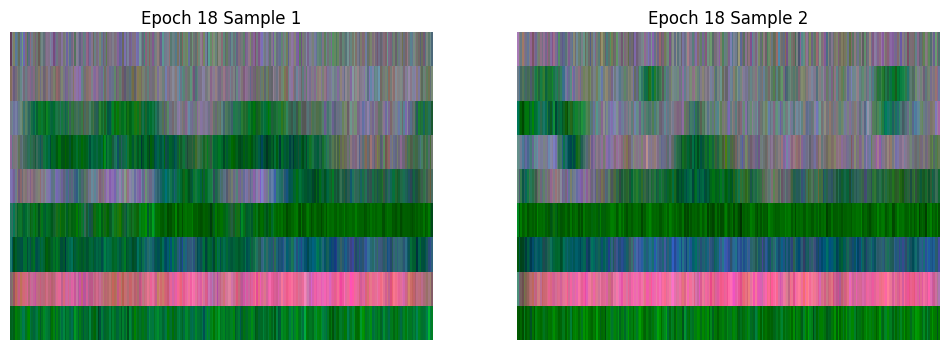

Epoch 19/50: 100%|██████████| 314/314 [00:48<00:00,  6.47it/s, loss=0.014]  



Epoch 19 Average Loss: 0.010804
  Generating preview for Epoch 19...
  Generating preview for Epoch 19...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

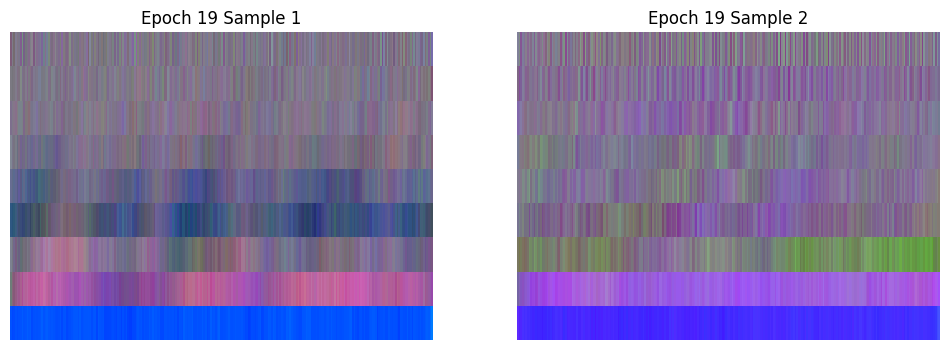

Epoch 20/50: 100%|██████████| 314/314 [00:49<00:00,  6.39it/s, loss=0.0108] 



Epoch 20 Average Loss: 0.010733
  Generating preview for Epoch 20...
  Generating preview for Epoch 20...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

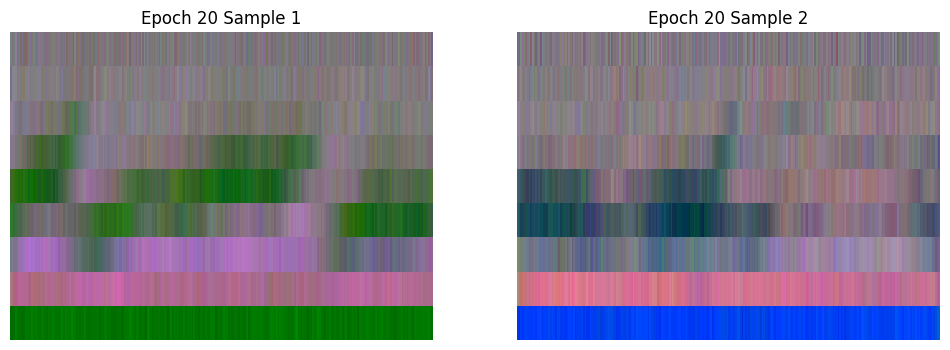

Epoch 21/50: 100%|██████████| 314/314 [00:48<00:00,  6.43it/s, loss=0.0128] 



Epoch 21 Average Loss: 0.010593
  Generating preview for Epoch 21...
  Generating preview for Epoch 21...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

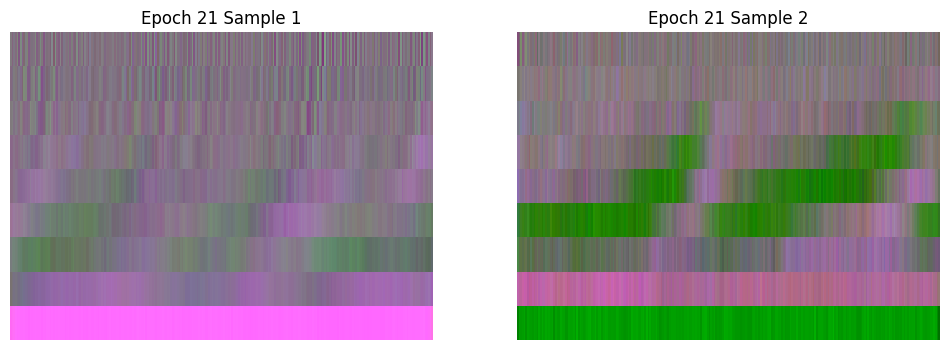

Epoch 22/50: 100%|██████████| 314/314 [00:50<00:00,  6.23it/s, loss=0.00679]



Epoch 22 Average Loss: 0.010542
  Generating preview for Epoch 22...
  Generating preview for Epoch 22...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

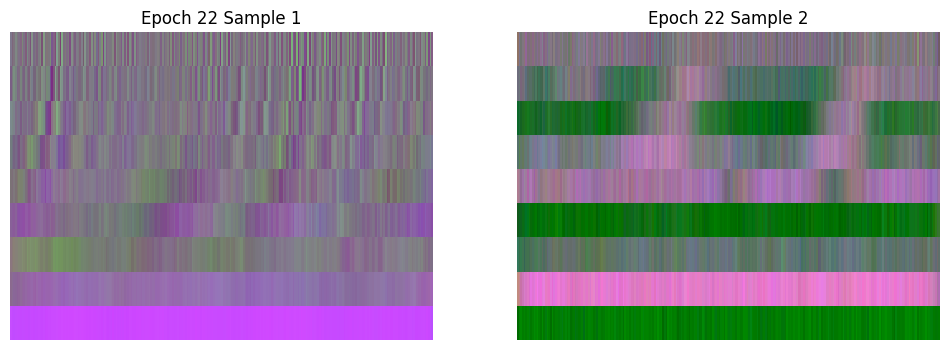

Epoch 23/50: 100%|██████████| 314/314 [00:48<00:00,  6.46it/s, loss=0.011]  



Epoch 23 Average Loss: 0.009970
  Generating preview for Epoch 23...
  Generating preview for Epoch 23...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

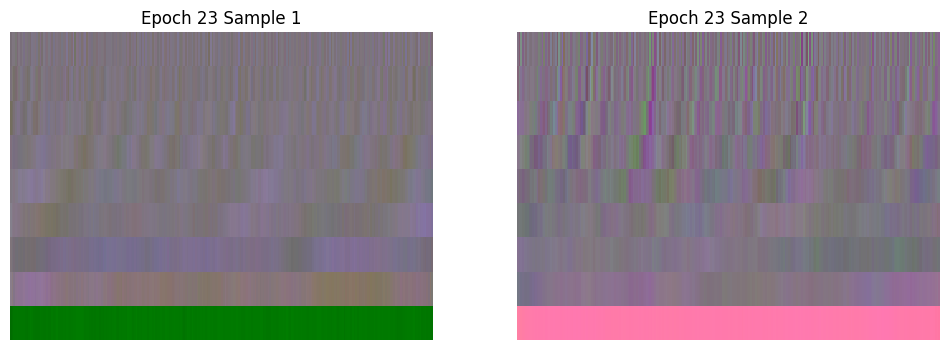

Epoch 24/50: 100%|██████████| 314/314 [00:49<00:00,  6.39it/s, loss=0.00955]



Epoch 24 Average Loss: 0.009764
  Generating preview for Epoch 24...
  Generating preview for Epoch 24...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

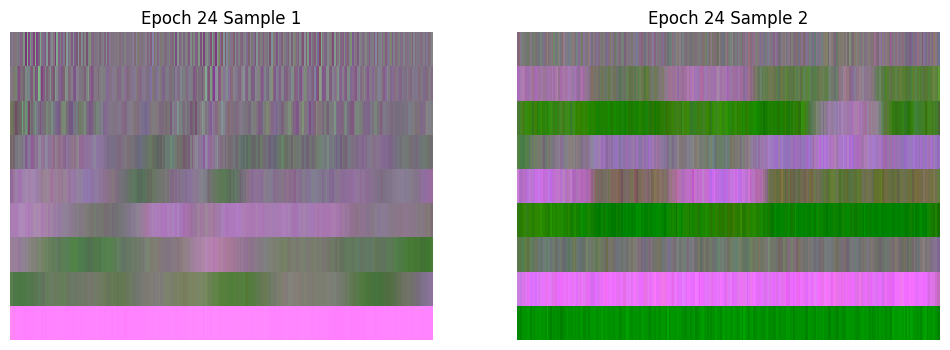

Epoch 25/50: 100%|██████████| 314/314 [00:49<00:00,  6.37it/s, loss=0.00867]



Epoch 25 Average Loss: 0.009618
  Generating preview for Epoch 25...
  Generating preview for Epoch 25...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

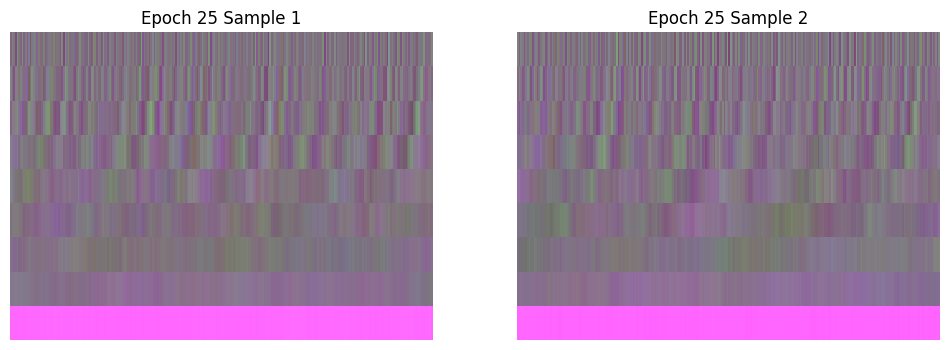

Epoch 26/50: 100%|██████████| 314/314 [00:49<00:00,  6.39it/s, loss=0.00813]



Epoch 26 Average Loss: 0.009536
  Generating preview for Epoch 26...
  Generating preview for Epoch 26...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

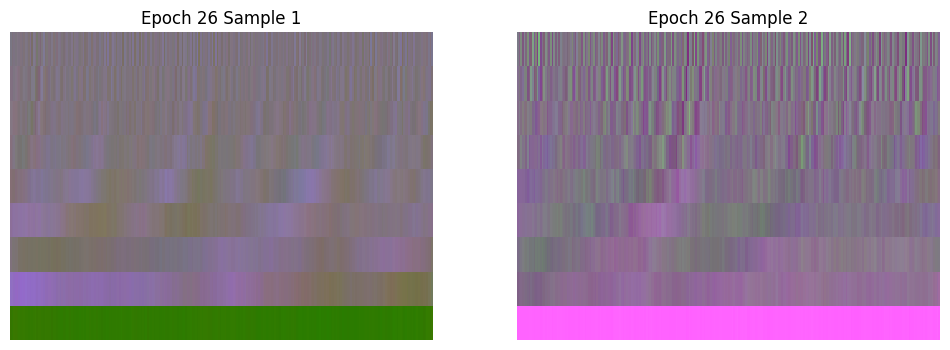

Epoch 27/50: 100%|██████████| 314/314 [00:48<00:00,  6.42it/s, loss=0.00759]



Epoch 27 Average Loss: 0.009320
  Generating preview for Epoch 27...
  Generating preview for Epoch 27...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

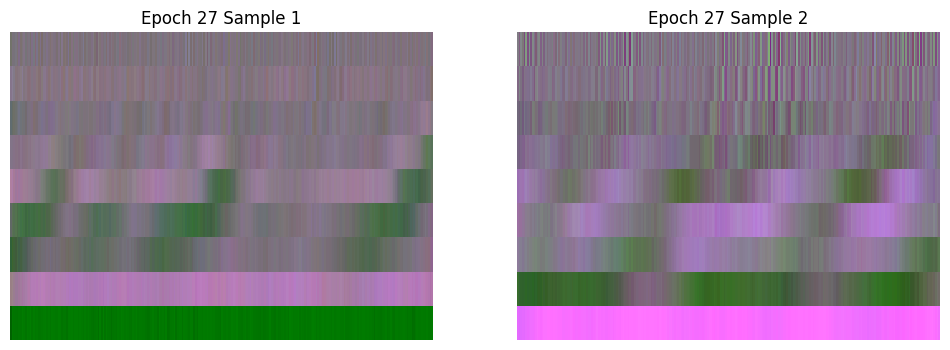

Epoch 28/50: 100%|██████████| 314/314 [00:48<00:00,  6.42it/s, loss=0.00836]



Epoch 28 Average Loss: 0.009498
  Generating preview for Epoch 28...
  Generating preview for Epoch 28...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

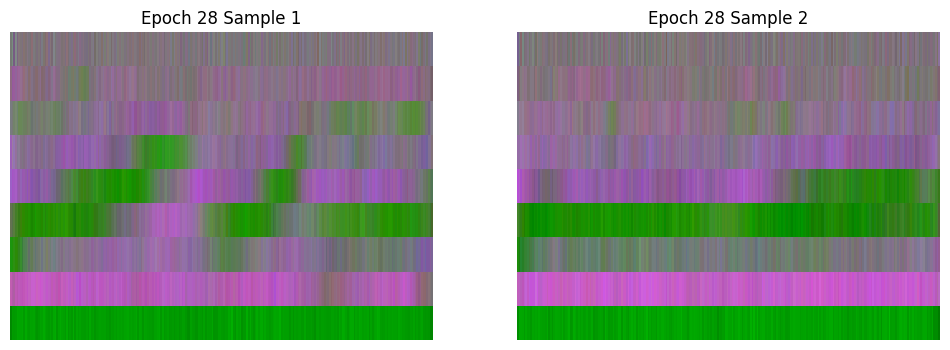

Epoch 29/50: 100%|██████████| 314/314 [00:49<00:00,  6.37it/s, loss=0.0105] 



Epoch 29 Average Loss: 0.009406
  Generating preview for Epoch 29...
  Generating preview for Epoch 29...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

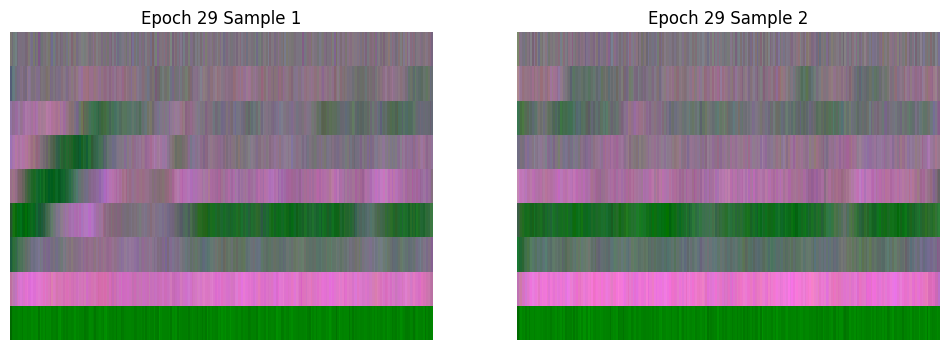

Epoch 30/50: 100%|██████████| 314/314 [00:49<00:00,  6.31it/s, loss=0.00636]



Epoch 30 Average Loss: 0.008648
  Generating preview for Epoch 30...
  Generating preview for Epoch 30...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

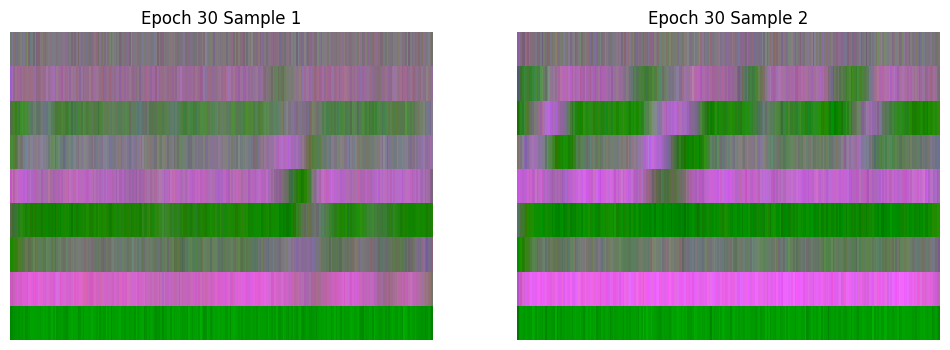

Epoch 31/50: 100%|██████████| 314/314 [00:49<00:00,  6.31it/s, loss=0.0145] 



Epoch 31 Average Loss: 0.008962
  Generating preview for Epoch 31...
  Generating preview for Epoch 31...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

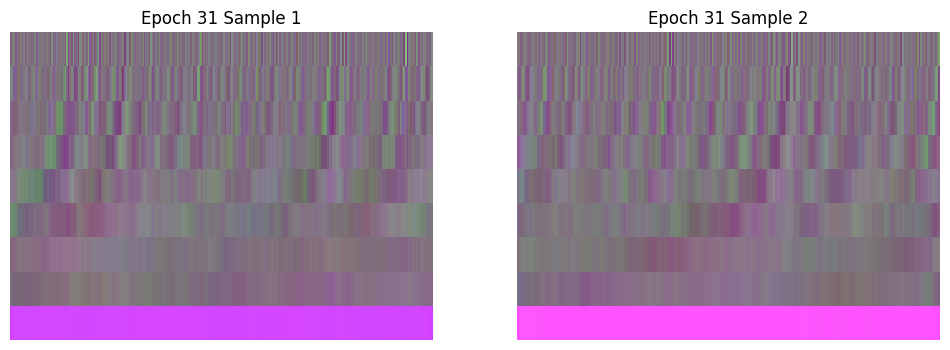

Epoch 32/50: 100%|██████████| 314/314 [00:49<00:00,  6.36it/s, loss=0.00692]



Epoch 32 Average Loss: 0.008941
  Generating preview for Epoch 32...
  Generating preview for Epoch 32...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

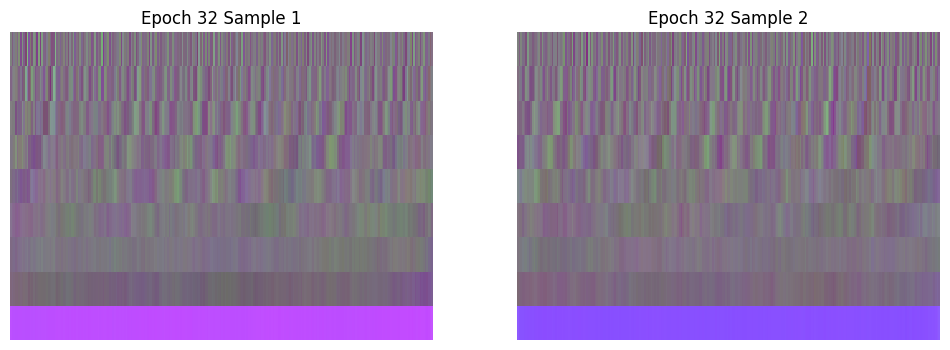

Epoch 33/50: 100%|██████████| 314/314 [00:49<00:00,  6.36it/s, loss=0.00753]



Epoch 33 Average Loss: 0.008375
  Generating preview for Epoch 33...
  Generating preview for Epoch 33...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

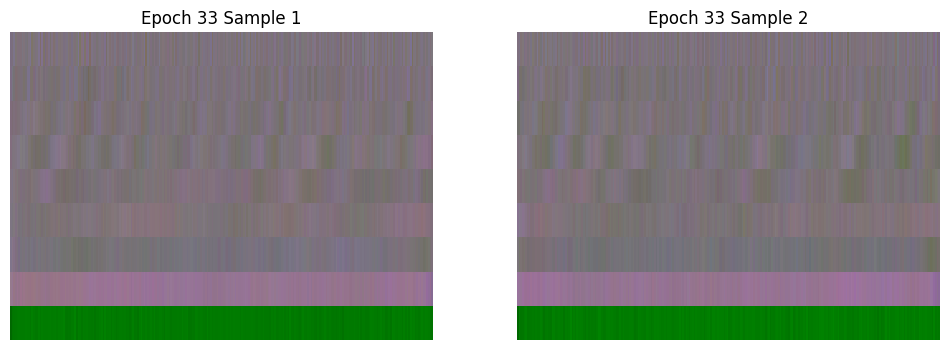

Epoch 34/50: 100%|██████████| 314/314 [00:49<00:00,  6.31it/s, loss=0.0123] 



Epoch 34 Average Loss: 0.008353
  Generating preview for Epoch 34...
  Generating preview for Epoch 34...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

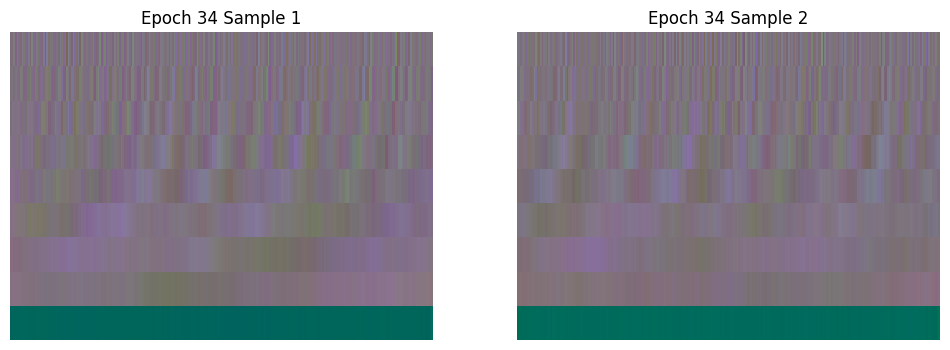

Epoch 35/50: 100%|██████████| 314/314 [00:49<00:00,  6.32it/s, loss=0.00915]



Epoch 35 Average Loss: 0.008234
  Generating preview for Epoch 35...
  Generating preview for Epoch 35...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

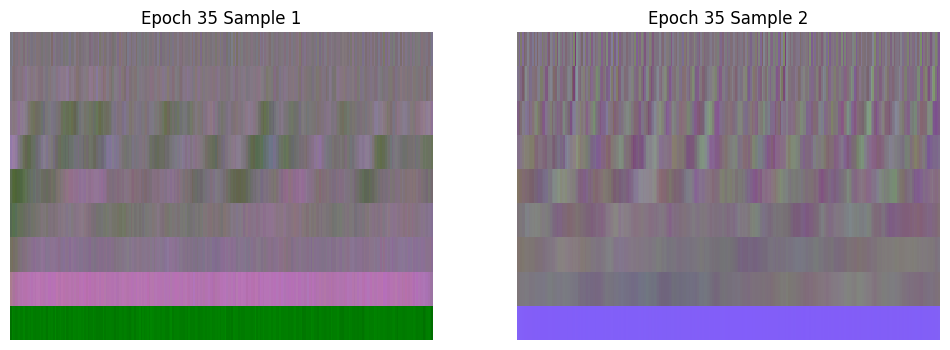

Epoch 36/50: 100%|██████████| 314/314 [00:49<00:00,  6.29it/s, loss=0.00791]



Epoch 36 Average Loss: 0.008290
  Generating preview for Epoch 36...
  Generating preview for Epoch 36...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

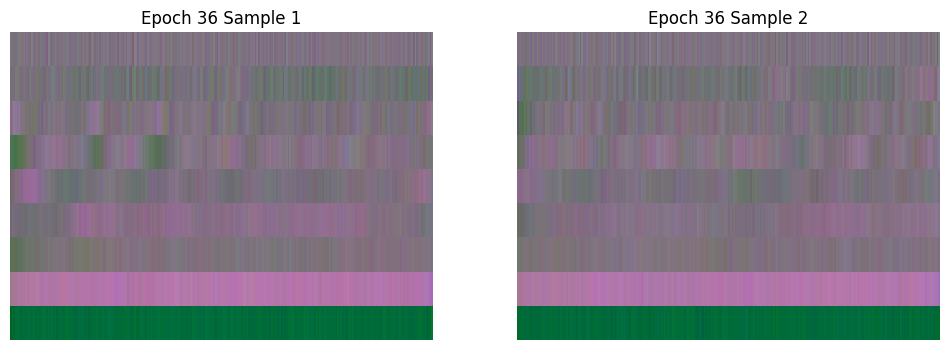

Epoch 37/50: 100%|██████████| 314/314 [00:51<00:00,  6.06it/s, loss=0.00907]



Epoch 37 Average Loss: 0.008382
  Generating preview for Epoch 37...
  Generating preview for Epoch 37...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

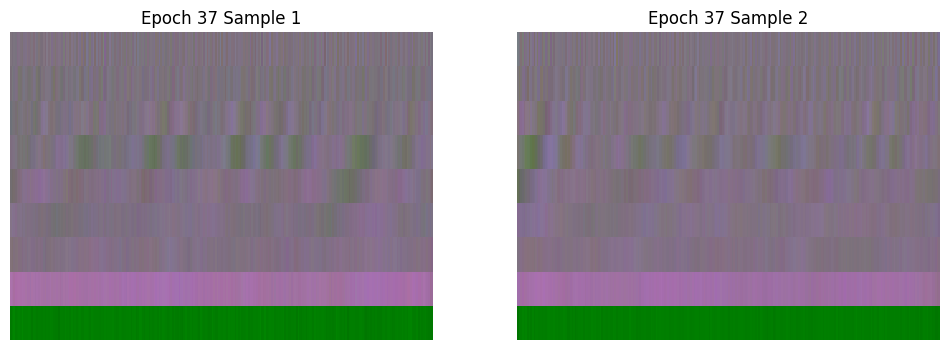

Epoch 38/50: 100%|██████████| 314/314 [00:52<00:00,  6.02it/s, loss=0.00868]



Epoch 38 Average Loss: 0.008105
  Generating preview for Epoch 38...
  Generating preview for Epoch 38...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

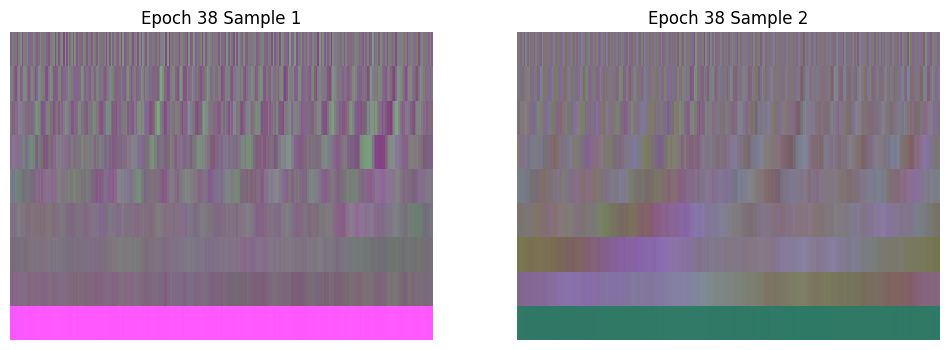

Epoch 39/50: 100%|██████████| 314/314 [00:51<00:00,  6.09it/s, loss=0.00679]



Epoch 39 Average Loss: 0.007846
  Generating preview for Epoch 39...
  Generating preview for Epoch 39...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

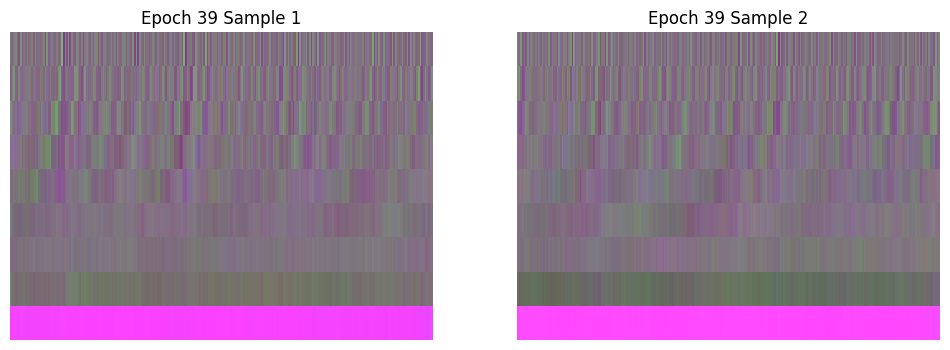

Epoch 40/50: 100%|██████████| 314/314 [00:51<00:00,  6.04it/s, loss=0.00971]



Epoch 40 Average Loss: 0.007904
  Generating preview for Epoch 40...
  Generating preview for Epoch 40...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

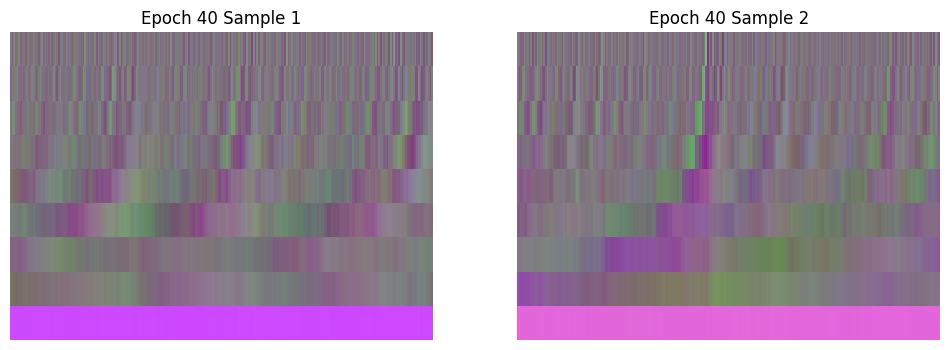

Epoch 41/50: 100%|██████████| 314/314 [00:52<00:00,  5.93it/s, loss=0.00393]



Epoch 41 Average Loss: 0.007564
  Generating preview for Epoch 41...
  Generating preview for Epoch 41...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

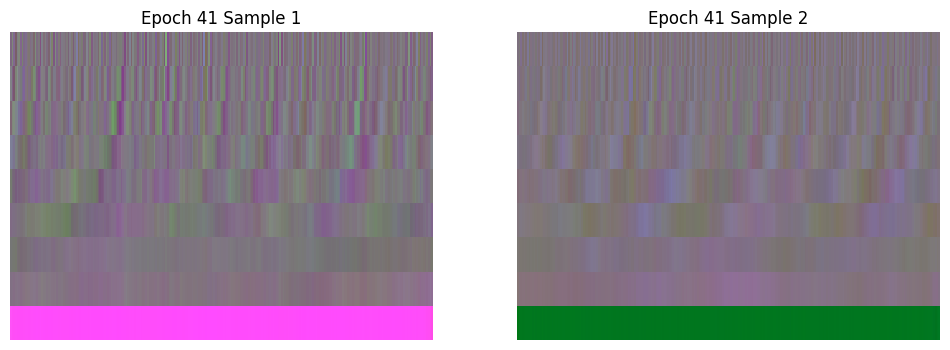

Epoch 42/50: 100%|██████████| 314/314 [00:51<00:00,  6.06it/s, loss=0.00871]



Epoch 42 Average Loss: 0.007539
  Generating preview for Epoch 42...
  Generating preview for Epoch 42...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

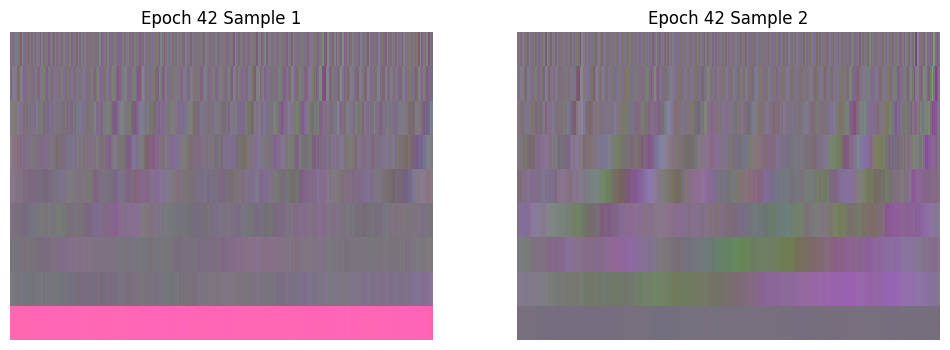

Epoch 43/50: 100%|██████████| 314/314 [00:52<00:00,  6.02it/s, loss=0.0049] 



Epoch 43 Average Loss: 0.007414
  Generating preview for Epoch 43...
  Generating preview for Epoch 43...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

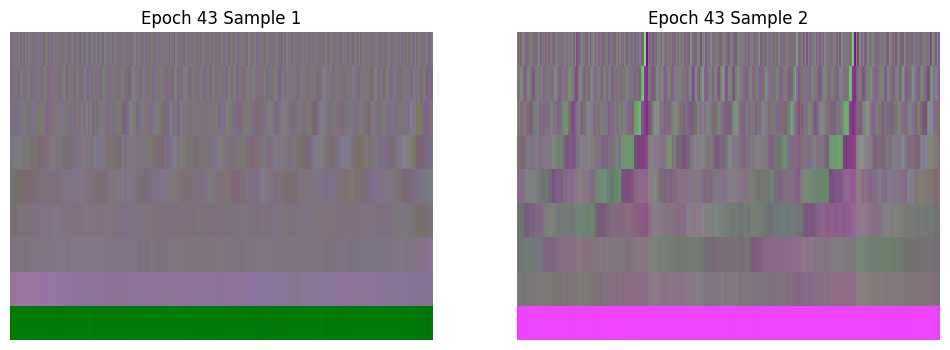

Epoch 44/50: 100%|██████████| 314/314 [00:51<00:00,  6.05it/s, loss=0.00626]



Epoch 44 Average Loss: 0.007364
  Generating preview for Epoch 44...
  Generating preview for Epoch 44...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

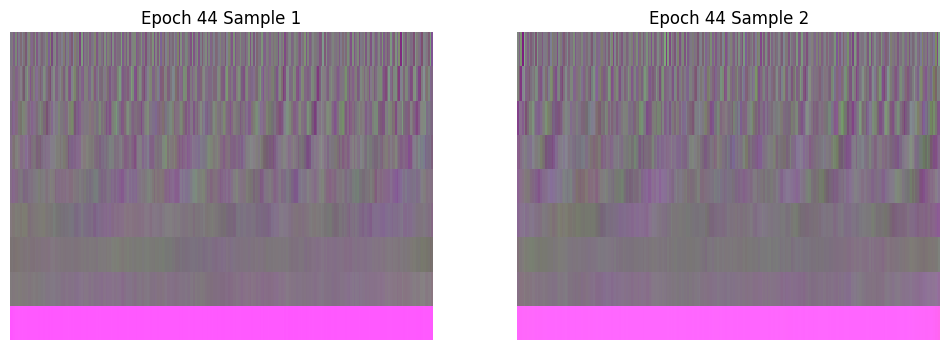

Epoch 45/50: 100%|██████████| 314/314 [00:52<00:00,  6.01it/s, loss=0.00857]



Epoch 45 Average Loss: 0.007295
  Generating preview for Epoch 45...
  Generating preview for Epoch 45...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

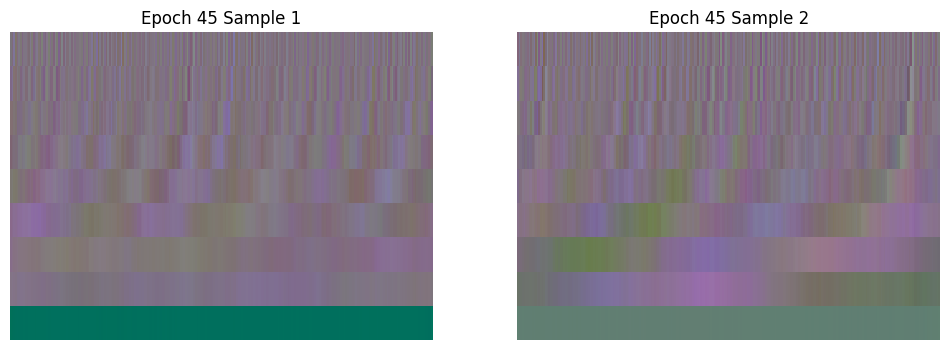

Epoch 46/50: 100%|██████████| 314/314 [00:51<00:00,  6.08it/s, loss=0.00609]



Epoch 46 Average Loss: 0.007002
  Generating preview for Epoch 46...
  Generating preview for Epoch 46...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

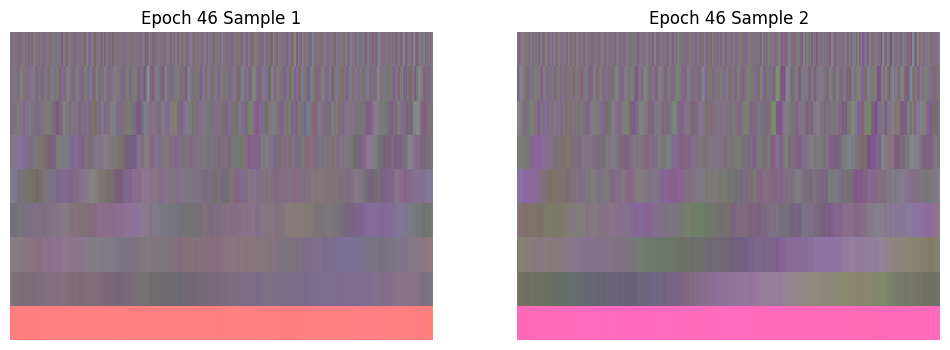

Epoch 47/50: 100%|██████████| 314/314 [00:51<00:00,  6.09it/s, loss=0.00667]



Epoch 47 Average Loss: 0.006719
  Generating preview for Epoch 47...
  Generating preview for Epoch 47...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

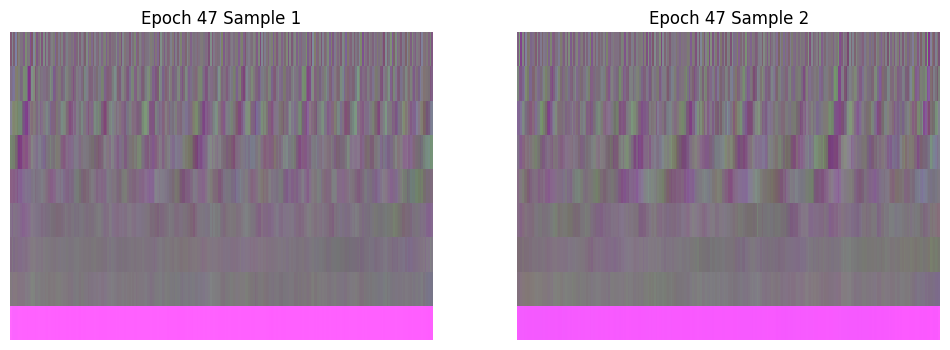

Epoch 48/50: 100%|██████████| 314/314 [00:51<00:00,  6.07it/s, loss=0.00518]



Epoch 48 Average Loss: 0.006849
  Generating preview for Epoch 48...
  Generating preview for Epoch 48...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

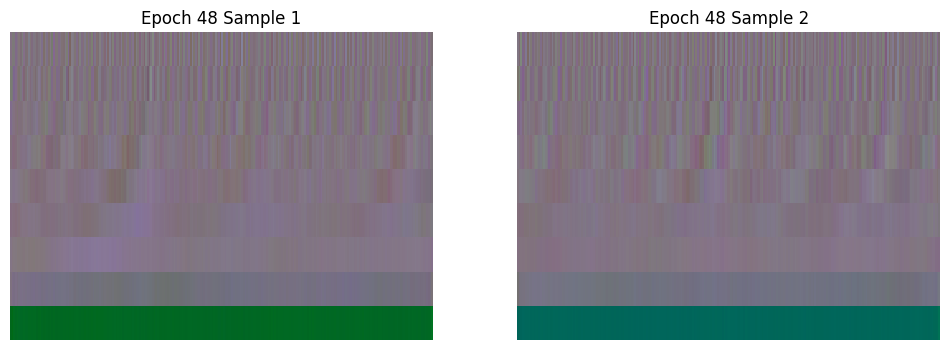

Epoch 49/50: 100%|██████████| 314/314 [00:51<00:00,  6.08it/s, loss=0.0056] 



Epoch 49 Average Loss: 0.006394
  Generating preview for Epoch 49...
  Generating preview for Epoch 49...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

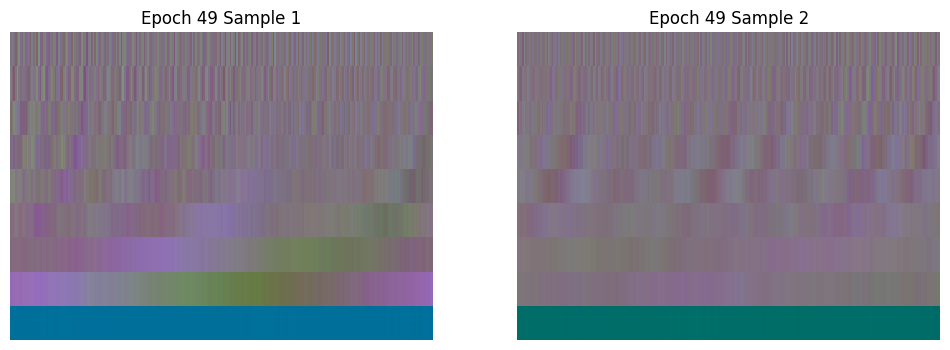

Epoch 50/50: 100%|██████████| 314/314 [00:51<00:00,  6.05it/s, loss=0.00491]



Epoch 50 Average Loss: 0.006416
  Generating preview for Epoch 50...
  Generating preview for Epoch 50...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

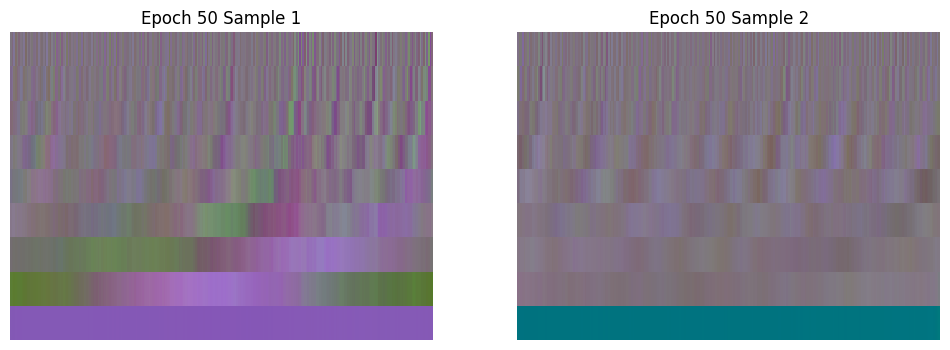

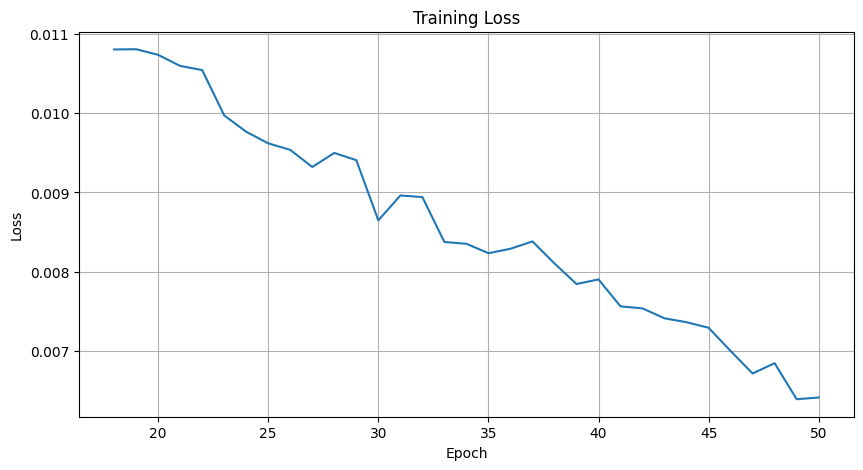

Training complete!


In [11]:
# Train the diffusion model on the wavelet images
# This cell trains the UNet to reverse the diffusion process

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import shutil
import sys
sys.path.append('..')
from src.diffusion import UNet, Diffusion

# Configuration
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 50 
TIMESTEPS = 1000
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT_DIR = './diffusion_checkpoints'
RESUME_FROM = './diffusion_checkpoints/ckpt_epoch_17.pt' # Set to path like './diffusion_checkpoints/ckpt_epoch_20.pt' to resume
LOSS_TYPE = 'frequency_weighted' # Options: 'l2', 'huber', 'weighted_mse', 'tail_focused', 'frequency_weighted'

# Create checkpoint directory
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
elif RESUME_FROM is None:
    # If starting fresh, clear old checkpoints to avoid confusion
    print(f"Starting fresh training. Clearing {CHECKPOINT_DIR}...")
    shutil.rmtree(CHECKPOINT_DIR)
    os.makedirs(CHECKPOINT_DIR)

# Custom Dataset for Wavelet Images
class WaveletDataset(Dataset):
    def __init__(self, wavelet_images_path):
        self.data = np.load(wavelet_images_path)
        # Data is (N, H, W, C) -> (N, 9, 256, 3)
        # PyTorch expects (N, C, H, W)
        self.data = np.transpose(self.data, (0, 3, 1, 2))
        
        # Scale from [0, 1] to [-1, 1] for diffusion
        self.data = self.data * 2.0 - 1.0
        self.data = torch.FloatTensor(self.data)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# Load Data
if os.path.exists('wavelet_images.npy'):
    dataset = WaveletDataset('wavelet_images.npy')
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    print(f"Loaded dataset with {len(dataset)} samples. Shape: {dataset.data.shape}")
else:
    raise RuntimeError("wavelet_images.npy not found. Run the wavelet transformation cell first.")

# Initialize Model
model = UNet(in_channels=3).to(DEVICE) # 3 channels for RGB
diffusion = Diffusion(model, timesteps=TIMESTEPS, device=DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

# Resume training if specified
start_epoch = 0
if RESUME_FROM and os.path.exists(RESUME_FROM):
    print(f"Resuming training from {RESUME_FROM}")
    checkpoint = torch.load(RESUME_FROM, map_location=DEVICE)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch'] + 1

# Training Loop
print(f"Starting training on {DEVICE}...")
print(f"Using Loss Type: {LOSS_TYPE}")
loss_history = []

for epoch in range(start_epoch, EPOCHS):
    model.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    epoch_loss = 0
    
    for batch in pbar:
        batch = batch.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Sample random timesteps
        t = torch.randint(0, TIMESTEPS, (batch.shape[0],), device=DEVICE).long()
        
        # Calculate loss
        loss = diffusion.p_losses(batch, t, loss_type=LOSS_TYPE)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})
    
    avg_loss = epoch_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.6f}")
    
    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': avg_loss
    }
    
    # Save every epoch
    torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, f'ckpt_epoch_{epoch+1}.pt'))
    
    # Save latest
    torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, 'ckpt_latest.pt'))

    # === VISUALIZATION STEP ===
    # Generate a preview to monitor progress without waiting for full training
    model.eval()
    with torch.no_grad():
        # Get dimensions from dataset: shape is (N, C, H, W)
        H, W = dataset.data.shape[2], dataset.data.shape[3]
        
        # Generate just 2 samples for speed
        print(f"  Generating preview for Epoch {epoch+1}...")
        # Use temperature=1.0 for standard quality check
        samples = diffusion.sample((2, 3, H, W), temperature=1.0)
        
        # Process for display: [-1, 1] -> [0, 1]
        samples = samples.clamp(-1, 1).cpu().numpy()
        samples = (samples + 1) / 2
        
        # Transpose to (N, H, W, C) for matplotlib
        samples = np.transpose(samples, (0, 2, 3, 1))
        
        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        for i in range(2):
            axes[i].imshow(samples[i], aspect='auto', origin='lower', interpolation='nearest')
            axes[i].set_title(f'Epoch {epoch+1} Sample {i+1}')
            axes[i].axis('off')
        plt.show()
    model.train()
    # ==========================

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(start_epoch + 1, start_epoch + 1 + len(loss_history)), loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

print("Training complete!")

Loading checkpoint: ./diffusion_checkpoints\ckpt_epoch_50.pt
Using image dimensions: 9x256x3 (RGB)
Generating 1000 synthetic RGB wavelet images in batches of 50...
  Batch 1/20 (50 samples)...
Using image dimensions: 9x256x3 (RGB)
Generating 1000 synthetic RGB wavelet images in batches of 50...
  Batch 1/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 2/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 3/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 4/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 5/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 6/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 7/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 8/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 9/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 10/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 11/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 12/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 13/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 14/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 15/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 16/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 17/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 18/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 19/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

  Batch 20/20 (50 samples)...


DDIM Sampling (100 steps):   0%|          | 0/100 [00:00<?, ?it/s]

Raw Output Stats (pre-clamp): Min=-1.029, Max=1.022, Mean=-0.039, Std=0.144
Saved 1000 synthetic samples to 'synthetic_wavelet_images.npy'
Saved 1000 synthetic samples to 'synthetic_wavelet_images.npy'


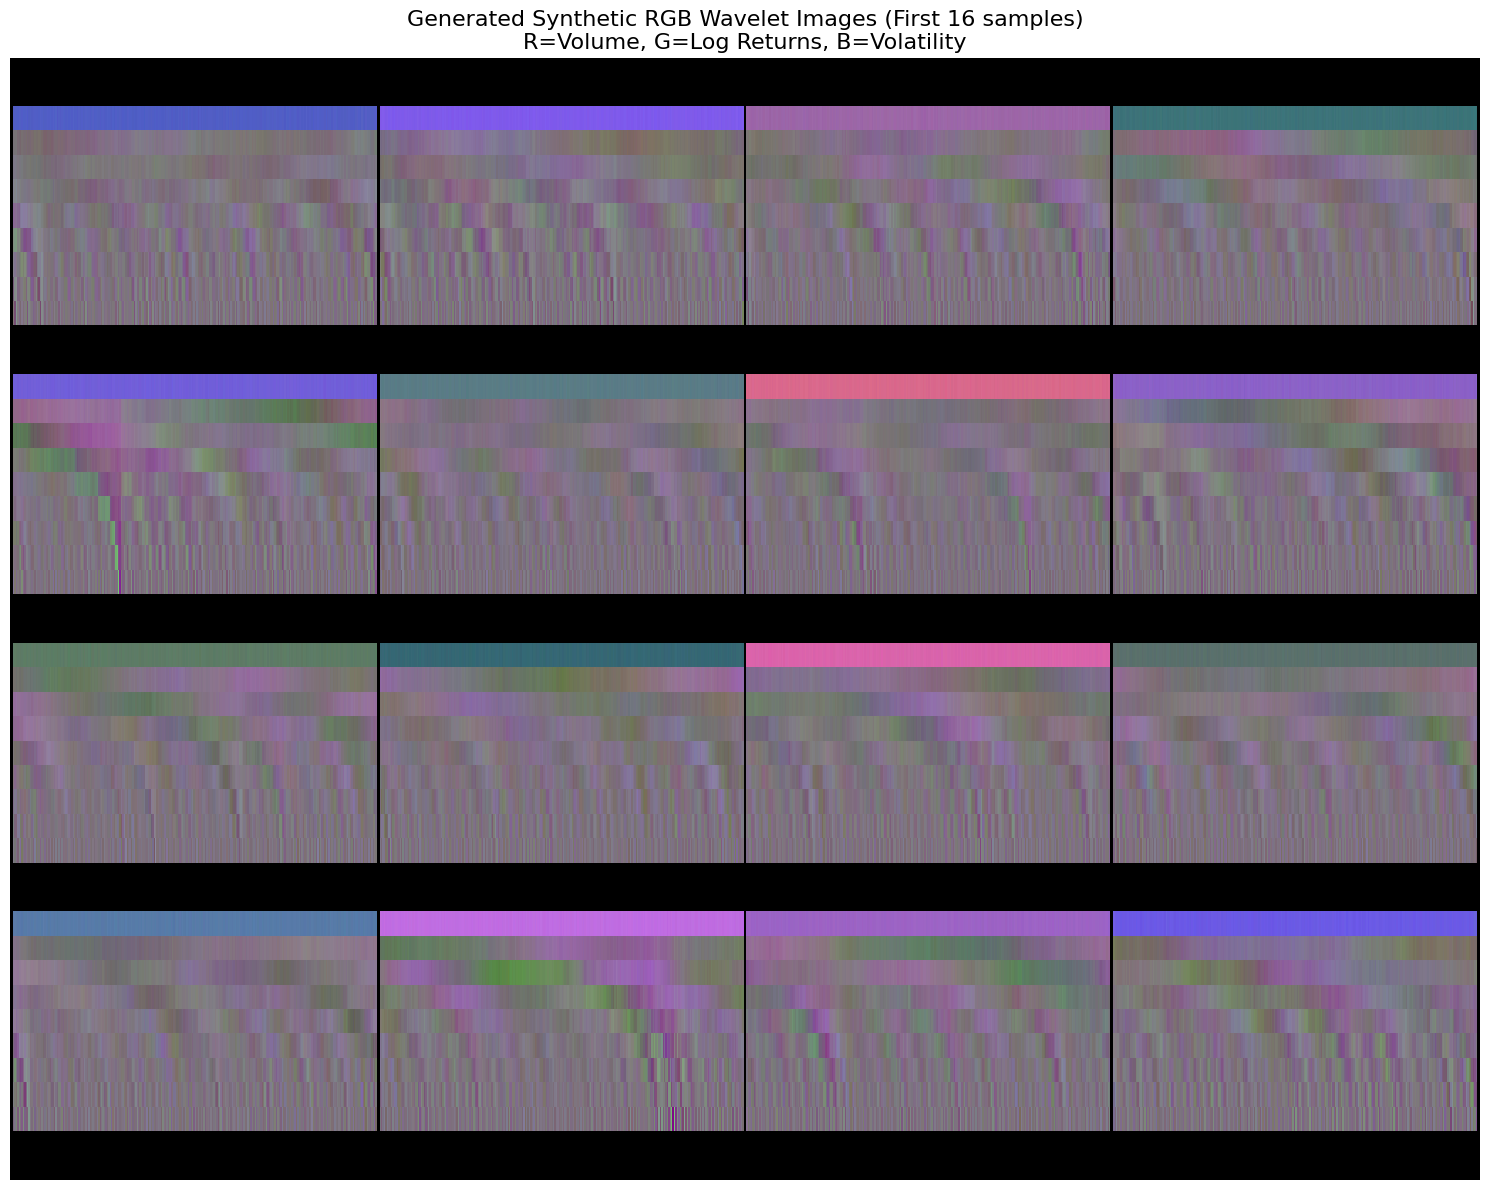

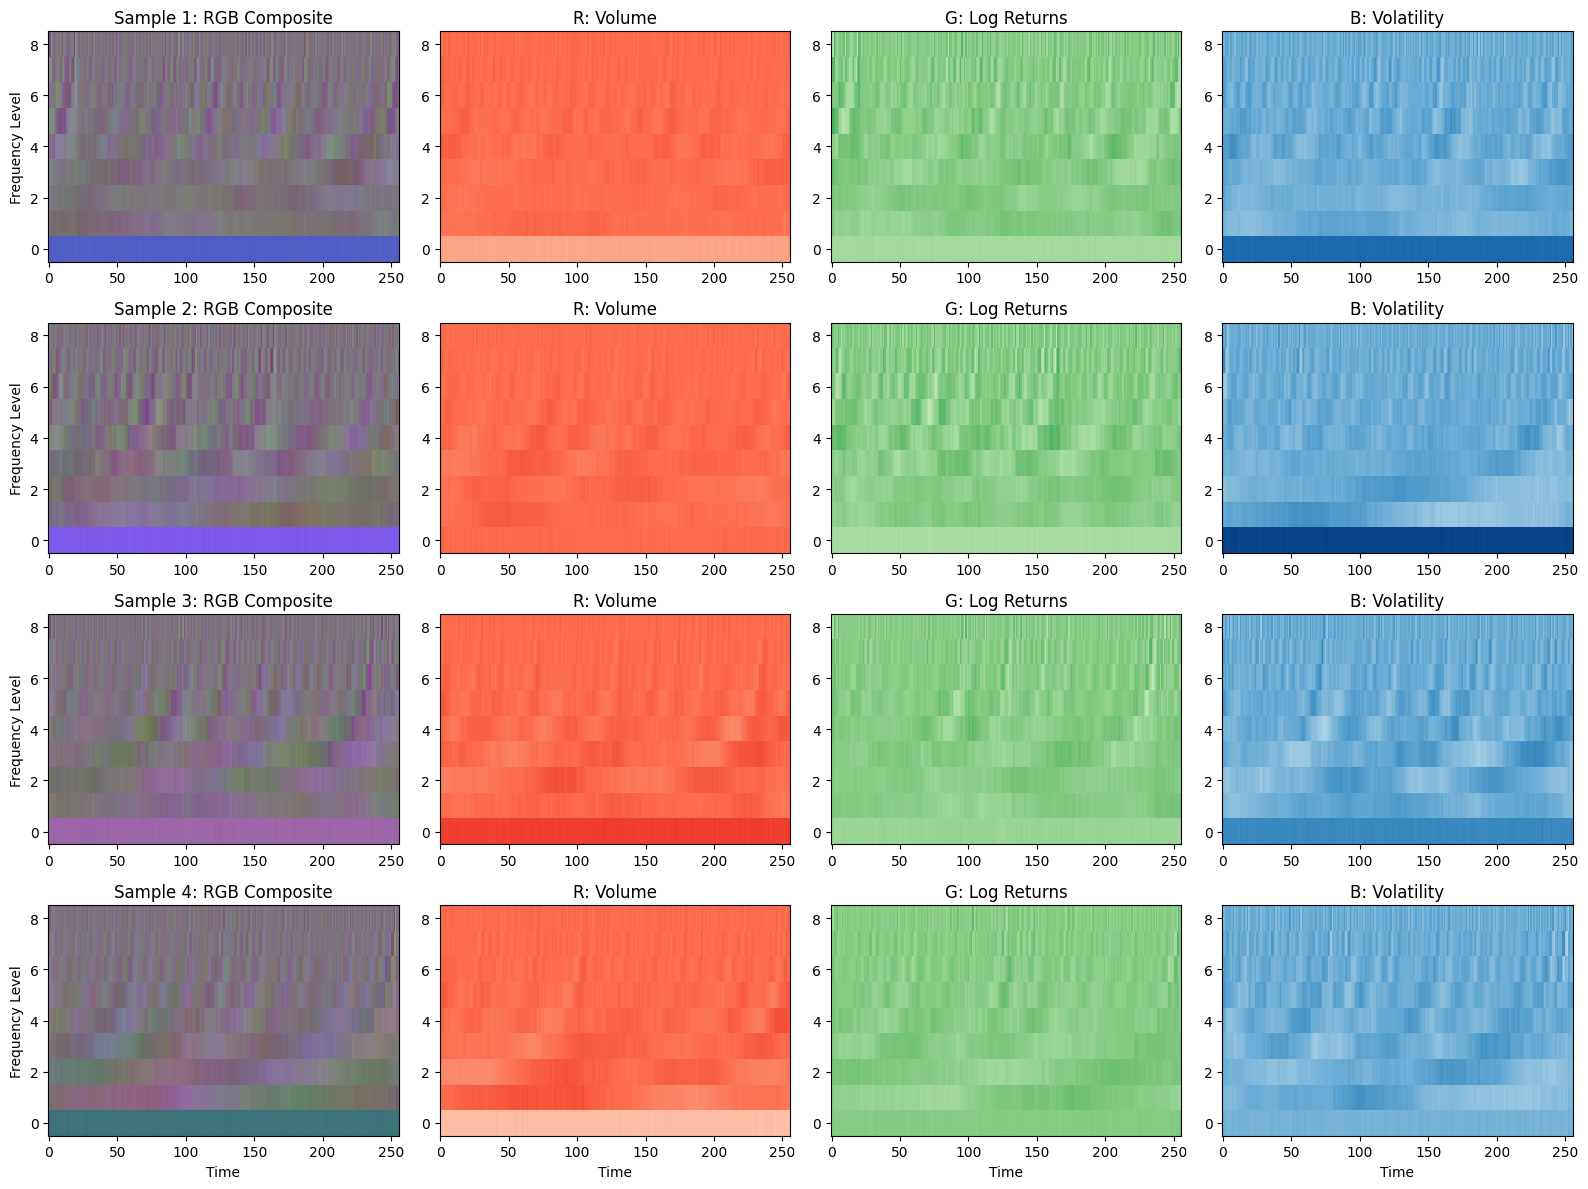

Generated 1000 synthetic RGB wavelet images successfully!
- R channel: Volume
- G channel: Log Returns
- B channel: Volatility


In [12]:
# Generate synthetic single-channel wavelet images using trained diffusion model
# Load the latest checkpoint and generate new samples

import matplotlib.pyplot as plt
import numpy as np
import torch
from src.diffusion.unet import UNet
from src.diffusion.diffusion import Diffusion
import os
import glob
import math

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT_DIR = './diffusion_checkpoints'
NUM_SAMPLES = 1000  # Number of synthetic images to generate
BATCH_SIZE_GEN = 50 # Batch size for generation to avoid OOM
TIMESTAMPS = 1000  # Number of diffusion timesteps
SAVE_SAMPLES = True  # Whether to save generated samples to disk
TEMPERATURE = 1.0  # Reduced from 1.5 to 1.0 to prevent saturation artifacts
USE_DDIM = True    # Use DDIM for faster sampling
DDIM_STEPS = 100    # Number of steps for DDIM (vs 1500 for standard)

# Helper function to replace vutils.make_grid
def make_grid_np(images, nrow=8, padding=2):
    """
    Creates a grid of images from a numpy array.
    images: (N, H, W, C) numpy array with values in [0, 1]
    nrow: number of images per row
    padding: pixels of padding between images
    """
    N, H, W, C = images.shape
    num_cols = nrow
    num_rows = int(np.ceil(N / num_cols))
    
    grid_h = num_rows * (H + padding) + padding
    grid_w = num_cols * (W + padding) + padding
    
    # Initialize with black background (0)
    grid = np.zeros((grid_h, grid_w, C), dtype=images.dtype)
    
    for idx in range(N):
        r = idx // num_cols
        c = idx % num_cols
        
        y = r * (H + padding) + padding
        x = c * (W + padding) + padding
        
        grid[y:y+H, x:x+W, :] = images[idx]
        
    return grid

# Find the latest checkpoint
checkpoint_files = glob.glob(os.path.join(CHECKPOINT_DIR, 'ckpt_epoch_*.pt'))
if not checkpoint_files:
    raise RuntimeError(f"No checkpoint files found in {CHECKPOINT_DIR}. Train the model first.")

latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
print(f"Loading checkpoint: {latest_checkpoint}")

# Load model architecture and weights
model = UNet(in_channels=3).to(DEVICE)  # 3 channels for RGB
diffusion = Diffusion(model, timesteps=TIMESTAMPS, device=DEVICE)

checkpoint = torch.load(latest_checkpoint, map_location=DEVICE)
model.load_state_dict(checkpoint['model'])
model.eval()

# Get image dimensions from saved wavelet_images
if os.path.exists('wavelet_images.npy'):
    saved_imgs = np.load('wavelet_images.npy')
    H, W, C = saved_imgs.shape[1], saved_imgs.shape[2], saved_imgs.shape[3]
    print(f"Using image dimensions: {H}x{W}x{C} (RGB)")
else:
    raise RuntimeError("wavelet_images.npy not found. Run the wavelet image generation cell first.")

print(f"Generating {NUM_SAMPLES} synthetic RGB wavelet images in batches of {BATCH_SIZE_GEN}...")

all_samples_list = []
num_batches = math.ceil(NUM_SAMPLES / BATCH_SIZE_GEN)

for i in range(num_batches):
    current_batch_size = min(BATCH_SIZE_GEN, NUM_SAMPLES - i * BATCH_SIZE_GEN)
    print(f"  Batch {i+1}/{num_batches} ({current_batch_size} samples)...")
    
    if USE_DDIM:
        # print(f"Using DDIM sampling with {DDIM_STEPS} steps (fast mode)...")
        batch_samples = diffusion.ddim_sample((current_batch_size, 3, H, W), steps=DDIM_STEPS, eta=0.0)
    else:
        # print(f"Using standard sampling with 1500 steps (slow mode, temp={TEMPERATURE})...")
        batch_samples = diffusion.sample((current_batch_size, 3, H, W), temperature=TEMPERATURE)
    
    # Move to CPU immediately to free up GPU memory
    all_samples_list.append(batch_samples.cpu())
    torch.cuda.empty_cache()

# Concatenate all batches
synthetic_samples = torch.cat(all_samples_list, dim=0)

# Diagnostic: Check raw output stats
print(f"Raw Output Stats (pre-clamp): Min={synthetic_samples.min():.3f}, Max={synthetic_samples.max():.3f}, Mean={synthetic_samples.mean():.3f}, Std={synthetic_samples.std():.3f}")

# Convert from [-1,1] to [0,1] for visualization
synthetic_samples = synthetic_samples.clamp(-1, 1)
synthetic_samples = (synthetic_samples + 1.0) / 2.0

# Convert to numpy for visualization and saving
# Transpose from (N, C, H, W) to (N, H, W, C)
synthetic_samples_np = synthetic_samples.numpy() # Already on CPU
synthetic_samples_np = np.transpose(synthetic_samples_np, (0, 2, 3, 1))

# Save samples if requested
if SAVE_SAMPLES:
    np.save('synthetic_wavelet_images.npy', synthetic_samples_np)
    print(f"Saved {NUM_SAMPLES} synthetic samples to 'synthetic_wavelet_images.npy'")

# Create visualization grid manually
# Take first 16 samples for the grid
samples_for_grid = synthetic_samples_np[:16]
grid_np = make_grid_np(samples_for_grid, nrow=4, padding=2)

# Display the generated samples
plt.figure(figsize=(15, 12))
# Display RGB composite (first 3 channels)
grid_rgb = grid_np[:, :, :3]  # Take RGB channels
plt.imshow(grid_rgb, aspect='auto', interpolation='nearest')
plt.title(f'Generated Synthetic RGB Wavelet Images (First 16 samples)\nR=Volume, G=Log Returns, B=Volatility', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# Display individual samples for detailed inspection (RGB + individual channels)
fig, axes = plt.subplots(min(4, NUM_SAMPLES), 4, figsize=(16, min(4, NUM_SAMPLES)*3))
if min(4, NUM_SAMPLES) == 1:
    axes = axes[np.newaxis, :]

for i in range(min(4, NUM_SAMPLES)):
    sample = synthetic_samples_np[i]  # (H, W, 3)
    
    # RGB composite
    axes[i, 0].imshow(sample, aspect='auto', origin='lower', interpolation='nearest')
    axes[i, 0].set_title(f'Sample {i+1}: RGB Composite')
    axes[i, 0].set_ylabel('Frequency Level')
    
    # R channel (Volume)
    axes[i, 1].imshow(sample[:, :, 0], aspect='auto', origin='lower', cmap='Reds', vmin=0, vmax=1, interpolation='nearest')
    axes[i, 1].set_title('R: Volume')
    
    # G channel (Log Returns)
    axes[i, 2].imshow(sample[:, :, 1], aspect='auto', origin='lower', cmap='Greens', vmin=0, vmax=1, interpolation='nearest')
    axes[i, 2].set_title('G: Log Returns')
    
    # B channel (Volatility)
    axes[i, 3].imshow(sample[:, :, 2], aspect='auto', origin='lower', cmap='Blues', vmin=0, vmax=1, interpolation='nearest')
    axes[i, 3].set_title('B: Volatility')
    
    if i == min(4, NUM_SAMPLES) - 1:
        for ax in axes[i]:
            ax.set_xlabel('Time')

plt.tight_layout()
plt.show()

print(f"Generated {NUM_SAMPLES} synthetic RGB wavelet images successfully!")
print("- R channel: Volume")
print("- G channel: Log Returns")
print("- B channel: Volatility")


In [13]:
# Reconstruct synthetic time series from RGB wavelet images
# Converts 3-channel wavelet images back to z-score normalized time series for all features

import pywt
import numpy as np

print("=== PREPARING DATA FOR ANALYSIS ===")

# ============================================================================
# PART 1: RECONSTRUCT SYNTHETIC TIME SERIES FROM RGB WAVELET IMAGES
# ============================================================================

# Load synthetic wavelet images (either from current generation or saved file)
try:
    synthetic_imgs = synthetic_samples.cpu().numpy()
    # Transpose from (N, C, H, W) to (N, H, W, C)
    synthetic_imgs = np.transpose(synthetic_imgs, (0, 2, 3, 1))
except NameError:
    if os.path.exists('synthetic_wavelet_images.npy'):
        synthetic_imgs = np.load('synthetic_wavelet_images.npy')
        print("Loaded synthetic wavelet images from file")
    else:
        raise RuntimeError("No synthetic images available. Generate samples first.")

print(f"Synthetic RGB wavelet images shape: {synthetic_imgs.shape}")

# Load wavelet normalization parameters
if os.path.exists('wavelet_normalization_params.npy'):
    wavelet_norm_params = np.load('wavelet_normalization_params.npy', allow_pickle=True).item()
    wavelet_type = wavelet_norm_params['wavelet_type']
    wavelet_level = wavelet_norm_params['wavelet_level']
    WINDOW_LENGTH = wavelet_norm_params['window_length']
    
    print(f"Wavelet type: {wavelet_type}")
    print(f"Wavelet level: {wavelet_level}")
    print(f"Window length: {WINDOW_LENGTH}")
    print(f"Normalization type: {wavelet_norm_params.get('normalization_type', 'unknown')}")
    
    # Load denormalization parameters (min/max values for each channel)
    if wavelet_norm_params.get('n_channels') == 3:
        print("✓ Detected 3-channel (RGB) normalization")
        
        # NEW: Min-Max based denormalization
        if wavelet_norm_params.get('normalization_type') == 'min_max':
            print("Using Min-Max denormalization")
            vol_min = wavelet_norm_params['volume_min']
            vol_max = wavelet_norm_params['volume_max']
            ret_min = wavelet_norm_params['returns_min']
            ret_max = wavelet_norm_params['returns_max']
            vol_vol_min = wavelet_norm_params['volatility_min']
            vol_vol_max = wavelet_norm_params['volatility_max']
            print(f"  Volume (R): min={vol_min:.4f}, max={vol_max:.4f}")
            print(f"  Log Returns (G): min={ret_min:.4f}, max={ret_max:.4f}")
            print(f"  Volatility (B): min={vol_vol_min:.4f}, max={vol_vol_max:.4f}")
        else:
            raise RuntimeError(f"Unsupported normalization type: {wavelet_norm_params.get('normalization_type')}")
    else:
        raise RuntimeError(f"Expected 3 channels but got {wavelet_norm_params.get('n_channels')}")
else:
    raise RuntimeError("wavelet_normalization_params.npy not found. Run wavelet preprocessing first.")

# ============================================================================
# PART 2: DENORMALIZE AND RECONSTRUCT EACH CHANNEL
# ============================================================================

def denormalize_and_reconstruct(channel_imgs, min_val, max_val, channel_name):
    """Denormalize wavelet coefficients from [0,1] to original range and apply inverse SWT"""
    print(f"\nReconstructing {channel_name}...")
    
    eps = 1e-8
    # Denormalize from [0,1] back to original coefficient range using min/max
    wavelet_coeffs_denorm = channel_imgs * (max_val - min_val + eps) + min_val
    
    print(f"  Denormalized range: [{wavelet_coeffs_denorm.min():.4f}, {wavelet_coeffs_denorm.max():.4f}]")
    
    # Apply Inverse SWT to each sample
    reconstructed_series_list = []
    
    for i in range(len(wavelet_coeffs_denorm)):
        if i % 100 == 0:
            print(f"  Reconstructing {i}/{len(wavelet_coeffs_denorm)}...")
        
        coeffs_denorm = wavelet_coeffs_denorm[i]  # Shape: (wavelet_level+1, WINDOW_LENGTH)
        
        # Extract approximation and detail coefficients
        cA = coeffs_denorm[0]  # Approximation
        cD_list = [(cA, coeffs_denorm[j]) for j in range(1, len(coeffs_denorm))]  # Detail pairs
        
        # Apply inverse SWT
        reconstruction = pywt.iswt(cD_list, wavelet_type)
        
        # Ensure correct length
        if len(reconstruction) > WINDOW_LENGTH:
            reconstruction = reconstruction[:WINDOW_LENGTH]
        elif len(reconstruction) < WINDOW_LENGTH:
            reconstruction = np.pad(reconstruction, (0, WINDOW_LENGTH - len(reconstruction)), mode='edge')
        
        reconstructed_series_list.append(reconstruction)
    
    # Stack all reconstructed series
    reconstructed = np.stack(reconstructed_series_list)
    
    print(f"  {channel_name} reconstructed shape: {reconstructed.shape}")
    print(f"  Range: [{reconstructed.min():.4f}, {reconstructed.max():.4f}]")
    print(f"  Mean: {reconstructed.mean():.6f}")
    print(f"  Std: {reconstructed.std():.6f}")
    
    return reconstructed

# Separate channels
volume_channel = synthetic_imgs[:, :, :, 0]  # R channel
returns_channel = synthetic_imgs[:, :, :, 1]  # G channel
volatility_channel = synthetic_imgs[:, :, :, 2]  # B channel

# Reconstruct each feature using min/max denormalization
synthetic_zscore_log_volumes = denormalize_and_reconstruct(volume_channel, vol_min, vol_max, "Volume (R)")
synthetic_zscore_log_returns = denormalize_and_reconstruct(returns_channel, ret_min, ret_max, "Log Returns (G)")
synthetic_zscore_volatility = denormalize_and_reconstruct(volatility_channel, vol_vol_min, vol_vol_max, "Volatility (B)")

# ============================================================================
# PART 3: PREPARE ORIGINAL TIME SERIES AT SAME PREPROCESSING STAGE
# ============================================================================

print("\n" + "="*70)
print("PREPARING ORIGINAL DATA FOR COMPARISON")
print("="*70)

# The original data is already in z-score normalized space from cell 2
original_zscore_log_volumes = all_windows_combined_volumes.copy()
original_zscore_log_returns = all_windows_combined_log_returns.copy()
original_zscore_volatility = all_windows_combined_volatility.copy()

print(f"\nOriginal z-score normalized data:")
print(f"  Volume: {original_zscore_log_volumes.shape}, mean={original_zscore_log_volumes.mean():.6f}, std={original_zscore_log_volumes.std():.6f}")
print(f"  Log Returns: {original_zscore_log_returns.shape}, mean={original_zscore_log_returns.mean():.6f}, std={original_zscore_log_returns.std():.6f}")
print(f"  Volatility: {original_zscore_volatility.shape}, mean={original_zscore_volatility.mean():.6f}, std={original_zscore_volatility.std():.6f}")

# ============================================================================
# SUMMARY: DATASETS READY FOR COMPARISON
# ============================================================================

print("\n" + "="*70)
print("DATASETS READY FOR ANALYSIS")
print("="*70)
print(f"Both datasets are now at the same preprocessing stage:")
print(f"  - Log-transformed volumes")
print(f"  - Log returns from Close prices")
print(f"  - Log-transformed squared returns for volatility")
print(f"  - All features z-score normalized (mean≈0, std≈1)")
print(f"  - Window length: {WINDOW_LENGTH}")
print(f"\nOriginal datasets (windowed):")
print(f"  Volume:       original_zscore_log_volumes      {original_zscore_log_volumes.shape}")
print(f"  Log Returns:  original_zscore_log_returns      {original_zscore_log_returns.shape}")
print(f"  Volatility:   original_zscore_volatility       {original_zscore_volatility.shape}")
print(f"\nSynthetic datasets (reconstructed from wavelets):")
print(f"  Volume:       synthetic_zscore_log_volumes     {synthetic_zscore_log_volumes.shape}")
print(f"  Log Returns:  synthetic_zscore_log_returns     {synthetic_zscore_log_returns.shape}")
print(f"  Volatility:   synthetic_zscore_volatility      {synthetic_zscore_volatility.shape}")
print("="*70)

=== PREPARING DATA FOR ANALYSIS ===
Synthetic RGB wavelet images shape: (1000, 9, 256, 3)
Wavelet type: haar
Wavelet level: 8
Window length: 256
Normalization type: min_max
✓ Detected 3-channel (RGB) normalization
Using Min-Max denormalization
  Volume (R): min=-21.1086, max=21.3344
  Log Returns (G): min=-10.1100, max=12.3901
  Volatility (B): min=-9.0204, max=9.0333

Reconstructing Volume (R)...
  Denormalized range: [-19.7183, 19.7082]
  Reconstructing 0/1000...
  Reconstructing 100/1000...
  Reconstructing 100/1000...
  Reconstructing 200/1000...
  Reconstructing 200/1000...
  Reconstructing 300/1000...
  Reconstructing 300/1000...
  Reconstructing 400/1000...
  Reconstructing 400/1000...
  Reconstructing 500/1000...
  Reconstructing 500/1000...
  Reconstructing 600/1000...
  Reconstructing 600/1000...
  Reconstructing 700/1000...
  Reconstructing 700/1000...
  Reconstructing 800/1000...
  Reconstructing 800/1000...
  Reconstructing 900/1000...
  Reconstructing 900/1000...
  Volume

In [14]:
# Reconstruct synthetic time series from RGB wavelet images
# Converts 3-channel wavelet images back to z-score normalized time series for all features

import pywt
import numpy as np

print("=== PREPARING DATA FOR ANALYSIS ===")

# ============================================================================
# PART 1: RECONSTRUCT SYNTHETIC TIME SERIES FROM RGB WAVELET IMAGES
# ============================================================================

# Load synthetic wavelet images (either from current generation or saved file)
try:
    synthetic_imgs = synthetic_samples.cpu().numpy()
    # Transpose from (N, C, H, W) to (N, H, W, C)
    synthetic_imgs = np.transpose(synthetic_imgs, (0, 2, 3, 1))
except NameError:
    if os.path.exists('synthetic_wavelet_images.npy'):
        synthetic_imgs = np.load('synthetic_wavelet_images.npy')
        print("Loaded synthetic wavelet images from file")
    else:
        raise RuntimeError("No synthetic images available. Generate samples first.")

print(f"Synthetic RGB wavelet images shape: {synthetic_imgs.shape}")

# Load wavelet normalization parameters
if os.path.exists('wavelet_normalization_params.npy'):
    wavelet_norm_params = np.load('wavelet_normalization_params.npy', allow_pickle=True).item()
    wavelet_type = wavelet_norm_params['wavelet_type']
    wavelet_level = wavelet_norm_params['wavelet_level']
    n_channels = wavelet_norm_params.get('n_channels', 1)
    
    print(f"Loaded wavelet normalization params:")
    print(f"  Wavelet type: {wavelet_type}")
    print(f"  Wavelet level: {wavelet_level}")
    print(f"  Number of channels: {n_channels}")
    
    # Load channel-specific normalization parameters
    if n_channels == 3:
        # Check if using new min/max normalization or old percentile normalization
        norm_type = wavelet_norm_params.get('normalization_type', 'percentile')
        
        if norm_type == 'min_max':
            print("Using Min-Max denormalization (matching Cell 8)")
            vol_min = wavelet_norm_params['volume_min']
            vol_max = wavelet_norm_params['volume_max']
            ret_min = wavelet_norm_params['returns_min']
            ret_max = wavelet_norm_params['returns_max']
            vol_vol_min = wavelet_norm_params['volatility_min']
            vol_vol_max = wavelet_norm_params['volatility_max']
            
            # Map to generic names for function calls
            vol_p5, vol_p95 = vol_min, vol_max
            ret_p5, ret_p95 = ret_min, ret_max
            vol_vol_p5, vol_vol_p95 = vol_vol_min, vol_vol_max
            
            print(f"  Volume (R): min={vol_min:.4f}, max={vol_max:.4f}")
            print(f"  Log Returns (G): min={ret_min:.4f}, max={ret_max:.4f}")
            print(f"  Volatility (B): min={vol_vol_min:.4f}, max={vol_vol_max:.4f}")
            
        else:
            # Fallback for old checkpoints
            print("Using Percentile denormalization (legacy)")
            vol_p5 = wavelet_norm_params['volume_p5']
            vol_p95 = wavelet_norm_params['volume_p95']
            ret_p5 = wavelet_norm_params['returns_p5']
            ret_p95 = wavelet_norm_params['returns_p95']
            vol_vol_p5 = wavelet_norm_params['volatility_p5']
            vol_vol_p95 = wavelet_norm_params['volatility_p95']
            print(f"  Volume (R): p5={vol_p5:.4f}, p95={vol_p95:.4f}")
            print(f"  Log Returns (G): p5={ret_p5:.4f}, p95={ret_p95:.4f}")
            print(f"  Volatility (B): p5={vol_vol_p5:.4f}, p95={vol_vol_p95:.4f}")
    else:
        raise RuntimeError("Expected 3 channels but normalization params indicate different number")
else:
    raise RuntimeError("wavelet_normalization_params.npy not found. Run wavelet preprocessing first.")

# ============================================================================
# PART 2: DENORMALIZE AND RECONSTRUCT EACH CHANNEL
# ============================================================================

def denormalize_and_reconstruct(channel_imgs, p5, p95, channel_name):
    """Denormalize wavelet coefficients and apply inverse SWT"""
    print(f"\nReconstructing {channel_name}...")
    
    eps = 1e-8
    # Denormalize from [0,1] to original coefficient range
    wavelet_coeffs_denorm = channel_imgs * (p95 - p5 + eps) + p5
    
    print(f"  Denormalized range: [{wavelet_coeffs_denorm.min():.4f}, {wavelet_coeffs_denorm.max():.4f}]")
    
    # Apply Inverse SWT to each sample
    reconstructed_series_list = []
    
    for i in range(len(wavelet_coeffs_denorm)):
        if i % 100 == 0:
            print(f"  Reconstructing {i}/{len(wavelet_coeffs_denorm)}...")
        
        coeffs_denorm = wavelet_coeffs_denorm[i]  # Shape: (wavelet_level+1, WINDOW_LENGTH)
        
        # Extract approximation and detail coefficients
        cA = coeffs_denorm[0]  # Approximation
        detail_coeffs = coeffs_denorm[1:]  # Details
        
        # Build coefficient list for iswt
        coeffs_list = []
        for level_idx in range(wavelet_level):
            cD = detail_coeffs[level_idx]
            coeffs_list.append((cA.copy(), cD.copy()))
        
        # Apply inverse SWT
        reconstruction = pywt.iswt(coeffs_list, wavelet_type)
        
        # Ensure correct length
        if len(reconstruction) > WINDOW_LENGTH:
            reconstruction = reconstruction[:WINDOW_LENGTH]
        elif len(reconstruction) < WINDOW_LENGTH:
            reconstruction = np.pad(reconstruction, (0, WINDOW_LENGTH - len(reconstruction)), mode='edge')
        
        reconstructed_series_list.append(reconstruction)
    
    # Stack all reconstructed series
    reconstructed = np.stack(reconstructed_series_list)
    
    print(f"  {channel_name} reconstructed shape: {reconstructed.shape}")
    print(f"  Mean: {reconstructed.mean():.6f}")
    print(f"  Std: {reconstructed.std():.6f}")
    print(f"  Min: {reconstructed.min():.4f}")
    print(f"  Max: {reconstructed.max():.4f}")
    
    return reconstructed

# Separate channels
volume_channel = synthetic_imgs[:, :, :, 0]  # R channel
returns_channel = synthetic_imgs[:, :, :, 1]  # G channel
volatility_channel = synthetic_imgs[:, :, :, 2]  # B channel

# Reconstruct each feature
synthetic_zscore_log_volumes = denormalize_and_reconstruct(volume_channel, vol_p5, vol_p95, "Volume (R)")
synthetic_zscore_log_returns = denormalize_and_reconstruct(returns_channel, ret_p5, ret_p95, "Log Returns (G)")
synthetic_zscore_volatility = denormalize_and_reconstruct(volatility_channel, vol_vol_p5, vol_vol_p95, "Volatility (B)")

# ============================================================================
# PART 3: PREPARE ORIGINAL TIME SERIES AT SAME PREPROCESSING STAGE
# ============================================================================

print("\n" + "="*70)
print("PREPARING ORIGINAL DATA FOR COMPARISON")
print("="*70)

# The original data is already in z-score normalized space from cell 2
original_zscore_log_volumes = all_windows_combined_volumes.copy()
original_zscore_log_returns = all_windows_combined_log_returns.copy()
original_zscore_volatility = all_windows_combined_volatility.copy()

print(f"\nOriginal z-score normalized data:")
print(f"  Volume: {original_zscore_log_volumes.shape}, mean={original_zscore_log_volumes.mean():.6f}, std={original_zscore_log_volumes.std():.6f}")
print(f"  Log Returns: {original_zscore_log_returns.shape}, mean={original_zscore_log_returns.mean():.6f}, std={original_zscore_log_returns.std():.6f}")
print(f"  Volatility: {original_zscore_volatility.shape}, mean={original_zscore_volatility.mean():.6f}, std={original_zscore_volatility.std():.6f}")

# ============================================================================
# SUMMARY: DATASETS READY FOR COMPARISON
# ============================================================================

print("\n" + "="*70)
print("DATASETS READY FOR ANALYSIS")
print("="*70)
print(f"Both datasets are now at the same preprocessing stage:")
print(f"  - Log-transformed volumes")
print(f"  - Log returns from Close prices")
print(f"  - Volatility from squared log returns")
print(f"  - All features z-score normalized (mean≈0, std≈1)")
print(f"  - Window length: {WINDOW_LENGTH}")
print(f"\nOriginal datasets:")
print(f"  Volume:       original_zscore_log_volumes      {original_zscore_log_volumes.shape}")
print(f"  Log Returns:  original_zscore_log_returns      {original_zscore_log_returns.shape}")
print(f"  Volatility:   original_zscore_volatility       {original_zscore_volatility.shape}")
print(f"\nSynthetic datasets:")
print(f"  Volume:       synthetic_zscore_log_volumes     {synthetic_zscore_log_volumes.shape}")
print(f"  Log Returns:  synthetic_zscore_log_returns     {synthetic_zscore_log_returns.shape}")
print(f"  Volatility:   synthetic_zscore_volatility      {synthetic_zscore_volatility.shape}")
print("="*70)

# ============================================================================
# PART 4: INVERSE TRANSFORM TO ORIGINAL UNITS (OPTIONAL)
# ============================================================================

print("\n" + "="*70)
print("INVERSE TRANSFORMATION TO ORIGINAL UNITS")
print("="*70)

if os.path.exists('ticker_stats.npy'):
    ticker_stats = np.load('ticker_stats.npy', allow_pickle=True).item()
    print("Loaded ticker statistics.")
    
    # Calculate average stats for generic reconstruction
    avg_vol_mean = np.mean([stats['volatility_mean'] for stats in ticker_stats.values()])
    avg_vol_std = np.mean([stats['volatility_std'] for stats in ticker_stats.values()])
    
    print(f"Average Volatility Mean (Log Space): {avg_vol_mean:.6f}")
    print(f"Average Volatility Std (Log Space): {avg_vol_std:.6f}")
    
    def inverse_transform_volatility(zscore_vol, mean, std):
        # 1. Inverse Z-Score
        log_vol = zscore_vol * std + mean
        # 2. Inverse Log (Exp)
        vol_squared = np.exp(log_vol) - 1e-8
        return vol_squared

    # Example reconstruction for the first synthetic window
    example_zscore = synthetic_zscore_volatility[0]
    reconstructed_squared_returns = inverse_transform_volatility(example_zscore, avg_vol_mean, avg_vol_std)
    
    print(f"\nExample Reconstruction (First Window):")
    print(f"  Z-Score Range: [{example_zscore.min():.4f}, {example_zscore.max():.4f}]")
    print(f"  Reconstructed Squared Returns Range: [{reconstructed_squared_returns.min():.8f}, {reconstructed_squared_returns.max():.8f}]")
    print(f"  Note: This uses average statistics. For precise reconstruction, ticker-specific stats are needed.")

else:
    print("ticker_stats.npy not found. Cannot demonstrate inverse transformation.")


=== PREPARING DATA FOR ANALYSIS ===
Synthetic RGB wavelet images shape: (1000, 9, 256, 3)
Loaded wavelet normalization params:
  Wavelet type: haar
  Wavelet level: 8
  Number of channels: 3
Using Min-Max denormalization (matching Cell 8)
  Volume (R): min=-21.1086, max=21.3344
  Log Returns (G): min=-10.1100, max=12.3901
  Volatility (B): min=-9.0204, max=9.0333

Reconstructing Volume (R)...
  Denormalized range: [-19.7183, 19.7082]
  Reconstructing 0/1000...
  Reconstructing 100/1000...
  Reconstructing 100/1000...
  Reconstructing 200/1000...
  Reconstructing 200/1000...
  Reconstructing 300/1000...
  Reconstructing 300/1000...
  Reconstructing 400/1000...
  Reconstructing 400/1000...
  Reconstructing 500/1000...
  Reconstructing 500/1000...
  Reconstructing 600/1000...
  Reconstructing 600/1000...
  Reconstructing 700/1000...
  Reconstructing 700/1000...
  Reconstructing 800/1000...
  Reconstructing 800/1000...
  Reconstructing 900/1000...
  Reconstructing 900/1000...
  Volume (R) 

COMPREHENSIVE COMPARISON: ORIGINAL vs SYNTHETIC (ALL FEATURES)

1. VOLUME ANALYSIS - ORIGINAL vs SYNTHETIC

Volume Data:
  Original:  2571264 values from 10044 windows of length 256
  Synthetic: 256000 values from 1000 windows of length 256


C:\Users\marco\AppData\Local\Temp\ipykernel_6724\1869038040.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot([original_vol, synthetic_vol], labels=['Original', 'Synthetic'], patch_artist=True)



Calculating AVERAGE ACF for Original Volume (ACF per window, then averaged)...
  Average ACF(1): 0.6172 (±0.0831)
  Average ACF(10): 0.1826 (±0.1342)
Calculating AVERAGE ACF for Synthetic Volume (ACF per window, then averaged)...
  Average ACF(1): 0.5407 (±0.0992)
  Average ACF(10): 0.1156 (±0.1195)
  Average ACF(1): 0.6172 (±0.0831)
  Average ACF(10): 0.1826 (±0.1342)
Calculating AVERAGE ACF for Synthetic Volume (ACF per window, then averaged)...
  Average ACF(1): 0.5407 (±0.0992)
  Average ACF(10): 0.1156 (±0.1195)


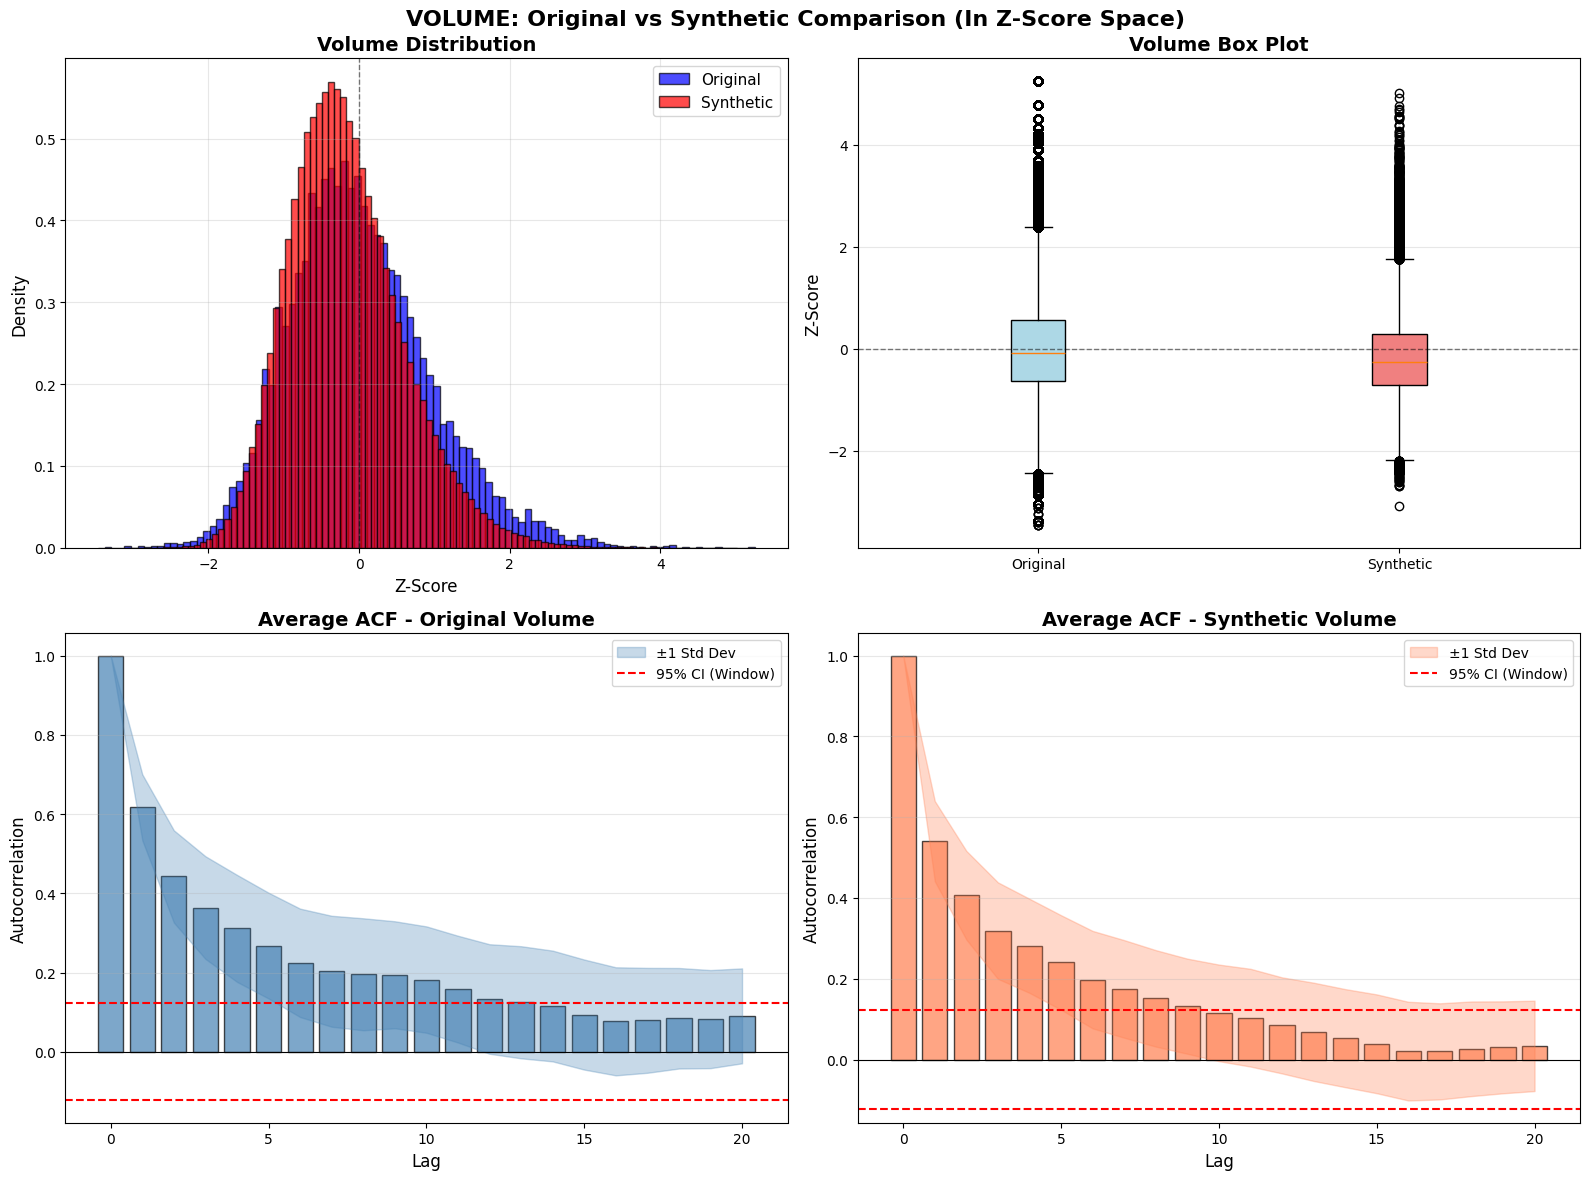


Volume Statistics:
  Original:  Mean=0.012387, Std=0.946517, Min=-3.4647, Max=5.2545
  Synthetic: Mean=-0.175172, Std=0.765061, Min=-3.0824, Max=5.0132
  KS Test: stat=0.103265, p-value=0.000000 ✗ Different

2. LOG RETURNS ANALYSIS - ORIGINAL vs SYNTHETIC

Log Returns Data:
  Original:  2571264 values from 10044 windows of length 256
  Synthetic: 256000 values from 1000 windows of length 256


C:\Users\marco\AppData\Local\Temp\ipykernel_6724\1869038040.py:171: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot([original_ret, synthetic_ret], labels=['Original', 'Synthetic'], patch_artist=True)



Calculating AVERAGE ACF for Original Log Returns (ACF per window, then averaged)...
  Average ACF(1): -0.0381 (±0.1078)
  Average ACF(10): -0.0204 (±0.0611)
Calculating AVERAGE ACF for Synthetic Log Returns (ACF per window, then averaged)...
  Average ACF(1): -0.0182 (±0.0757)
  Average ACF(10): -0.0260 (±0.0663)
  Average ACF(1): -0.0381 (±0.1078)
  Average ACF(10): -0.0204 (±0.0611)
Calculating AVERAGE ACF for Synthetic Log Returns (ACF per window, then averaged)...
  Average ACF(1): -0.0182 (±0.0757)
  Average ACF(10): -0.0260 (±0.0663)


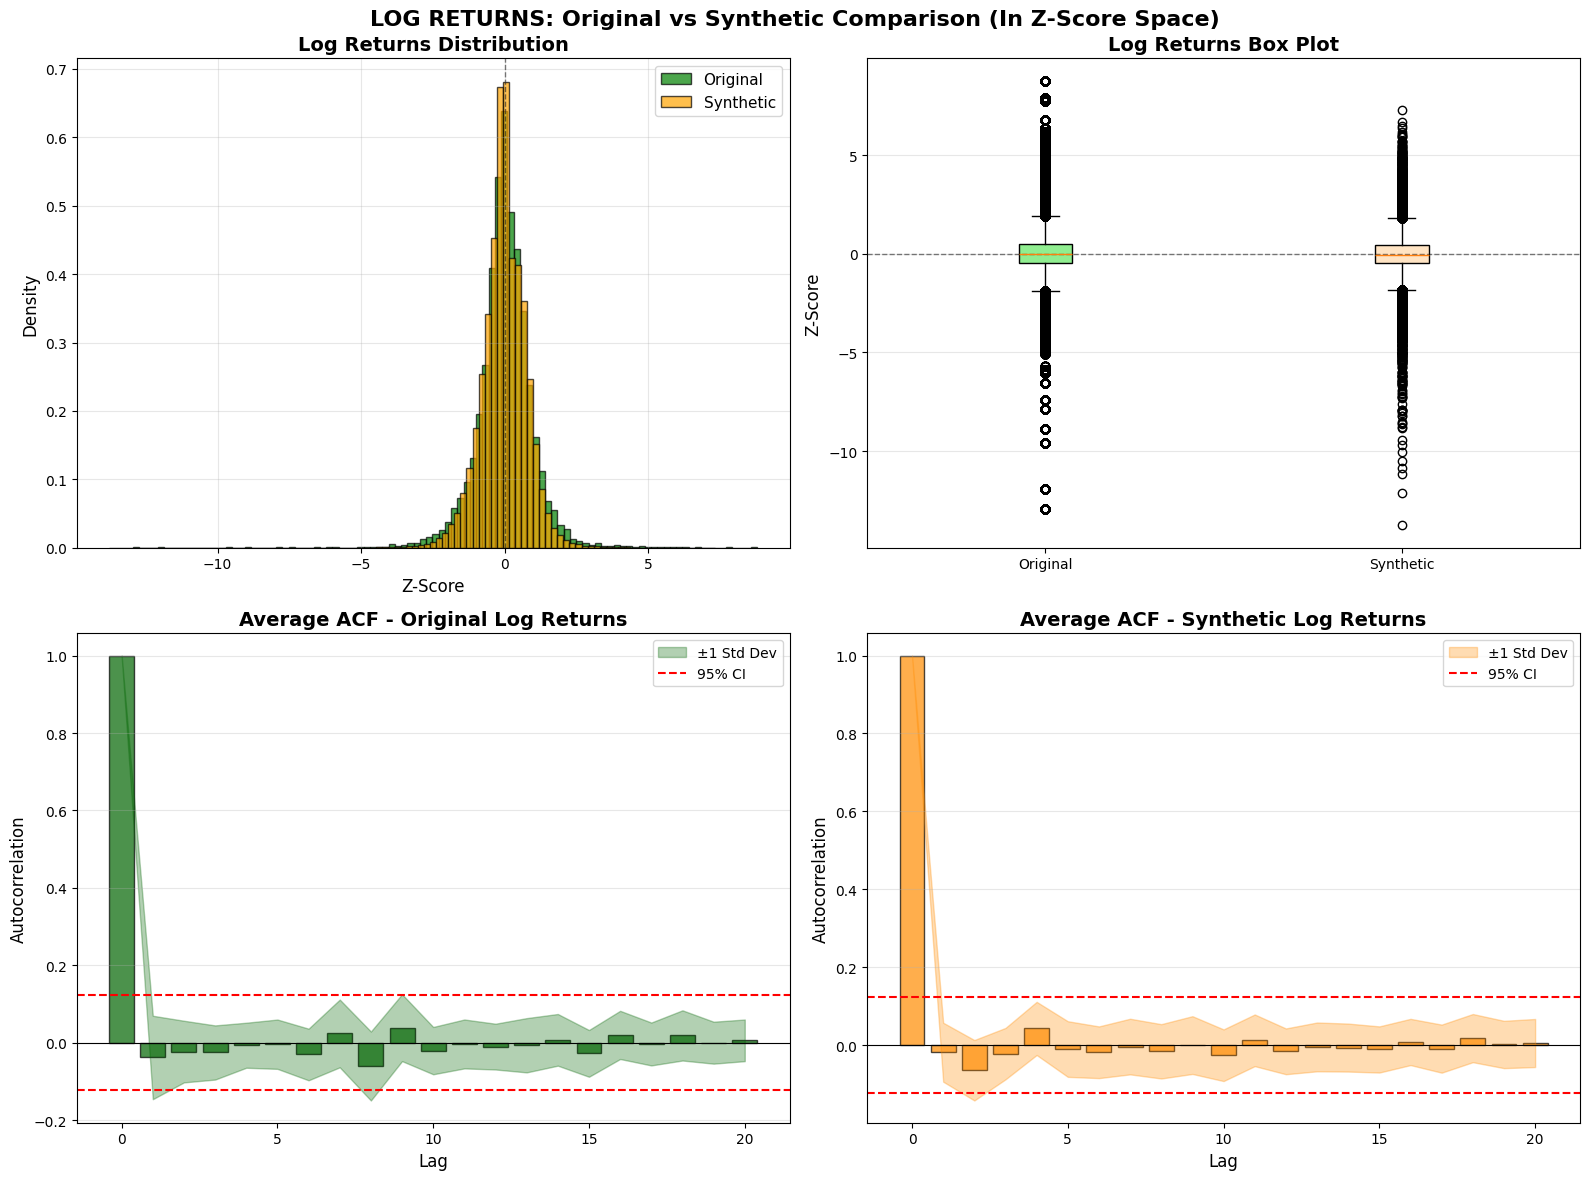


Log Returns Statistics:
  Original:  Mean=0.000120, Std=1.011822, Min=-12.9615, Max=8.7933
  Synthetic: Mean=-0.028315, Std=0.792882, Min=-13.7748, Max=7.3136
  KS Test: stat=0.034164, p-value=0.000000 ✗ Different

3. VOLATILITY ANALYSIS - ORIGINAL vs SYNTHETIC

Volatility Data:
  Original:  2571264 values from 10044 windows of length 256
  Synthetic: 256000 values from 1000 windows of length 256


C:\Users\marco\AppData\Local\Temp\ipykernel_6724\1869038040.py:258: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot([original_vola, synthetic_vola], labels=['Original', 'Synthetic'], patch_artist=True)



Calculating AVERAGE ACF for Original Volatility (ACF per window, then averaged)...
  Average ACF(1): 0.0532 (±0.0816)
  Average ACF(10): 0.0454 (±0.0651)
Calculating AVERAGE ACF for Synthetic Volatility (ACF per window, then averaged)...
  Average ACF(1): 0.0919 (±0.0733)
  Average ACF(10): 0.0368 (±0.0704)
  Average ACF(1): 0.0532 (±0.0816)
  Average ACF(10): 0.0454 (±0.0651)
Calculating AVERAGE ACF for Synthetic Volatility (ACF per window, then averaged)...
  Average ACF(1): 0.0919 (±0.0733)
  Average ACF(10): 0.0368 (±0.0704)


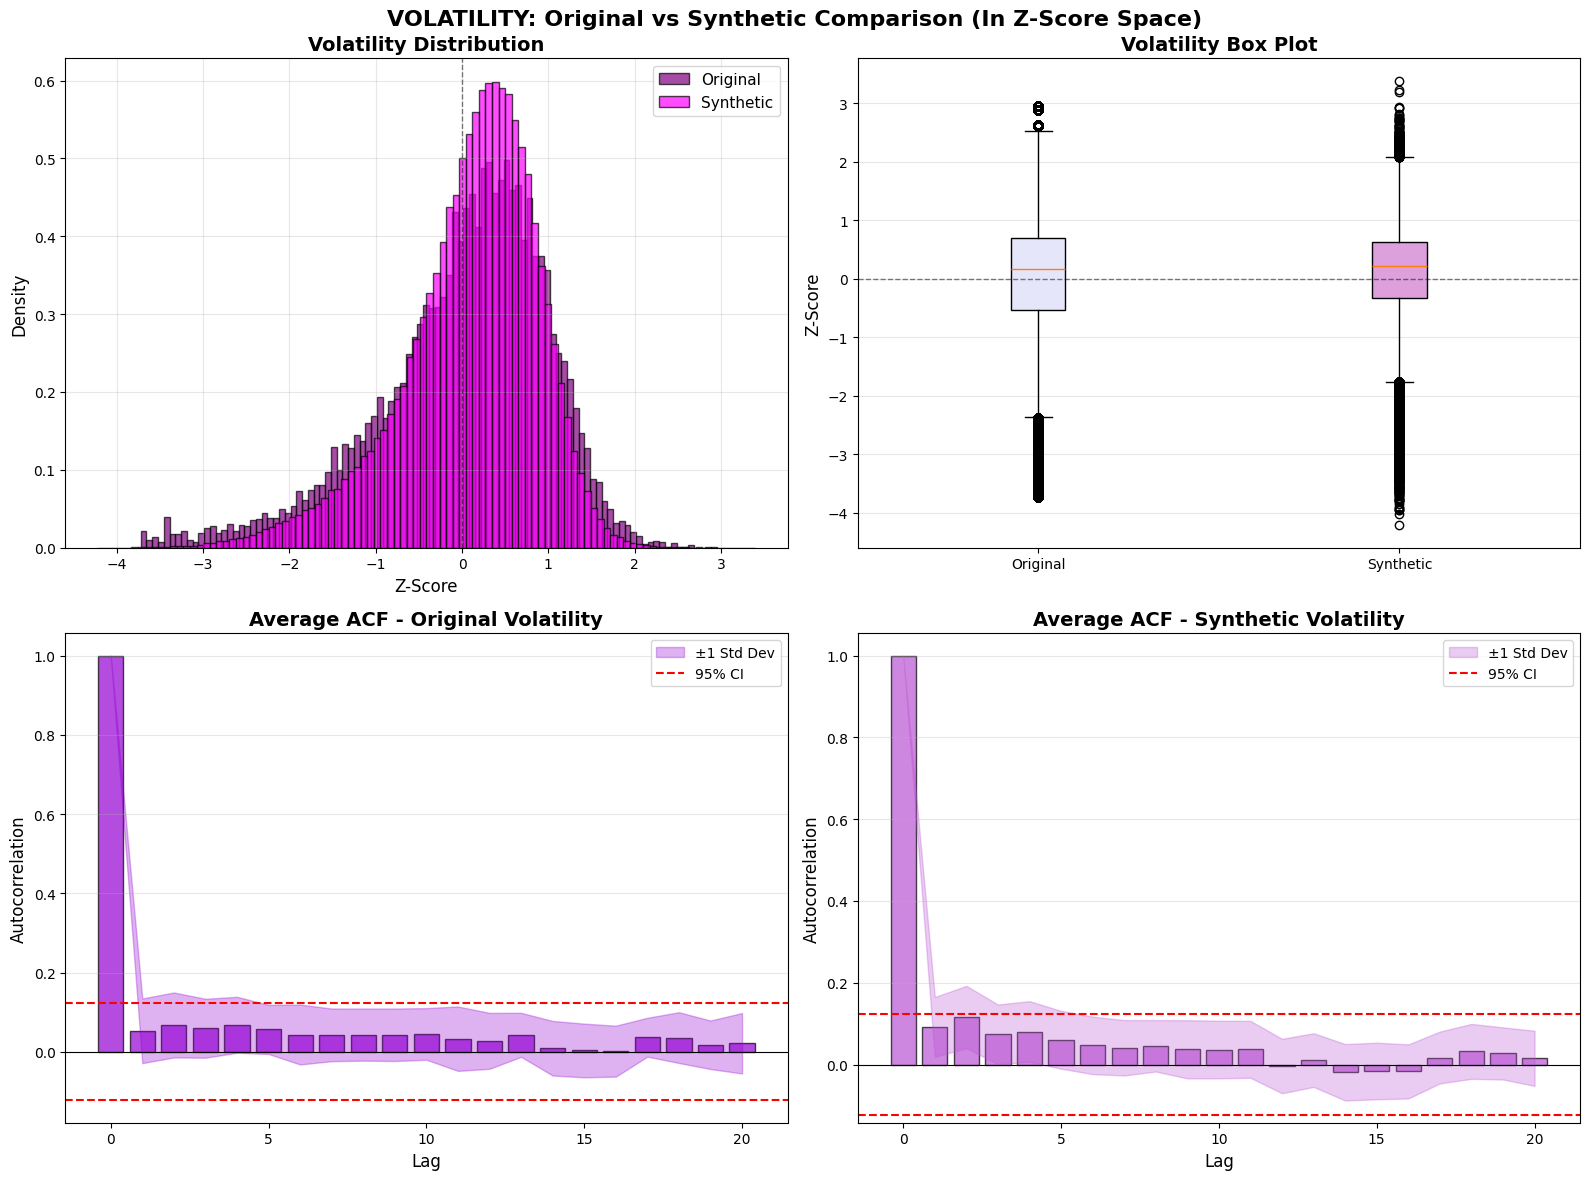


Volatility Statistics:
  Original:  Mean=0.003732, Std=1.004001, Min=-3.7227, Max=2.9531
  Synthetic: Mean=0.095749, Std=0.792704, Min=-4.2166, Max=3.3913
  KS Test: stat=0.065897, p-value=0.000000 ✗ Different

SUMMARY: AVERAGE ACF COMPARISON (NO FALSE CORRELATIONS FROM CONCATENATION)

All ACF values computed per-window independently, then averaged.
This preserves the temporal structure within each window without mixing independent windows.

Average ACF values at key lags:

VOLUME:
  Original:  LAG 1=0.6172 (±0.0831), LAG 10=0.1826 (±0.1342)
  Synthetic: LAG 1=0.5407 (±0.0992), LAG 10=0.1156 (±0.1195)

LOG RETURNS:
  Original:  LAG 1=-0.0381 (±0.1078), LAG 10=-0.0204 (±0.0611)
  Synthetic: LAG 1=-0.0182 (±0.0757), LAG 10=-0.0260 (±0.0663)

VOLATILITY:
  Original:  LAG 1=0.0532 (±0.0816), LAG 10=0.0454 (±0.0651)
  Synthetic: LAG 1=0.0919 (±0.0733), LAG 10=0.0368 (±0.0704)


In [15]:
# Compare distributions and ACF of original vs synthetic for ALL THREE FEATURES
# Comprehensive analysis: Volume, Log Returns, Volatility + Cross-Correlations
# IMPORTANT: Uses AVERAGE ACF (ACF of each window independently, then averaged)
# This avoids false correlations from concatenating independent windows

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.stats import ks_2samp, pearsonr
import seaborn as sns

print("="*80)
print("COMPREHENSIVE COMPARISON: ORIGINAL vs SYNTHETIC (ALL FEATURES)")
print("="*80)

# Verify all data is available
required_vars = [
    'original_zscore_log_volumes', 'synthetic_zscore_log_volumes',
    'original_zscore_log_returns', 'synthetic_zscore_log_returns',
    'original_zscore_volatility', 'synthetic_zscore_volatility'
]

missing = [var for var in required_vars if var not in globals()]
if missing:
    raise RuntimeError(f"Missing variables: {missing}. Run reconstruction cell first.")

# Helper function for Average ACF (CORRECT METHOD - per-window ACF then average)
def calculate_average_acf(windows_data, nlags=20):
    """
    Calculate ACF for each window independently, then average across all windows.
    This avoids false correlations from concatenating independent data.
    
    Parameters:
    - windows_data: shape (n_windows, window_length)
    - nlags: number of lags to compute
    
    Returns:
    - avg_acf: averaged ACF across all windows
    - std_acf: standard deviation of ACF across windows (for uncertainty bands)
    """
    acf_list = []
    
    for i in range(len(windows_data)):
        # Calculate ACF for single window independently
        window_acf = acf(windows_data[i], nlags=nlags, fft=True)
        acf_list.append(window_acf)
    
    # Average across all windows
    avg_acf = np.mean(acf_list, axis=0)
    std_acf = np.std(acf_list, axis=0)
    
    return avg_acf, std_acf

# ============================================================================
# PART 1: VOLUME ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("1. VOLUME ANALYSIS - ORIGINAL vs SYNTHETIC")
print("="*80)

# Flatten windows to get all data points for distribution comparison
original_vol = original_zscore_log_volumes.flatten()
synthetic_vol = synthetic_zscore_log_volumes.flatten()

print(f"\nVolume Data:")
print(f"  Original:  {len(original_vol)} values from {original_zscore_log_volumes.shape[0]} windows of length {original_zscore_log_volumes.shape[1]}")
print(f"  Synthetic: {len(synthetic_vol)} values from {synthetic_zscore_log_volumes.shape[0]} windows of length {synthetic_zscore_log_volumes.shape[1]}")

# Volume: Distribution and ACF comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('VOLUME: Original vs Synthetic Comparison (In Z-Score Space)', fontsize=16, fontweight='bold')

# 1.1 Distribution (on flattened data - correct for pooled distribution)
axes[0, 0].hist(original_vol, bins=100, alpha=0.7, label='Original', color='blue', density=True, edgecolor='black')
axes[0, 0].hist(synthetic_vol, bins=100, alpha=0.7, label='Synthetic', color='red', density=True, edgecolor='black')
axes[0, 0].set_title('Volume Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Z-Score', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 1.2 Box plot
bp = axes[0, 1].boxplot([original_vol, synthetic_vol], labels=['Original', 'Synthetic'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[0, 1].set_title('Volume Box Plot', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Z-Score', fontsize=12)
axes[0, 1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 1.3 ACF Original - AVERAGE ACF (per-window then averaged)
print("\nCalculating AVERAGE ACF for Original Volume (ACF per window, then averaged)...")
acf_orig_vol, acf_orig_vol_std = calculate_average_acf(original_zscore_log_volumes, nlags=20)
axes[1, 0].bar(range(len(acf_orig_vol)), acf_orig_vol, width=0.8, color='steelblue', edgecolor='black', alpha=0.7)
# Add uncertainty band (±1 std)
axes[1, 0].fill_between(range(len(acf_orig_vol)), 
                         acf_orig_vol - acf_orig_vol_std, 
                         acf_orig_vol + acf_orig_vol_std, 
                         alpha=0.3, color='steelblue', label='±1 Std Dev')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 0].axhline(y=1.96/np.sqrt(original_zscore_log_volumes.shape[1]), color='red', linestyle='--', linewidth=1.5, label='95% CI (Window)')
axes[1, 0].axhline(y=-1.96/np.sqrt(original_zscore_log_volumes.shape[1]), color='red', linestyle='--', linewidth=1.5)
axes[1, 0].set_title('Average ACF - Original Volume', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Lag', fontsize=12)
axes[1, 0].set_ylabel('Autocorrelation', fontsize=12)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')
print(f"  Average ACF(1): {acf_orig_vol[1]:.4f} (±{acf_orig_vol_std[1]:.4f})")
print(f"  Average ACF(10): {acf_orig_vol[10]:.4f} (±{acf_orig_vol_std[10]:.4f})")

# 1.4 ACF Synthetic - AVERAGE ACF (per-window then averaged)
print("Calculating AVERAGE ACF for Synthetic Volume (ACF per window, then averaged)...")
acf_syn_vol, acf_syn_vol_std = calculate_average_acf(synthetic_zscore_log_volumes, nlags=20)
axes[1, 1].bar(range(len(acf_syn_vol)), acf_syn_vol, width=0.8, color='coral', edgecolor='black', alpha=0.7)
# Add uncertainty band (±1 std)
axes[1, 1].fill_between(range(len(acf_syn_vol)), 
                         acf_syn_vol - acf_syn_vol_std, 
                         acf_syn_vol + acf_syn_vol_std, 
                         alpha=0.3, color='coral', label='±1 Std Dev')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 1].axhline(y=1.96/np.sqrt(synthetic_zscore_log_volumes.shape[1]), color='red', linestyle='--', linewidth=1.5, label='95% CI (Window)')
axes[1, 1].axhline(y=-1.96/np.sqrt(synthetic_zscore_log_volumes.shape[1]), color='red', linestyle='--', linewidth=1.5)
axes[1, 1].set_title('Average ACF - Synthetic Volume', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Lag', fontsize=12)
axes[1, 1].set_ylabel('Autocorrelation', fontsize=12)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')
print(f"  Average ACF(1): {acf_syn_vol[1]:.4f} (±{acf_syn_vol_std[1]:.4f})")
print(f"  Average ACF(10): {acf_syn_vol[10]:.4f} (±{acf_syn_vol_std[10]:.4f})")

plt.tight_layout()
plt.show()

# Volume statistics
ks_vol, p_vol = ks_2samp(original_vol, synthetic_vol)
print(f"\nVolume Statistics:")
print(f"  Original:  Mean={original_vol.mean():.6f}, Std={original_vol.std():.6f}, Min={original_vol.min():.4f}, Max={original_vol.max():.4f}")
print(f"  Synthetic: Mean={synthetic_vol.mean():.6f}, Std={synthetic_vol.std():.6f}, Min={synthetic_vol.min():.4f}, Max={synthetic_vol.max():.4f}")
print(f"  KS Test: stat={ks_vol:.6f}, p-value={p_vol:.6f} {'✓ Similar' if p_vol > 0.05 else '✗ Different'}")

# ============================================================================
# PART 2: LOG RETURNS ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("2. LOG RETURNS ANALYSIS - ORIGINAL vs SYNTHETIC")
print("="*80)

original_ret = original_zscore_log_returns.flatten()
synthetic_ret = synthetic_zscore_log_returns.flatten()

print(f"\nLog Returns Data:")
print(f"  Original:  {len(original_ret)} values from {original_zscore_log_returns.shape[0]} windows of length {original_zscore_log_returns.shape[1]}")
print(f"  Synthetic: {len(synthetic_ret)} values from {synthetic_zscore_log_returns.shape[0]} windows of length {synthetic_zscore_log_returns.shape[1]}")

# Log Returns: Distribution and ACF
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('LOG RETURNS: Original vs Synthetic Comparison (In Z-Score Space)', fontsize=16, fontweight='bold')

# 2.1 Distribution
axes[0, 0].hist(original_ret, bins=100, alpha=0.7, label='Original', color='green', density=True, edgecolor='black')
axes[0, 0].hist(synthetic_ret, bins=100, alpha=0.7, label='Synthetic', color='orange', density=True, edgecolor='black')
axes[0, 0].set_title('Log Returns Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Z-Score', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2.2 Box plot
bp = axes[0, 1].boxplot([original_ret, synthetic_ret], labels=['Original', 'Synthetic'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('bisque')
axes[0, 1].set_title('Log Returns Box Plot', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Z-Score', fontsize=12)
axes[0, 1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 2.3 ACF Original - AVERAGE ACF
print("\nCalculating AVERAGE ACF for Original Log Returns (ACF per window, then averaged)...")
acf_orig_ret, acf_orig_ret_std = calculate_average_acf(original_zscore_log_returns, nlags=20)
axes[1, 0].bar(range(len(acf_orig_ret)), acf_orig_ret, width=0.8, color='darkgreen', edgecolor='black', alpha=0.7)
# Add uncertainty band (±1 std)
axes[1, 0].fill_between(range(len(acf_orig_ret)), 
                         acf_orig_ret - acf_orig_ret_std, 
                         acf_orig_ret + acf_orig_ret_std, 
                         alpha=0.3, color='darkgreen', label='±1 Std Dev')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 0].axhline(y=1.96/np.sqrt(original_zscore_log_returns.shape[1]), color='red', linestyle='--', linewidth=1.5, label='95% CI')
axes[1, 0].axhline(y=-1.96/np.sqrt(original_zscore_log_returns.shape[1]), color='red', linestyle='--', linewidth=1.5)
axes[1, 0].set_title('Average ACF - Original Log Returns', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Lag', fontsize=12)
axes[1, 0].set_ylabel('Autocorrelation', fontsize=12)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')
print(f"  Average ACF(1): {acf_orig_ret[1]:.4f} (±{acf_orig_ret_std[1]:.4f})")
print(f"  Average ACF(10): {acf_orig_ret[10]:.4f} (±{acf_orig_ret_std[10]:.4f})")

# 2.4 ACF Synthetic - AVERAGE ACF
print("Calculating AVERAGE ACF for Synthetic Log Returns (ACF per window, then averaged)...")
acf_syn_ret, acf_syn_ret_std = calculate_average_acf(synthetic_zscore_log_returns, nlags=20)
axes[1, 1].bar(range(len(acf_syn_ret)), acf_syn_ret, width=0.8, color='darkorange', edgecolor='black', alpha=0.7)
# Add uncertainty band (±1 std)
axes[1, 1].fill_between(range(len(acf_syn_ret)), 
                         acf_syn_ret - acf_syn_ret_std, 
                         acf_syn_ret + acf_syn_ret_std, 
                         alpha=0.3, color='darkorange', label='±1 Std Dev')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 1].axhline(y=1.96/np.sqrt(synthetic_zscore_log_returns.shape[1]), color='red', linestyle='--', linewidth=1.5, label='95% CI')
axes[1, 1].axhline(y=-1.96/np.sqrt(synthetic_zscore_log_returns.shape[1]), color='red', linestyle='--', linewidth=1.5)
axes[1, 1].set_title('Average ACF - Synthetic Log Returns', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Lag', fontsize=12)
axes[1, 1].set_ylabel('Autocorrelation', fontsize=12)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')
print(f"  Average ACF(1): {acf_syn_ret[1]:.4f} (±{acf_syn_ret_std[1]:.4f})")
print(f"  Average ACF(10): {acf_syn_ret[10]:.4f} (±{acf_syn_ret_std[10]:.4f})")

plt.tight_layout()
plt.show()

# Log Returns statistics
ks_ret, p_ret = ks_2samp(original_ret, synthetic_ret)
print(f"\nLog Returns Statistics:")
print(f"  Original:  Mean={original_ret.mean():.6f}, Std={original_ret.std():.6f}, Min={original_ret.min():.4f}, Max={original_ret.max():.4f}")
print(f"  Synthetic: Mean={synthetic_ret.mean():.6f}, Std={synthetic_ret.std():.6f}, Min={synthetic_ret.min():.4f}, Max={synthetic_ret.max():.4f}")
print(f"  KS Test: stat={ks_ret:.6f}, p-value={p_ret:.6f} {'✓ Similar' if p_ret > 0.05 else '✗ Different'}")

# ============================================================================
# PART 3: VOLATILITY ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("3. VOLATILITY ANALYSIS - ORIGINAL vs SYNTHETIC")
print("="*80)

original_vola = original_zscore_volatility.flatten()
synthetic_vola = synthetic_zscore_volatility.flatten()

print(f"\nVolatility Data:")
print(f"  Original:  {len(original_vola)} values from {original_zscore_volatility.shape[0]} windows of length {original_zscore_volatility.shape[1]}")
print(f"  Synthetic: {len(synthetic_vola)} values from {synthetic_zscore_volatility.shape[0]} windows of length {synthetic_zscore_volatility.shape[1]}")

# Volatility: Distribution and ACF
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('VOLATILITY: Original vs Synthetic Comparison (In Z-Score Space)', fontsize=16, fontweight='bold')

# 3.1 Distribution
axes[0, 0].hist(original_vola, bins=100, alpha=0.7, label='Original', color='purple', density=True, edgecolor='black')
axes[0, 0].hist(synthetic_vola, bins=100, alpha=0.7, label='Synthetic', color='magenta', density=True, edgecolor='black')
axes[0, 0].set_title('Volatility Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Z-Score', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 3.2 Box plot
bp = axes[0, 1].boxplot([original_vola, synthetic_vola], labels=['Original', 'Synthetic'], patch_artist=True)
bp['boxes'][0].set_facecolor('lavender')
bp['boxes'][1].set_facecolor('plum')
axes[0, 1].set_title('Volatility Box Plot', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Z-Score', fontsize=12)
axes[0, 1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3.3 ACF Original - AVERAGE ACF
print("\nCalculating AVERAGE ACF for Original Volatility (ACF per window, then averaged)...")
acf_orig_vola, acf_orig_vola_std = calculate_average_acf(original_zscore_volatility, nlags=20)
axes[1, 0].bar(range(len(acf_orig_vola)), acf_orig_vola, width=0.8, color='darkviolet', edgecolor='black', alpha=0.7)
# Add uncertainty band (±1 std)
axes[1, 0].fill_between(range(len(acf_orig_vola)), 
                         acf_orig_vola - acf_orig_vola_std, 
                         acf_orig_vola + acf_orig_vola_std, 
                         alpha=0.3, color='darkviolet', label='±1 Std Dev')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 0].axhline(y=1.96/np.sqrt(original_zscore_volatility.shape[1]), color='red', linestyle='--', linewidth=1.5, label='95% CI')
axes[1, 0].axhline(y=-1.96/np.sqrt(original_zscore_volatility.shape[1]), color='red', linestyle='--', linewidth=1.5)
axes[1, 0].set_title('Average ACF - Original Volatility', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Lag', fontsize=12)
axes[1, 0].set_ylabel('Autocorrelation', fontsize=12)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')
print(f"  Average ACF(1): {acf_orig_vola[1]:.4f} (±{acf_orig_vola_std[1]:.4f})")
print(f"  Average ACF(10): {acf_orig_vola[10]:.4f} (±{acf_orig_vola_std[10]:.4f})")

# 3.4 ACF Synthetic - AVERAGE ACF
print("Calculating AVERAGE ACF for Synthetic Volatility (ACF per window, then averaged)...")
acf_syn_vola, acf_syn_vola_std = calculate_average_acf(synthetic_zscore_volatility, nlags=20)
axes[1, 1].bar(range(len(acf_syn_vola)), acf_syn_vola, width=0.8, color='mediumorchid', edgecolor='black', alpha=0.7)
# Add uncertainty band (±1 std)
axes[1, 1].fill_between(range(len(acf_syn_vola)), 
                         acf_syn_vola - acf_syn_vola_std, 
                         acf_syn_vola + acf_syn_vola_std, 
                         alpha=0.3, color='mediumorchid', label='±1 Std Dev')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 1].axhline(y=1.96/np.sqrt(synthetic_zscore_volatility.shape[1]), color='red', linestyle='--', linewidth=1.5, label='95% CI')
axes[1, 1].axhline(y=-1.96/np.sqrt(synthetic_zscore_volatility.shape[1]), color='red', linestyle='--', linewidth=1.5)
axes[1, 1].set_title('Average ACF - Synthetic Volatility', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Lag', fontsize=12)
axes[1, 1].set_ylabel('Autocorrelation', fontsize=12)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')
print(f"  Average ACF(1): {acf_syn_vola[1]:.4f} (±{acf_syn_vola_std[1]:.4f})")
print(f"  Average ACF(10): {acf_syn_vola[10]:.4f} (±{acf_syn_vola_std[10]:.4f})")

plt.tight_layout()
plt.show()

# Volatility statistics
ks_vola, p_vola = ks_2samp(original_vola, synthetic_vola)
print(f"\nVolatility Statistics:")
print(f"  Original:  Mean={original_vola.mean():.6f}, Std={original_vola.std():.6f}, Min={original_vola.min():.4f}, Max={original_vola.max():.4f}")
print(f"  Synthetic: Mean={synthetic_vola.mean():.6f}, Std={synthetic_vola.std():.6f}, Min={synthetic_vola.min():.4f}, Max={synthetic_vola.max():.4f}")
print(f"  KS Test: stat={ks_vola:.6f}, p-value={p_vola:.6f} {'✓ Similar' if p_vola > 0.05 else '✗ Different'}")

print("\n" + "="*80)
print("SUMMARY: AVERAGE ACF COMPARISON (NO FALSE CORRELATIONS FROM CONCATENATION)")
print("="*80)
print("\nAll ACF values computed per-window independently, then averaged.")
print("This preserves the temporal structure within each window without mixing independent windows.")
print("\nAverage ACF values at key lags:")
print(f"\nVOLUME:")
print(f"  Original:  LAG 1={acf_orig_vol[1]:.4f} (±{acf_orig_vol_std[1]:.4f}), LAG 10={acf_orig_vol[10]:.4f} (±{acf_orig_vol_std[10]:.4f})")
print(f"  Synthetic: LAG 1={acf_syn_vol[1]:.4f} (±{acf_syn_vol_std[1]:.4f}), LAG 10={acf_syn_vol[10]:.4f} (±{acf_syn_vol_std[10]:.4f})")
print(f"\nLOG RETURNS:")
print(f"  Original:  LAG 1={acf_orig_ret[1]:.4f} (±{acf_orig_ret_std[1]:.4f}), LAG 10={acf_orig_ret[10]:.4f} (±{acf_orig_ret_std[10]:.4f})")
print(f"  Synthetic: LAG 1={acf_syn_ret[1]:.4f} (±{acf_syn_ret_std[1]:.4f}), LAG 10={acf_syn_ret[10]:.4f} (±{acf_syn_ret_std[10]:.4f})")
print(f"\nVOLATILITY:")
print(f"  Original:  LAG 1={acf_orig_vola[1]:.4f} (±{acf_orig_vola_std[1]:.4f}), LAG 10={acf_orig_vola[10]:.4f} (±{acf_orig_vola_std[10]:.4f})")
print(f"  Synthetic: LAG 1={acf_syn_vola[1]:.4f} (±{acf_syn_vola_std[1]:.4f}), LAG 10={acf_syn_vola[10]:.4f} (±{acf_syn_vola_std[10]:.4f})")

ADVANCED ANALYSIS: CROSS-CORRELATION & DETAILED COMPARISON

DATA PREPARATION

ORIGINAL DATA: Full ticker series (pre-windowing)
  Volume:     11064 total points across 4 tickers
  Log Returns: 11064 total points across 4 tickers
  Volatility:  11064 total points across 4 tickers

SYNTHETIC DATA: Reconstructed windows (flattened)
  Volume:     256000 total points from 1000 windows
  Log Returns: 256000 total points from 1000 windows
  Volatility:  256000 total points from 1000 windows

PART 1: ORIGINAL DATA - AVERAGE ACF BETWEEN TICKERS

Volume - ACF per ticker:
  AAPL: ACF(1)=0.8457, ACF(10)=0.6832
  META: ACF(1)=0.7797, ACF(10)=0.4741
  MSFT: ACF(1)=0.6624, ACF(10)=0.3221
  AMZN: ACF(1)=0.7253, ACF(10)=0.4204

Log Returns - ACF per ticker:
  AAPL: ACF(1)=-0.0606, ACF(10)=-0.0299
  META: ACF(1)=-0.0348, ACF(10)=-0.0281
  MSFT: ACF(1)=-0.1328, ACF(10)=-0.0293
  AMZN: ACF(1)=-0.0119, ACF(10)=-0.0265

Volatility - ACF per ticker:
  AAPL: ACF(1)=0.0994, ACF(10)=0.0863
  META: ACF(1)=0.0746

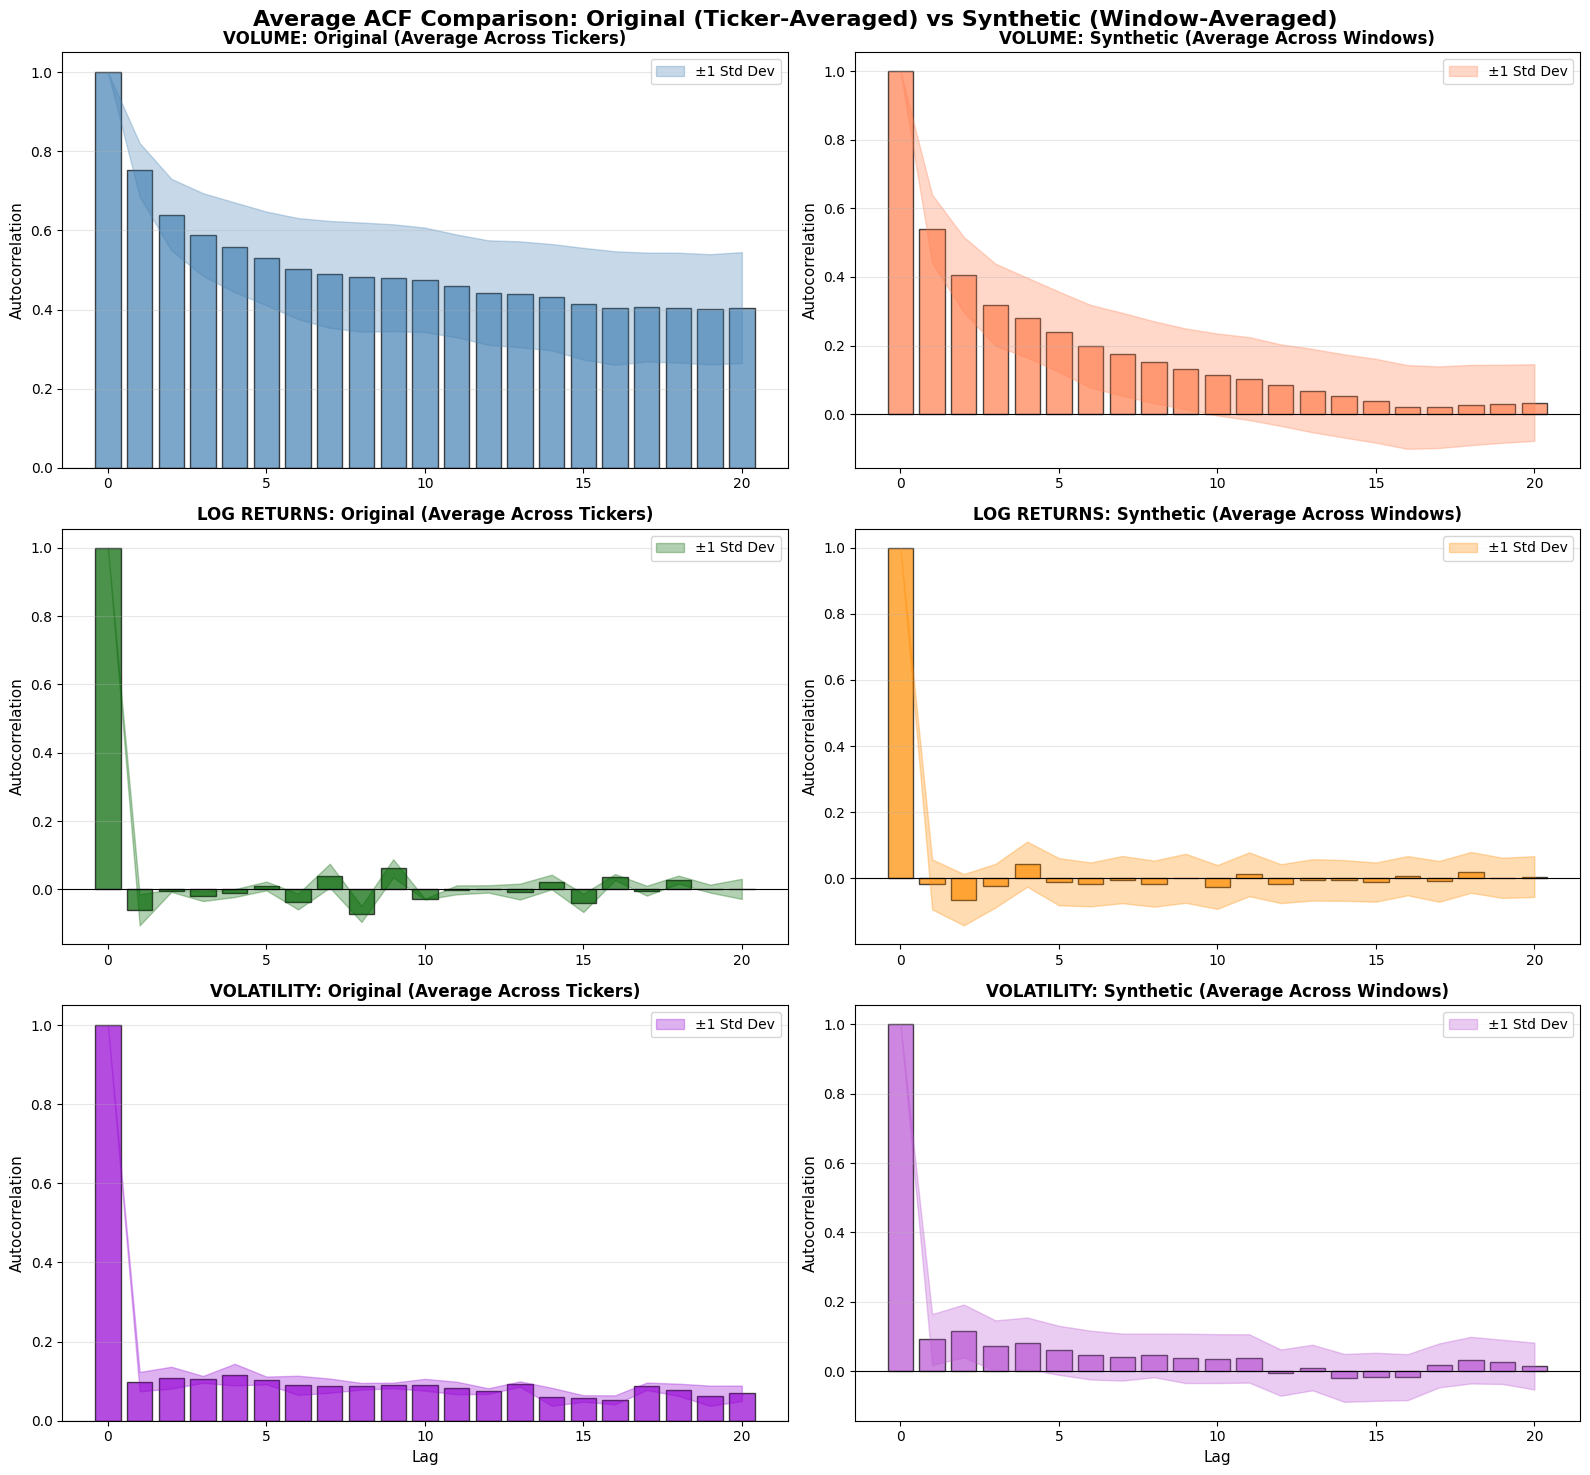


PART 4: DISTRIBUTION COMPARISON (POOLED DATA)


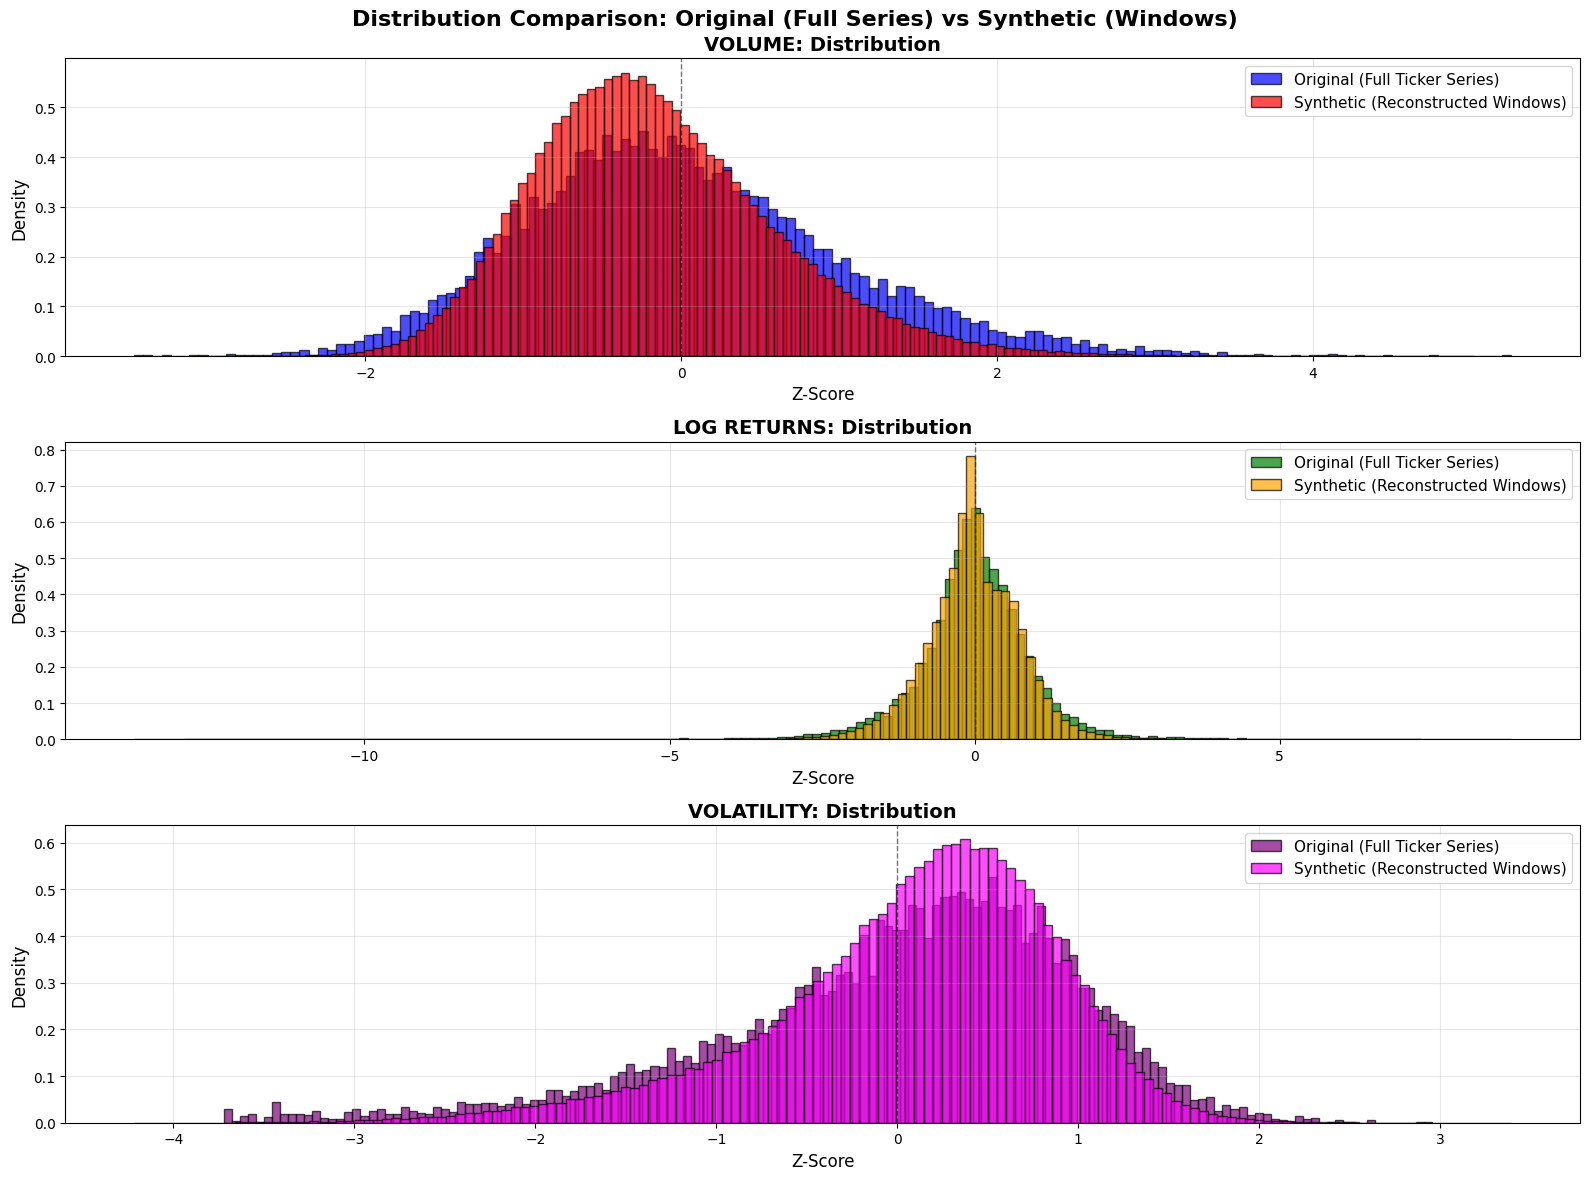


PART 5: STATISTICAL TESTS (KS TEST)
Note: Downsampling data to max 5000 points for KS test to avoid MemoryError and ensure statistical relevance.


ValueError: a must be 1-dimensional

In [ ]:
# Cross-Correlation and Advanced Analysis
# ORIGINAL: Uses full ticker series (pre-windowing) + Average ACF between tickers
# SYNTHETIC: Uses reconstructed windows + Average ACF between windows

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.stats import ks_2samp, pearsonr
import seaborn as sns

print("="*80)
print("ADVANCED ANALYSIS: CROSS-CORRELATION & DETAILED COMPARISON")
print("="*80)

# ============================================================================
# PREPARE DATA: Original (full series) vs Synthetic (windows)
# ============================================================================

print("\n" + "="*80)
print("DATA PREPARATION")
print("="*80)

# ORIGINAL DATA: Use full ticker series (before windowing)
print("\nORIGINAL DATA: Full ticker series (pre-windowing)")
original_vol_full = np.concatenate([ticker_zscore_volumes[ticker] for ticker in tickers]).flatten()
original_ret_full = np.concatenate([ticker_zscore_log_returns[ticker] for ticker in tickers]).flatten()
original_vola_full = np.concatenate([ticker_zscore_volatility[ticker] for ticker in tickers]).flatten()

print(f"  Volume:     {len(original_vol_full)} total points across {len(tickers)} tickers")
print(f"  Log Returns: {len(original_ret_full)} total points across {len(tickers)} tickers")
print(f"  Volatility:  {len(original_vola_full)} total points across {len(tickers)} tickers")

# SYNTHETIC DATA: Use reconstructed windows (flattened)
print("\nSYNTHETIC DATA: Reconstructed windows (flattened)")
synthetic_vol_flat = synthetic_zscore_log_volumes.flatten()
synthetic_ret_flat = synthetic_zscore_log_returns.flatten()
synthetic_vola_flat = synthetic_zscore_volatility.flatten()

print(f"  Volume:     {len(synthetic_vol_flat)} total points from {len(synthetic_zscore_log_volumes)} windows")
print(f"  Log Returns: {len(synthetic_ret_flat)} total points from {len(synthetic_zscore_log_returns)} windows")
print(f"  Volatility:  {len(synthetic_vola_flat)} total points from {len(synthetic_zscore_volatility)} windows")

# ============================================================================
# PART 1: ORIGINAL DATA - AVERAGE ACF BETWEEN TICKERS
# ============================================================================

print("\n" + "="*80)
print("PART 1: ORIGINAL DATA - AVERAGE ACF BETWEEN TICKERS")
print("="*80)

def calculate_ticker_average_acf(ticker_dict, tickers, nlags=20):
    """
    Calculate ACF for each ticker independently, then average across tickers.
    
    Parameters:
    - ticker_dict: dictionary with ticker_name -> full series
    - tickers: list of ticker names
    - nlags: number of lags
    
    Returns:
    - avg_acf: averaged ACF across tickers
    - std_acf: standard deviation of ACF across tickers
    """
    acf_list = []
    
    for ticker in tickers:
        series = ticker_dict[ticker]
        ticker_acf = acf(series, nlags=nlags, fft=True)
        acf_list.append(ticker_acf)
        print(f"  {ticker}: ACF(1)={ticker_acf[1]:.4f}, ACF(10)={ticker_acf[10]:.4f}")
    
    avg_acf = np.mean(acf_list, axis=0)
    std_acf = np.std(acf_list, axis=0)
    
    return avg_acf, std_acf

# Calculate average ACF for each feature across tickers
print("\nVolume - ACF per ticker:")
acf_orig_vol_ticker, acf_orig_vol_ticker_std = calculate_ticker_average_acf(ticker_zscore_volumes, tickers, nlags=20)

print("\nLog Returns - ACF per ticker:")
acf_orig_ret_ticker, acf_orig_ret_ticker_std = calculate_ticker_average_acf(ticker_zscore_log_returns, tickers, nlags=20)

print("\nVolatility - ACF per ticker:")
acf_orig_vola_ticker, acf_orig_vola_ticker_std = calculate_ticker_average_acf(ticker_zscore_volatility, tickers, nlags=20)

# ============================================================================
# PART 2: SYNTHETIC DATA - AVERAGE ACF BETWEEN WINDOWS
# ============================================================================

print("\n" + "="*80)
print("PART 2: SYNTHETIC DATA - AVERAGE ACF BETWEEN WINDOWS")
print("="*80)

def calculate_window_average_acf(windows_data, nlags=20):
    """Calculate ACF for each window independently, then average across windows."""
    acf_list = []
    
    for i in range(len(windows_data)):
        window_acf = acf(windows_data[i], nlags=nlags, fft=True)
        acf_list.append(window_acf)
    
    avg_acf = np.mean(acf_list, axis=0)
    std_acf = np.std(acf_list, axis=0)
    
    return avg_acf, std_acf

print("\nCalculating AVERAGE ACF for synthetic windows...")

acf_syn_vol_window, acf_syn_vol_window_std = calculate_window_average_acf(synthetic_zscore_log_volumes, nlags=20)
print(f"Volume:      ACF(1)={acf_syn_vol_window[1]:.4f} (±{acf_syn_vol_window_std[1]:.4f}), ACF(10)={acf_syn_vol_window[10]:.4f} (±{acf_syn_vol_window_std[10]:.4f})")

acf_syn_ret_window, acf_syn_ret_window_std = calculate_window_average_acf(synthetic_zscore_log_returns, nlags=20)
print(f"Log Returns: ACF(1)={acf_syn_ret_window[1]:.4f} (±{acf_syn_ret_window_std[1]:.4f}), ACF(10)={acf_syn_ret_window[10]:.4f} (±{acf_syn_ret_window_std[10]:.4f})")

acf_syn_vola_window, acf_syn_vola_window_std = calculate_window_average_acf(synthetic_zscore_volatility, nlags=20)
print(f"Volatility:  ACF(1)={acf_syn_vola_window[1]:.4f} (±{acf_syn_vola_window_std[1]:.4f}), ACF(10)={acf_syn_vola_window[10]:.4f} (±{acf_syn_vola_window_std[10]:.4f})")

# ============================================================================
# PART 3: ACF COMPARISON VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("PART 3: ACF COMPARISON (ORIGINAL vs SYNTHETIC)")
print("="*80)

fig, axes = plt.subplots(3, 2, figsize=(16, 15))
fig.suptitle('Average ACF Comparison: Original (Ticker-Averaged) vs Synthetic (Window-Averaged)', fontsize=16, fontweight='bold')

# Volume
axes[0, 0].bar(range(len(acf_orig_vol_ticker)), acf_orig_vol_ticker, width=0.8, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].fill_between(range(len(acf_orig_vol_ticker)), 
                         acf_orig_vol_ticker - acf_orig_vol_ticker_std, 
                         acf_orig_vol_ticker + acf_orig_vol_ticker_std, 
                         alpha=0.3, color='steelblue', label='±1 Std Dev')
axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[0, 0].set_title('VOLUME: Original (Average Across Tickers)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Autocorrelation', fontsize=11)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].legend(fontsize=10)

axes[0, 1].bar(range(len(acf_syn_vol_window)), acf_syn_vol_window, width=0.8, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].fill_between(range(len(acf_syn_vol_window)), 
                         acf_syn_vol_window - acf_syn_vol_window_std, 
                         acf_syn_vol_window + acf_syn_vol_window_std, 
                         alpha=0.3, color='coral', label='±1 Std Dev')
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[0, 1].set_title('VOLUME: Synthetic (Average Across Windows)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Autocorrelation', fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].legend(fontsize=10)

# Log Returns
axes[1, 0].bar(range(len(acf_orig_ret_ticker)), acf_orig_ret_ticker, width=0.8, color='darkgreen', edgecolor='black', alpha=0.7)
axes[1, 0].fill_between(range(len(acf_orig_ret_ticker)), 
                         acf_orig_ret_ticker - acf_orig_ret_ticker_std, 
                         acf_orig_ret_ticker + acf_orig_ret_ticker_std, 
                         alpha=0.3, color='darkgreen', label='±1 Std Dev')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 0].set_title('LOG RETURNS: Original (Average Across Tickers)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Autocorrelation', fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].legend(fontsize=10)

axes[1, 1].bar(range(len(acf_syn_ret_window)), acf_syn_ret_window, width=0.8, color='darkorange', edgecolor='black', alpha=0.7)
axes[1, 1].fill_between(range(len(acf_syn_ret_window)), 
                         acf_syn_ret_window - acf_syn_ret_window_std, 
                         acf_syn_ret_window + acf_syn_ret_window_std, 
                         alpha=0.3, color='darkorange', label='±1 Std Dev')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 1].set_title('LOG RETURNS: Synthetic (Average Across Windows)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Autocorrelation', fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].legend(fontsize=10)

# Volatility
axes[2, 0].bar(range(len(acf_orig_vola_ticker)), acf_orig_vola_ticker, width=0.8, color='darkviolet', edgecolor='black', alpha=0.7)
axes[2, 0].fill_between(range(len(acf_orig_vola_ticker)), 
                         acf_orig_vola_ticker - acf_orig_vola_ticker_std, 
                         acf_orig_vola_ticker + acf_orig_vola_ticker_std, 
                         alpha=0.3, color='darkviolet', label='±1 Std Dev')
axes[2, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[2, 0].set_title('VOLATILITY: Original (Average Across Tickers)', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Lag', fontsize=11)
axes[2, 0].set_ylabel('Autocorrelation', fontsize=11)
axes[2, 0].grid(True, alpha=0.3, axis='y')
axes[2, 0].legend(fontsize=10)

axes[2, 1].bar(range(len(acf_syn_vola_window)), acf_syn_vola_window, width=0.8, color='mediumorchid', edgecolor='black', alpha=0.7)
axes[2, 1].fill_between(range(len(acf_syn_vola_window)), 
                         acf_syn_vola_window - acf_syn_vola_window_std, 
                         acf_syn_vola_window + acf_syn_vola_window_std, 
                         alpha=0.3, color='mediumorchid', label='±1 Std Dev')
axes[2, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[2, 1].set_title('VOLATILITY: Synthetic (Average Across Windows)', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Lag', fontsize=11)
axes[2, 1].set_ylabel('Autocorrelation', fontsize=11)
axes[2, 1].grid(True, alpha=0.3, axis='y')
axes[2, 1].legend(fontsize=10)

plt.tight_layout()
plt.show()

# ============================================================================
# PART 4: DISTRIBUTION COMPARISON (pooled data)
# ============================================================================

print("\n" + "="*80)
print("PART 4: DISTRIBUTION COMPARISON (POOLED DATA)")
print("="*80)

fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Distribution Comparison: Original (Full Series) vs Synthetic (Windows)', fontsize=16, fontweight='bold')

# Volume distributions
axes[0].hist(original_vol_full, bins=150, alpha=0.7, label='Original (Full Ticker Series)', color='blue', density=True, edgecolor='black')
axes[0].hist(synthetic_vol_flat, bins=150, alpha=0.7, label='Synthetic (Reconstructed Windows)', color='red', density=True, edgecolor='black')
axes[0].set_title('VOLUME: Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Z-Score', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Log Returns distributions
axes[1].hist(original_ret_full, bins=150, alpha=0.7, label='Original (Full Ticker Series)', color='green', density=True, edgecolor='black')
axes[1].hist(synthetic_ret_flat, bins=150, alpha=0.7, label='Synthetic (Reconstructed Windows)', color='orange', density=True, edgecolor='black')
axes[1].set_title('LOG RETURNS: Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Z-Score', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Volatility distributions
axes[2].hist(original_vola_full, bins=150, alpha=0.7, label='Original (Full Ticker Series)', color='purple', density=True, edgecolor='black')
axes[2].hist(synthetic_vola_flat, bins=150, alpha=0.7, label='Synthetic (Reconstructed Windows)', color='magenta', density=True, edgecolor='black')
axes[2].set_title('VOLATILITY: Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Z-Score', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# PART 5: STATISTICAL TESTS
# ============================================================================

print("\n" + "="*80)
print("PART 5: STATISTICAL TESTS (KS TEST)")
print("="*80)

# FIX MEMORY ERROR: Downsample large datasets for KS test
# KS test on 250k+ points causes MemoryError in scipy and is too sensitive
KS_SAMPLE_SIZE = 5000 
print(f"Note: Downsampling data to max {KS_SAMPLE_SIZE} points for KS test to avoid MemoryError and ensure statistical relevance.")

def subsample_for_ks(data1, data2, n_samples=5000):
    """Subsample arrays if they are larger than n_samples to avoid MemoryError"""
    # Use fixed seed for reproducibility of the test subset
    rng = np.random.RandomState(42)
    
    d1 = data1 if len(data1) <= n_samples else rng.choice(data1, n_samples, replace=False)
    d2 = data2 if len(data2) <= n_samples else rng.choice(data2, n_samples, replace=False)
    return d1, d2

# Volume
vol_orig_sub, vol_syn_sub = subsample_for_ks(original_vol_full, synthetic_vol_flat, KS_SAMPLE_SIZE)
ks_vol_test, p_vol_test = ks_2samp(vol_orig_sub, vol_syn_sub)
print(f"\nVolume (Subsampled N={len(vol_orig_sub)} vs N={len(vol_syn_sub)}):")
print(f"  Original (Full):  Mean={original_vol_full.mean():.6f}, Std={original_vol_full.std():.6f}")
print(f"  Synthetic (Full): Mean={synthetic_vol_flat.mean():.6f}, Std={synthetic_vol_flat.std():.6f}")
print(f"  KS Test: stat={ks_vol_test:.6f}, p-value={p_vol_test:.6f} {'✓ Similar' if p_vol_test > 0.05 else '✗ Different'}")

# Log Returns
ret_orig_sub, ret_syn_sub = subsample_for_ks(original_ret_full, synthetic_ret_flat, KS_SAMPLE_SIZE)
ks_ret_test, p_ret_test = ks_2samp(ret_orig_sub, ret_syn_sub)
print(f"\nLog Returns (Subsampled N={len(ret_orig_sub)} vs N={len(ret_syn_sub)}):")
print(f"  Original (Full):  Mean={original_ret_full.mean():.6f}, Std={original_ret_full.std():.6f}")
print(f"  Synthetic (Full): Mean={synthetic_ret_flat.mean():.6f}, Std={synthetic_ret_flat.std():.6f}")
print(f"  KS Test: stat={ks_ret_test:.6f}, p-value={p_ret_test:.6f} {'✓ Similar' if p_ret_test > 0.05 else '✗ Different'}")

# Volatility
vola_orig_sub, vola_syn_sub = subsample_for_ks(original_vola_full, synthetic_vola_flat, KS_SAMPLE_SIZE)
ks_vola_test, p_vola_test = ks_2samp(vola_orig_sub, vola_syn_sub)
print(f"\nVolatility (Subsampled N={len(vola_orig_sub)} vs N={len(vola_syn_sub)}):")
print(f"  Original (Full):  Mean={original_vola_full.mean():.6f}, Std={original_vola_full.std():.6f}")
print(f"  Synthetic (Full): Mean={synthetic_vola_flat.mean():.6f}, Std={synthetic_vola_flat.std():.6f}")
print(f"  KS Test: stat={ks_vola_test:.6f}, p-value={p_vola_test:.6f} {'✓ Similar' if p_vola_test > 0.05 else '✗ Different'}")

# ============================================================================
# PART 6: CROSS-CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("PART 6: CROSS-CORRELATION ANALYSIS")
print("="*80)

# Sample data for efficiency
n_samples_corr = min(50000, len(original_vol_full), len(synthetic_vol_flat))
print(f"\nUsing {n_samples_corr} samples for cross-correlation analysis...")

# Original cross-correlations (using pooled full series data)
indices_orig = np.random.choice(len(original_vol_full), size=n_samples_corr, replace=False)
orig_vol_sample = original_vol_full[indices_orig]
orig_ret_sample = original_ret_full[indices_orig]
orig_vola_sample = original_vola_full[indices_orig]

orig_features = np.column_stack([orig_vol_sample, orig_ret_sample, orig_vola_sample])
orig_corr_matrix = np.corrcoef(orig_features.T)

# Synthetic cross-correlations (using pooled synthetic data)
indices_syn = np.random.choice(len(synthetic_vol_flat), size=n_samples_corr, replace=False)
syn_vol_sample = synthetic_vol_flat[indices_syn]
syn_ret_sample = synthetic_ret_flat[indices_syn]
syn_vola_sample = synthetic_vola_flat[indices_syn]

syn_features = np.column_stack([syn_vol_sample, syn_ret_sample, syn_vola_sample])
syn_corr_matrix = np.corrcoef(syn_features.T)

# Difference matrix
diff_corr_matrix = np.abs(orig_corr_matrix - syn_corr_matrix)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

feature_names = ['Volume', 'Log Returns', 'Volatility']

sns.heatmap(orig_corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            vmin=-1, vmax=1, xticklabels=feature_names, yticklabels=feature_names,
            ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('ORIGINAL: Cross-Correlation Matrix', fontsize=14, fontweight='bold')

sns.heatmap(syn_corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            vmin=-1, vmax=1, xticklabels=feature_names, yticklabels=feature_names,
            ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('SYNTHETIC: Cross-Correlation Matrix', fontsize=14, fontweight='bold')

sns.heatmap(diff_corr_matrix, annot=True, fmt='.3f', cmap='Reds',
            vmin=0, vmax=0.5, xticklabels=feature_names, yticklabels=feature_names,
            ax=axes[2], cbar_kws={'label': 'Absolute Difference'})
axes[2].set_title('DIFFERENCE: |Original - Synthetic|', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nCross-Correlation Matrices:")
print("\nORIGINAL (Full Ticker Series):")
print(f"{'':15s} {'Volume':>12s} {'Log Returns':>12s} {'Volatility':>12s}")
for i, name in enumerate(feature_names):
    print(f"{name:<15s} {orig_corr_matrix[i,0]:12.4f} {orig_corr_matrix[i,1]:12.4f} {orig_corr_matrix[i,2]:12.4f}")

print("\nSYNTHETIC (Reconstructed Windows):")
print(f"{'':15s} {'Volume':>12s} {'Log Returns':>12s} {'Volatility':>12s}")
for i, name in enumerate(feature_names):
    print(f"{name:<15s} {syn_corr_matrix[i,0]:12.4f} {syn_corr_matrix[i,1]:12.4f} {syn_corr_matrix[i,2]:12.4f}")

print("\nABSOLUTE DIFFERENCE:")
print(f"{'':15s} {'Volume':>12s} {'Log Returns':>12s} {'Volatility':>12s}")
for i, name in enumerate(feature_names):
    print(f"{name:<15s} {diff_corr_matrix[i,0]:12.4f} {diff_corr_matrix[i,1]:12.4f} {diff_corr_matrix[i,2]:12.4f}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)